<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Forex/GBPCHF/GBPCHF_1D_Close.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "GBPCHF=X"
data_resample = '1D'
data_label = 'Close'
data_label_name = 'y'
start_date = '1 Jan 2009'
finish_date = '1 Jan 2019'
is_duka = False
is_yahoo = True
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

[*********************100%***********************]  1 of 1 downloaded


Open    High     Low   Close  Adj Close  Volume
Date                                                         
2009-01-01  1.5206  1.5752  1.5175  1.5685     1.5685       0
2009-01-02  1.5675  1.5790  1.5372  1.5671     1.5671       0
2009-01-05  1.5557  1.6334  1.5530  1.6306     1.6306       0
2009-01-06  1.6305  1.6747  1.6201  1.6637     1.6637       0
2009-01-07  1.6642  1.6730  1.6346  1.6631     1.6631       0
...            ...     ...     ...     ...        ...     ...
2018-12-26  1.2514  1.2592  1.2514  1.2508     1.2508       0
2018-12-27  1.2574  1.2576  1.2452  1.2574     1.2574       0
2018-12-28  1.2481  1.2493  1.2416  1.2481     1.2481       0
2018-12-31  1.2481  1.2632  1.2477  1.2481     1.2481       0
2019-01-01  1.2527  1.2528  1.2496  1.2527     1.2527       0

[2604 rows x 6 columns]

Open         High          Low        Close    Adj Close  Volume
count  2604.000000  2604.000000  2604.000000  2604.000000  2604.000000  2604.0
mean      1.454846     1.460894     1.448688     1.454886     1.454886     0.0
std       0.134980     0.135977     0.134291     0.135070     0.135070     0.0
min       1.169600     1.193100     1.124100     1.170100     1.170100     0.0
25%       1.333850     1.341775     1.326450     1.333600     1.333600     0.0
50%       1.459950     1.465250     1.454900     1.460100     1.460100     0.0
75%       1.525100     1.531400     1.519425     1.525050     1.525050     0.0
max       1.803000     1.810500     1.802100     1.803100     1.803100     0.0

7

In [4]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [5]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open    High     Low   Close  Adj Close  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  BBANDS_lowerband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
2009-03-12  1.5993  1.6556  1.5886  1.6526     1.6526   12          3         71             31             0               1               0                 1      3        1    11        3             0          11  1.638750  1.634261 -1.686466  1.618598  1.630550  1.621977     1.62750     1.62645  1.659580  1.630100  1.618824  1.624075  1.623222  1.630100  1.616600  1.654680                1.681903                 1.630100                1.578297                1.707805                 1.630100                1.552395                1.733707                 1.630100                1.526493                1.759608                 1.630100                1.500592  1.630550  1.628266  1.652563                1.682354                 1.630550                1.578747                1.708255                 1.630550                1.552845                1.734157                 1.630550                1.526944                1.760059                 1.630550                1.501042   
2009-03-13  1.6522  1.6726  1.6497  1.6590     1.6590   13          4         72             31             0               1               0                 1      3        1    11        4             1          11  1.648875  1.637914 -1.676340  1.632494  1.636873  1.622286     1.62825     1.62890  1.585200  1.630800  1.638560  1.619840  1.629644  1.630800  1.655800  1.651696                1.683977                 1.630800                1.577623                1.710565                 1.630800                1.551035                1.737154                 1.630800                1.524446                1.763742                 1.630800                1.497858  1.636873  1.651019  1.649333                1.690049                 1.636873                1.583696                1.716638                 1.636873                1.557107                1.743226                 1.636873                1.530519                1.769815                 1.636873                1.503930   
2009-03-16  1.6593  1.

Open         High          Low        Close    Adj Close          day    dayofweek    dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  2554.000000  2554.000000  2554.000000  2554.000000  2554.000000  2554.000000  2554.000000  2554.000000    2554.000000   2554.000000     2554.000000     2554.000000       2554.000000  2554.000000  2554.000000  2554.000000  2554.000000   2554.000000  2554.000000  2554.000000  2554.000000  2554.000000  2554.000000  2554.000000  2554.000000  2554.000000  2554.000000  2554.000000  2554.000000  2554.000000  2554.000000  2554.000000  2554.000000  2554.000000  2554.000000             2554.000000              2554.000000             2554.000000             2554.000000              2554.000000             2554.000000             2554.000000              2554.000000             2554.000000             2554.000000              2554.000000             2554.000000  2554.000000  2554.000000  2554.000000             2554.000000              2554.000000             2554.000000             2554.000000              2554.000000             2554.000000             2554.000000   
mean      1.451107     1.456916     1.445136     1.451150     1.451150    15.748238     1.998825   186.049334      30.467502      0.032890        0.966719        0.010963          0.989037     6.620204     2.538371    27.026625     1.998825      2.000000    27.026625     1.451493     1.452781     0.004407     1.451123     1.451660     1.450928     1.451516     1.451179     1.450823     1.451648     1.451136     1.451643     1.451476     1.451648     1.451232     1.452748                1.469623                 1.451648                1.433673                1.478610                 1.451648                1.424685                1.487598                 1.451648                1.415698                1.496585                 1.451648                1.406710     1.451660     1.451252     1.452582                1.469635                 1.451660                1.433685                1.478622                 1.451660                1.424697                1.487610   
std       0.133478     0.134163     0.133039     0.133597     0.133597     8.802465     1.414628   104.359922       0.781645      0.178383        0.179405        0.104150          0.104150     3.412472     1.107737    14.923728     1.414628      1.414491    14.923728     0.133175     0.132091     1.457708     0.133666     0.132823     0.132538     0.133079     0.133415     0.135667     0.133015     0.133690     0.133116     0.133109     0.133015     0.133372     0.132274                0.134964                 0.133015                0.132763                0.136555                 0.133015                0.133279                0.138539                 0.133015                0.134218                0.140900                 0.133015                0.135570     0.132823     0.133345     0.132369                0.134727                 0.132823                0.132618                0.136298                 0.132823                0.133159                0.138262   
min       1.169600     1.193100     1.124100     1.170100     1.170100     1.000000     0.0000

36

In [6]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [7]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close  Adj Close  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
2009-03-12  0.678402  0.749109  0.685103  0.762243   0.762243   12          3         71             31             0               1               0                 1      3        1    11        3             0          11  0.733579  0.738404  0.034612  0.704244  0.726884  0.721309    0.718188    0.716816  0.780129  0.721637  0.706634  0.710965  0.709833  0.721637  0.709616  0.777435                0.779759                 0.721637                0.679345                0.803160                 0.721637                0.690731                0.742707                 0.721637                0.707277                0.668135                 0.721637                0.719990  0.726884  0.726010  0.772484                0.778627                 0.726884                0.683915                0.802991                 0.726884                0.703489                0.783727                 0.726884                0.718044                0.699844                 0.726884   
2009-03-13  0.761920  0.776644  0.775221  0.772354   0.772354   13          4         72             31             0               1               0                 1      3        1    11        4             1          11  0.750897  0.744873  0.037438  0.727005  0.737683  0.721845    0.719460    0.720970  0.671766  0.722831  0.738079  0.703783  0.720705  0.722831  0.772529  0.772198                0.783242                 0.722831                0.678282                0.807719                 0.722831                0.688844                0.747738                 0.722831                0.704810                0.673326                 0.722831                0.717077  0.737683  0.762821  0.766838                0.791530                 0.737683                0.691763                0.816811                 0.737683                0.709255                0.797656                 0.737683                0.722260                0.712641                 0.737683   
2009-03-16  0.773129  0.793327  0.789381  0.784360   0.784360   16          0         75

137135

In [8]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         1 hour 51 mins
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 3 days
H2O cluster name:           H2O_from_python_unknownUser_4u1hm8
H2O cluster total nodes:    1
H2O cluster free memory:    8.99 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         locked, healthy
H2O connection url:         http://localhost:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper left')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190822_120335_mod...  0.856672  0.495091              0.239247  0.405704  0.164596
1  DeepLearning_grid_1_AutoML_20190822_120335_mod...  0.851173  0.506529              0.241813  0.401075  0.160861
2  DeepLearning_grid_1_AutoML_20190822_120335_mod...  0.840298  0.513034              0.264052  0.412863  0.170456
3  DeepLearning_grid_1_AutoML_20190822_120335_mod...  0.820565  0.519543              0.235093  0.420712  0.176998
4  DeepLearning_grid_1_AutoML_20190822_120335_mod...  0.818365  0.631831              0.269795  0.436015  0.190109
5  DeepLearning_grid_1_AutoML_20190822_120335_mod...  0.812622  0.536479              0.330034  0.428728  0.183807
6  DeepLearning_grid_1_AutoML_20190822_120335_mod...  0.801747  2.844120              0.298387  0.567754  0.322345
7  DeepLearning_grid_1_AutoML_20190822_120335_mod...  0.798815  0.707752              0.262586  0.459220  0.210883
8              DeepLearning_1_AutoML_20190822_120335  0.776760  0.668886              0.296554  0.478844  0.229292
9  DeepLearning_grid_1_AutoML_20190822_120335_mod...  0.776760  0.615481              0.333822  0.465861  0.217027

variable  relative_importance  scaled_importance  percentage
0           CDLGRAVESTONEDOJI             1.000000           1.000000    0.005422
1                      ULTOSC             0.885107           0.885107    0.004799
2            CDLDRAGONFLYDOJI             0.780027           0.780027    0.004230
3                   CDLTAKURI             0.775361           0.775361    0.004204
4                STOCHF_fastk             0.670181           0.670181    0.003634
...                       ...                  ...                ...         ...
1014  BBANDS_middleband_8_3_4             0.142062           0.142062    0.000770
1015                CDLHARAMI             0.141067           0.141067    0.000765
1016       CDLSEPARATINGLINES             0.132613           0.132613    0.000719
1017              CDLMARUBOZU             0.132527           0.132527    0.000719
1018      CDLXSIDEGAP3METHODS             0.125642           0.125642    0.000681

[1019 rows x 4 columns]

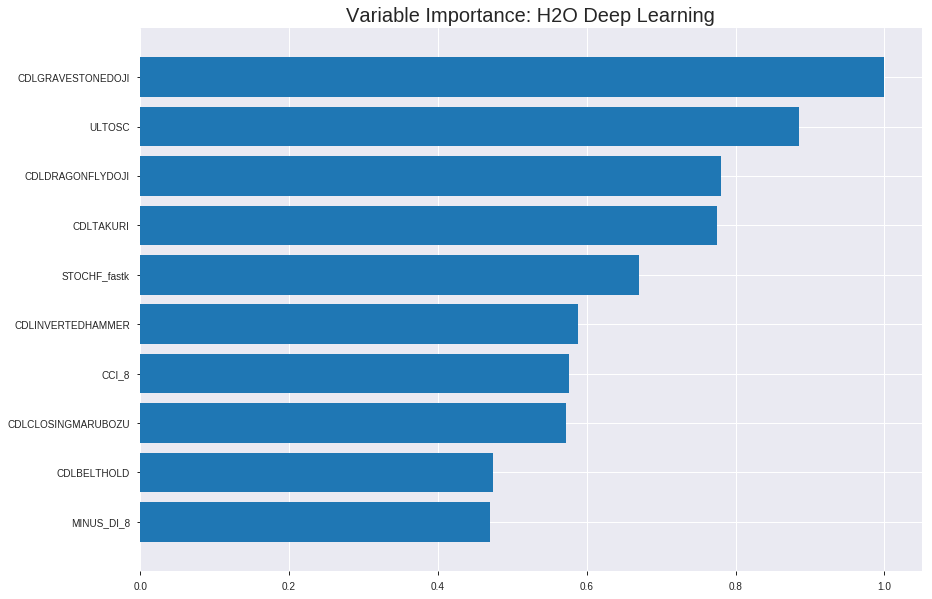

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190822_120335_model_9


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.1698932938508813
RMSE: 0.41218114203694634
LogLoss: 0.504792956993567
Mean Per-Class Error: 0.26262886275099273
AUC: 0.8280178622875253
pr_auc: 0.8337192956501507
Gini: 0.6560357245750505
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.385141265780933: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      416  474   0.5326   (474.0/890.0)
1      61   836   0.068    (61.0/897.0)
Total  477  1310  0.2994   (535.0/1787.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.385141     0.757589  249
max f2                       0.225154     0.860141  314
max f0point5                 0.563786     0.770586  162
max accuracy                 0.483477     0.736989  196
max precision                0.999369     1         0
max recall                   0.0342139    1         382
max specificity              0.999369     1         0
max absolute_mcc             0.524014     0.488934  176
max min_per_class_accuracy   0.483477     0.639911  196
max mean_per_class_accuracy  0.483477     0.737371  196

Gains/Lift Table: Avg response rate: 50.20 %, avg score: 50.82 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100727                   0.994474           1.9922    1.9922             1                0.997221   1                           0.997221            0.0200669       0.0200669                  99.2196   99.2196
    2        0.0201455                   0.992139           1.88152   1.93686            0.944444         0.993136   0.972222                    0.995178            0.0189521       0.039019                   88.1519   93.6857
    3        0.0302182                   0.98969            1.9922    1.9553             1                0.991226   0.981481                    0.993861            0.0200669       0.0590858                  99.2196   95.5304
    4        0.040291                    0.985386           1.9922    1.96453            1                0.987937   0.986111                    0.99238             0.0200669       0.0791527                  99.2196   96.4527
    5        0.0503637                   0.983023           1.9922    1.97006            1                0.98415    0.988889                    0.990734            0.0200669       0.0992196                  99.2196   97.0061
    6        0.100168                    0.955791           1.90266   1.93655            0.955056         0.973431   0.972067                    0.982131            0.0947603       0.19398                    90.2659   93.6548
    7        0.149972                    0.879752           1.76835   1.88069            0.88764          0.920786   0.94403                     0.961759            0.0880713       0.282051                   76.8354   88.0693
    8        0.200336                    0.779923           1.77084   1.85308            0.888889         0.833342   0.930168                    0.929475            0.0891862       0.371237                   77.0841   85.3076
    9        0.299944                    0.580952           1.49974   1.73574            0.752809         0.669858   0.871269                    0.843259            0.149387        0.520624                   49.9743   73.5738
    10       0.400112                    0.483324           1.16861   1.59376            0.586592         0.516      0.8                         0.76133             0.117057        0.637681                   16.8607   59.3757
    11       0.59653                     0.482918           0.913799  1.36987            0.458689         0.482929   0.687617                    0.669661            0.179487        0.817168                   -8.62006  36.9869
    12       0.599888                    0.48173            0.332033  1.36406            0.166667         0.482005   0.684701                    0.668611            0.00111483      0.818283                   -66.7967  36.406
    13       0.700056                    0.407256           0.856978  1.2915             0.430168         0.445048   0.648281                    0.636622            0.0858417       0.904125                   -14.3022  29.1504
    14       0.799664                    0.311239           0.537221  1.19755            0.269663         0.364898   0.60112                     0.602776            0.0535117       0.957637                   -46.2779  19.7548
    15       0.899832                    0.115149           0.289369  1.09645            0.145251         0.216497   0.550373                    0.559776            0.0289855       0.986622                   -71.0631  9.64513
    16       1                           6.08413e-11        0.133555  1                  0.0670391        0.0449595  0.501959                    



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.18300629755294198
RMSE: 0.427792353312845
LogLoss: 0.5434110975966037
Mean Per-Class Error: 0.26716500553709854
AUC: 0.8051633444075305
pr_auc: 0.7967516781482332
Gini: 0.6103266888150609
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.36122548645716773: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      114  138  0.5476   (138.0/252.0)
1      17   241  0.0659   (17.0/258.0)
Total  131  379  0.3039   (155.0/510.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.361225     0.756672  287
max f2                       0.311445     0.871369  317
max f0point5                 0.488278     0.737018  194
max accuracy                 0.437873     0.733333  224
max precision                0.999909     1         0
max recall                   0.0681682    1         379
max specificity              0.999909     1         0
max absolute_mcc             0.437873     0.467543  224
max min_per_class_accuracy   0.471467     0.72093   206
max mean_per_class_accuracy  0.437873     0.732835  224

Gains/Lift Table: Avg response rate: 50.59 %, avg score: 50.21 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117647                   0.996735           1.97674    1.97674            1                0.998993   1                           0.998993            0.0232558       0.0232558                  97.6744   97.6744
    2        0.0215686                   0.988559           1.97674    1.97674            1                0.990762   1                           0.995252            0.0193798       0.0426357                  97.6744   97.6744
    3        0.0313725                   0.984666           1.97674    1.97674            1                0.986839   1                           0.992623            0.0193798       0.0620155                  97.6744   97.6744
    4        0.0411765                   0.982001           1.97674    1.97674            1                0.98357    1                           0.990468            0.0193798       0.0813953                  97.6744   97.6744
    5        0.0509804                   0.979186           1.5814     1.90072            0.8              0.980269   0.961538                    0.988506            0.0155039       0.0968992                  58.1395   90.0716
    6        0.1                         0.940093           1.66047    1.78295            0.84             0.964426   0.901961                    0.976702            0.0813953       0.178295                   66.0465   78.2946
    7        0.15098                     0.870623           1.67263    1.7457             0.846154         0.916272   0.883117                    0.956297            0.0852713       0.263566                   67.263    74.5696
    8        0.2                         0.739916           1.5814     1.70543            0.8              0.815619   0.862745                    0.921817            0.0775194       0.341085                   58.1395   70.5426
    9        0.3                         0.578967           1.39535    1.60207            0.705882         0.638358   0.810458                    0.827331            0.139535        0.48062                    39.5349   60.2067
    10       0.4                         0.518274           1.24031    1.51163            0.627451         0.549133   0.764706                    0.757781            0.124031        0.604651                   24.031    51.1628
    11       0.5                         0.46745            1.16279    1.44186            0.588235         0.4904     0.729412                    0.704305            0.116279        0.72093                    16.2791   44.186
    12       0.6                         0.411083           0.930233   1.35659            0.470588         0.436509   0.686275                    0.659672            0.0930233       0.813953                   -6.97674  35.6589
    13       0.7                         0.377864           0.775194   1.27353            0.392157         0.3956     0.644258                    0.621948            0.0775194       0.891473                   -22.4806  27.3533
    14       0.8                         0.321281           0.775194   1.21124            0.392157         0.354659   0.612745                    0.588537            0.0775194       0.968992                   -22.4806  21.124
    15       0.9                         0.164462           0.232558   1.1025             0.117647         0.240967   0.557734                    0.549918            0.0232558       0.992248                   -76.7442  10.2498
    16       1                           0.000135219        0.0775194  1                  0.0392157        0.0717665  0.505882   


Scoring History: 


timestamp            duration           training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  -----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 12:29:49  0.000 sec                            0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-22 12:29:51  9 min 23.786 sec   223 obs/sec       0.218243  1             390        0.674015         3.06025             -0.817214      0.534476        0.412617           0.553388         0.474538                         0.702691           5.27948               -0.97537         0.538029          0.555314             0.988372           0.462745
    2019-08-22 12:30:40  10 min 12.825 sec  201 obs/sec       5.16508   23            9230       0.494678         0.682507            0.0211588      0.62559         0.560168           0.996098         0.390039                         0.499727           0.692589              0.000954213      0.700412          0.649587             0.988372           0.368627
    2019-08-22 12:31:30  11 min  3.111 sec  214 obs/sec       10.953    49            19573      0.466088         0.619621            0.131034       0.729411        0.749118           1.9922           0.37493                          0.606318           1.05637               -0.47069         0.67488           0.666418             1.97674            0.396078
    2019-08-22 12:32:21  11 min 53.797 sec  223 obs/sec       17.1556   77            30657      0.432286         0.546439            0.252505       0.799622        0.809359           1.9922           0.303861                         0.443549           0.575585              0.21295          0.78313           0.773609             1.97674            0.305882
    2019-08-22 12:33:10  12 min 43.948 sec  226 obs/sec       22.9916   103           41086      0.429285         0.539544            0.262845       0.802823        0.814756           1.88152          0.313934                         0.487189           0.673968              0.0504578        0.791867          0.796031             1.97674            0.321569
    2019-08-22 12:34:07  13 min 39.641 sec  232 obs/sec       30.1656   135           53906      0.424071         0.529599            0.280646       0.818292        0.831312           1.9922           0.286514                         0.443911           0.567167              0.211664         0.808047          0.799605             1.97674            0.305882
    2019-08-22 12:34:57  14 min 29.883 sec  236 obs/sec       36.6995   164           65582      0.412181         0.504793            0.320416       0.828018        0.833719           1.9922           0.299384                         0.427792           0.543411              0.267873         0.805163          0.796752             1.97674            0.303922
    2019-08-22 12:35:48  15 min 21.692 sec  240 obs/sec       43.6609   195           78022      0.412818         0.505763            0.318315       0.831939        0.836143           1.9922           0.269166                         0.447918           0.589259              0.197367         0.796935          0.795971             1.97674            0.315686
    2019-08-

Variable Importances: 


variable                 relative_importance    scaled_importance    percentage
-----------------------  ---------------------  -------------------  ---------------------
CDLGRAVESTONEDOJI        1.0                    1.0                  0.0054223862787157375
ULTOSC                   0.8851069808006287     0.8851069808006287   0.004799391947888843
CDLDRAGONFLYDOJI         0.780027449131012      0.780027449131012    0.004229610137189637
CDLTAKURI                0.775360643863678      0.775360643863678    0.004204304916342607
STOCHF_fastk             0.6701810359954834     0.6701810359954834   0.003633980453837407
---                      ---                    ---                  ---
BBANDS_middleband_8_3_4  0.14206154644489288    0.14206154644489288  0.0007703125801759256
CDLHARAMI                0.141066774725914      0.141066774725914    0.00076491854365648
CDLSEPARATINGLINES       0.13261255621910095    0.13261255621910095  0.0007190765052278724
CDLMARUBOZU              0.1325267255306244     0.1325267255306244   0.0007186110980803843
CDLXSIDEGAP3METHODS      0.12564204633235931    0.12564204633235931  0.0006812797080623522


See the whole table with table.as_data_frame()


('accuracy', 0.7890625)

('F1', 0.7737226277372263)

('auc', 0.8566715542521994)

('logloss', 0.4950912615809011)

('mean_per_class_error', 0.21505376344086025)

('rmse', 0.4057044147427171)

('mse', 0.1645960721417306)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


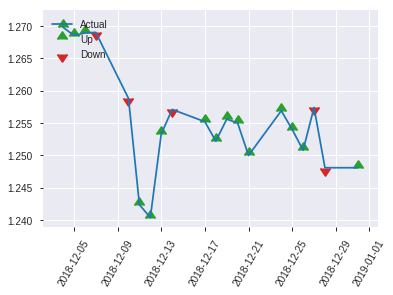


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.1645960721417306
RMSE: 0.4057044147427171
LogLoss: 0.4950912615809011
Mean Per-Class Error: 0.21505376344086025
AUC: 0.8566715542521994
pr_auc: 0.8519111981289585
Gini: 0.7133431085043989
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45494058970175644: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      88   44   0.3333   (44.0/132.0)
1      18   106  0.1452   (18.0/124.0)
Total  106  150  0.2422   (62.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.454941     0.773723  149
max f2                       0.359477     0.864286  203
max f0point5                 0.554104     0.829741  84
max accuracy                 0.54037      0.789062  91
max precision                0.993518     1         0
max recall                   0.117752     1         239
max specificity              0.993518     1         0
max absolute_mcc             0.554104     0.594646  84
max min_per_class_accuracy   0.494075     0.757576  125
max mean_per_class_accuracy  0.54037      0.784946  91

Gains/Lift Table: Avg response rate: 48.44 %, avg score: 52.03 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0117188                   0.991769           2.06452    2.06452            1                0.992616  1                           0.992616            0.0241935       0.0241935                  106.452    106.452
    2        0.0234375                   0.988808           2.06452    2.06452            1                0.989955  1                           0.991285            0.0241935       0.0483871                  106.452    106.452
    3        0.03125                     0.986285           2.06452    2.06452            1                0.987708  1                           0.990391            0.016129        0.0645161                  106.452    106.452
    4        0.0429688                   0.984934           2.06452    2.06452            1                0.985705  1                           0.989113            0.0241935       0.0887097                  106.452    106.452
    5        0.0507812                   0.982001           2.06452    2.06452            1                0.98239   1                           0.988078            0.016129        0.104839                   106.452    106.452
    6        0.101562                    0.956316           2.06452    2.06452            1                0.972833  1                           0.980456            0.104839        0.209677                   106.452    106.452
    7        0.152344                    0.905451           1.7469     1.95864            0.846154         0.935939  0.948718                    0.965617            0.0887097       0.298387                   74.6898    95.8644
    8        0.203125                    0.752976           1.7469     1.90571            0.846154         0.842554  0.923077                    0.934851            0.0887097       0.387097                   74.6898    90.5707
    9        0.300781                    0.569144           1.73419    1.85002            0.84             0.629333  0.896104                    0.835657            0.169355        0.556452                   73.4194    85.0021
    10       0.402344                    0.518592           1.11166    1.66364            0.538462         0.541669  0.805825                    0.761446            0.112903        0.669355                   11.1663    66.3639
    11       0.5                         0.491651           0.990968   1.53226            0.48             0.507149  0.742188                    0.711779            0.0967742       0.766129                   -0.903226  53.2258
    12       0.601562                    0.451626           0.952854   1.43444            0.461538         0.471608  0.694805                    0.671231            0.0967742       0.862903                   -4.71464   43.4437
    13       0.699219                    0.403484           0.578065   1.31483            0.28             0.430471  0.636872                    0.637605            0.0564516       0.919355                   -42.1935   31.4832
    14       0.800781                    0.357119           0.555831   1.21857            0.269231         0.382187  0.590244                    0.60521             0.0564516       0.975806                   -44.4169   21.8568
    15       0.898438                    0.184396           0.0825806  1.09509            0.04             0.258504  0.530435                    0.567525            0.00806452      0.983871                   -91.7419   9.50912
    16       1                           0.0252088          0.158809   1                  0.0769231        0.102087  0.484375  

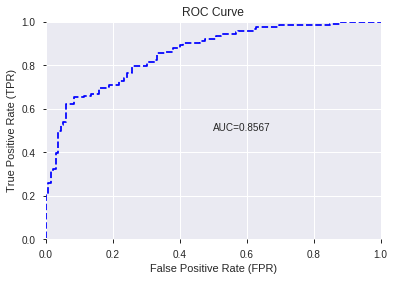

This function is available for GLM models only


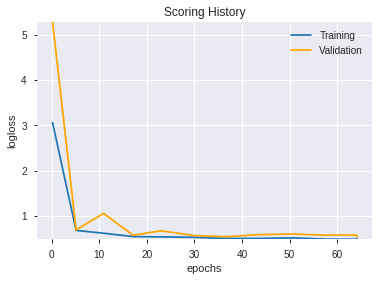

--2019-08-22 12:38:35--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.178.67
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.178.67|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


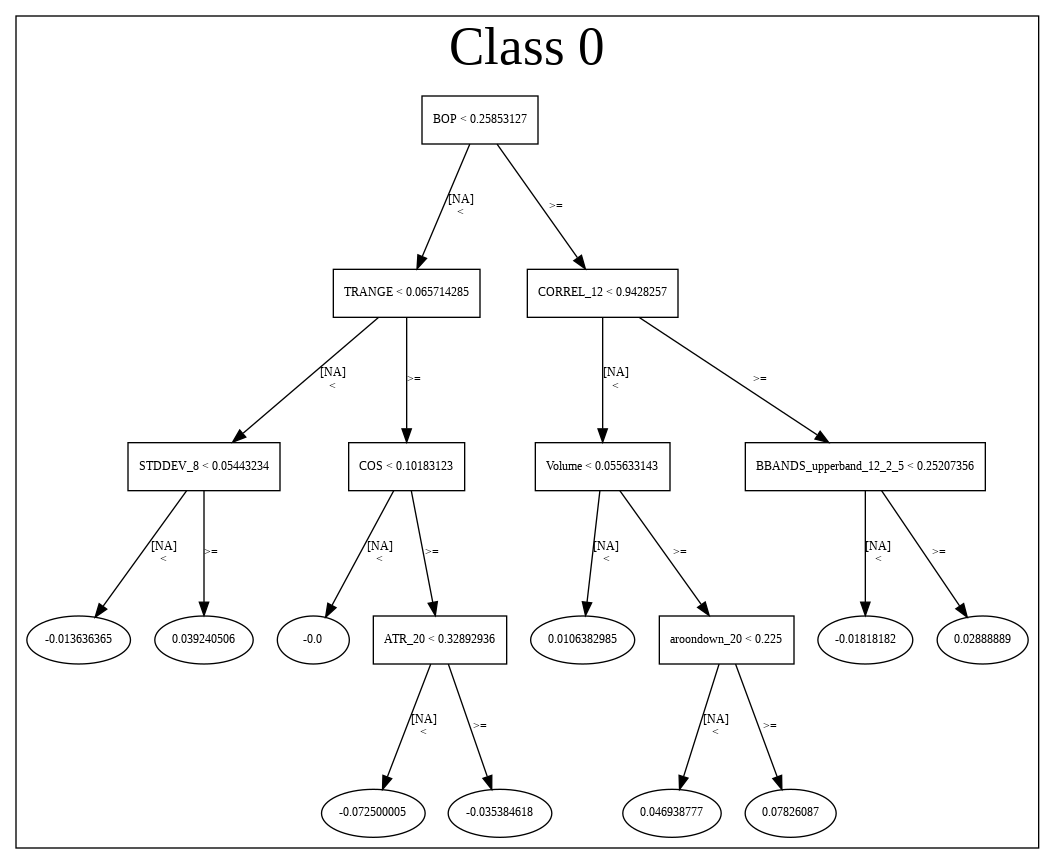

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190822_120335_model_9',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190822_120335_model_9',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_92dd',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [10]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190822_123848_model_8  0.851601  0.502368              0.217742  0.408334  0.166736
1  DeepLearning_grid_1_AutoML_20190822_123848_model_5  0.847446  0.506663              0.251955  0.410797  0.168755
2  DeepLearning_grid_1_AutoML_20190822_123848_model_9  0.828201  0.504775              0.289101  0.411737  0.169527
3  DeepLearning_grid_1_AutoML_20190822_123848_model_6  0.824963  0.510093              0.256232  0.415900  0.172973
4  DeepLearning_grid_1_AutoML_20190822_123848_model_2  0.815371  0.513900              0.299609  0.415918  0.172988
5               DeepLearning_1_AutoML_20190822_123848  0.804802  0.521517              0.342620  0.421290  0.177485
6  DeepLearning_grid_1_AutoML_20190822_123848_model_1  0.804741  0.580539              0.320137  0.438200  0.192019
7  DeepLearning_grid_1_AutoML_20190822_123848_model_3  0.797959  0.544362              0.331500  0.428804  0.183873
8  DeepLearning_grid_1_AutoML_20190822_123848_model_7  0.781525  0.721969              0.320870  0.471007  0.221848
9  DeepLearning_grid_1_AutoML_20190822_123848_model_4  0.769306  0.636151              0.344086  0.461035  0.212553

variable  relative_importance  scaled_importance  percentage
0              CDLDOJI             1.000000           1.000000    0.033512
1    CDLLONGLEGGEDDOJI             0.997963           0.997963    0.033444
2                  DIV             0.994682           0.994682    0.033334
3                  SUB             0.966282           0.966282    0.032382
4   CDLCLOSINGMARUBOZU             0.944783           0.944783    0.031662
5       CDLRICKSHAWMAN             0.856941           0.856941    0.028718
6               ULTOSC             0.807788           0.807788    0.027071
7         STOCHF_fastk             0.786276           0.786276    0.026350
8                  TAN             0.767845           0.767845    0.025732
9               TRANGE             0.752838           0.752838    0.025229
10   CDLGRAVESTONEDOJI             0.746103           0.746103    0.025003
11               CCI_8             0.718230           0.718230    0.024069
12   CDLINVERTEDHAMMER             0.680927           0.680927    0.022819
13         CDLBELTHOLD             0.679611           0.679611    0.022775
14           CDLTAKURI             0.626593           0.626593    0.020998
15        HT_TRENDMODE             0.599284           0.599284    0.020083
16                 SIN             0.585723           0.585723    0.019629
17              SAREXT             0.585634           0.585634    0.019626
18             BETA_30             0.578306           0.578306    0.019380
19                 day             0.564829           0.564829    0.018929
20          MINUS_DI_8             0.563767           0.563767    0.018893
21           PLUS_DM_8             0.563238           0.563238    0.018875
22           CDLHAMMER             0.556462           0.556462    0.018648
23           CORREL_12             0.543200           0.543200    0.018204
24            WILLR_14             0.537627           0.537627    0.018017
25             WILLR_8             0.532940           0.532940    0.017860
26    CDLDRAGONFLYDOJI             0.531246           0.531246    0.017803
27         MINUS_DM_24             0.525963           0.525963    0.017626
28             BETA_12             0.525020           0.525020    0.017594
29          PLUS_DI_14             0.523118           0.523118    0.017531
30       days_in_month             0.521781           0.521781    0.017486
31             BETA_14             0.504662           0.504662    0.016912
32              ROCR_8             0.502726           0.502726    0.016847
33      STOCHRSI_fastk             0.493418           0.493418    0.016535
34              CCI_14             0.485891           0.485891    0.016283
35           PLUS_DI_8             0.473279           0.473279    0.015861
36         MINUS_DI_12             0.467228           0.467228    0.015658
37            WILLR_12             0.466081           0.466081    0.015619
38               MOM_8             0.462739           0.462739    0.015507
39         MINUS_DI_14             0.461340           0.461340    0.015460
40       CDLHANGINGMAN             0.461060           0.461060    0.015451
41               ROC_8             0.459483           0.459483    0.015398
42     CDLSHOOTINGSTAR             0.452991           0.452991    0.015181
43              CCI_12             0.452153           0.452153    0.015153
44          PLUS_DM_12             0.448178           0.448178    0.015019
45          MINUS_DM_8             0.434736           0.434736    0.014569
46      is_month_start             0.429087           0.429087    0.014380
47              CCI_20             0.421053           0.421053    0.014110
48              CCI_30             0.407570           0.407570    0.013658
49              CCI_24             0.391384           0.391384    0.013116

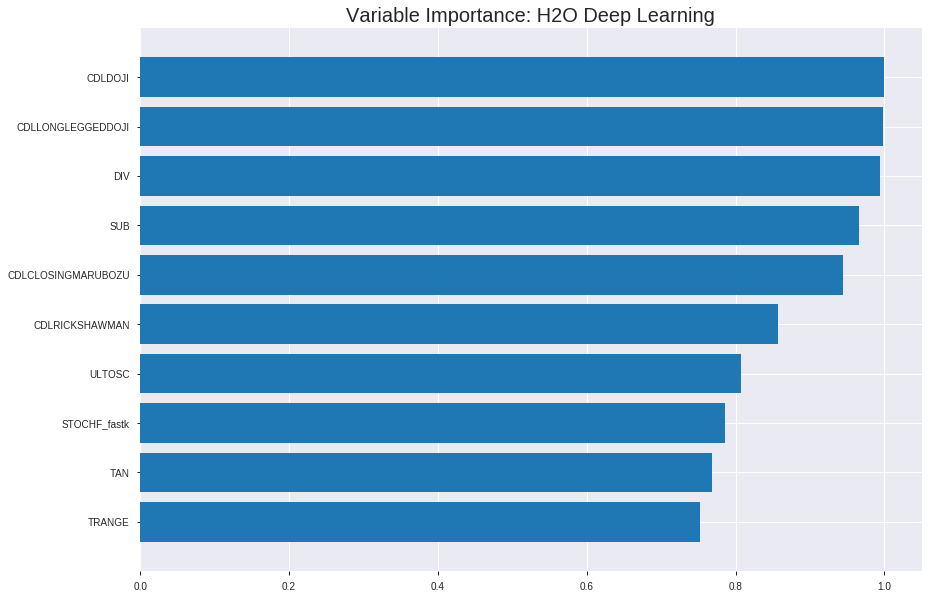

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190822_123848_model_8


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.1613418680860124
RMSE: 0.4016738329615366
LogLoss: 0.4725317926880272
Mean Per-Class Error: 0.2691192865105909
AUC: 0.8395344030664011
pr_auc: 0.8509241258650115
Gini: 0.6790688061328023
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.43645863143425795: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      446  444   0.4989   (444.0/890.0)
1      61   836   0.068    (61.0/897.0)
Total  507  1280  0.2826   (505.0/1787.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.436459     0.768029  223
max f2                       0.23117      0.87344   298
max f0point5                 0.571858     0.774674  139
max accuracy                 0.467041     0.731393  201
max precision                0.998958     1         0
max recall                   0.0872215    1         352
max specificity              0.998958     1         0
max absolute_mcc             0.571858     0.495197  139
max min_per_class_accuracy   0.472635     0.635955  194
max mean_per_class_accuracy  0.467041     0.730881  201

Gains/Lift Table: Avg response rate: 50.20 %, avg score: 49.52 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100727                   0.994176           1.9922    1.9922             1                0.996613   1                           0.996613            0.0200669       0.0200669                  99.2196   99.2196
    2        0.0201455                   0.990812           1.9922    1.9922             1                0.992778   1                           0.994695            0.0200669       0.0401338                  99.2196   99.2196
    3        0.0302182                   0.988212           1.9922    1.9922             1                0.989398   1                           0.99293             0.0200669       0.0602007                  99.2196   99.2196
    4        0.040291                    0.985729           1.9922    1.9922             1                0.987065   1                           0.991463            0.0200669       0.0802676                  99.2196   99.2196
    5        0.0503637                   0.981643           1.9922    1.9922             1                0.983278   1                           0.989826            0.0200669       0.100334                   99.2196   99.2196
    6        0.100168                    0.960876           1.96981   1.98107            0.988764         0.973133   0.994413                    0.981526            0.0981048       0.198439                   96.9812   98.1067
    7        0.149972                    0.92955            1.88028   1.94759            0.94382          0.94757    0.977612                    0.970249            0.0936455       0.292085                   88.0275   94.7595
    8        0.200336                    0.773557           1.83725   1.91985            0.922222         0.868037   0.963687                    0.944554            0.0925307       0.384615                   83.7248   91.9854
    9        0.299944                    0.497605           1.33186   1.72459            0.668539         0.595332   0.865672                    0.828581            0.132664        0.51728                    33.1862   72.4588
    10       0.400112                    0.472907           1.10183   1.56868            0.553073         0.482637   0.787413                    0.741974            0.110368        0.627648                   10.1829   56.868
    11       0.593173                    0.472628           1.01053   1.38702            0.507246         0.472629   0.696226                    0.65431             0.195095        0.822742                   1.05343   38.702
    12       0.599888                    0.471709           0.498049  1.37707            0.25             0.472236   0.691231                    0.652272            0.00334448      0.826087                   -50.1951  37.7068
    13       0.700056                    0.446091           0.912626  1.31061            0.458101         0.462062   0.657874                    0.625056            0.0914158       0.917503                   -8.73738  31.0613
    14       0.799664                    0.269976           0.559606  1.21707            0.280899         0.377727   0.610917                    0.594248            0.0557414       0.973244                   -44.0394  21.7066
    15       0.899832                    0.0827999          0.26711   1.11132            0.134078         0.161319   0.557836                    0.546055            0.0267559       1                          -73.289   11.1318
    16       1                           1.80944e-07        0         1                  0                0.0378632  0.501959                    0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.17576991569363581
RMSE: 0.41924922861424063
LogLoss: 0.5207270752309425
Mean Per-Class Error: 0.26527316352897756
AUC: 0.8194136827857759
pr_auc: 0.8260730499969445
Gini: 0.6388273655715517
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.41285202781870833: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      122  130  0.5159   (130.0/252.0)
1      19   239  0.0736   (19.0/258.0)
Total  141  369  0.2922   (149.0/510.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.412852     0.76236   263
max f2                       0.255353     0.869263  297
max f0point5                 0.506673     0.747126  143
max accuracy                 0.470974     0.735294  183
max precision                0.997381     1         0
max recall                   0.0360695    1         382
max specificity              0.997381     1         0
max absolute_mcc             0.470974     0.47188   183
max min_per_class_accuracy   0.472628     0.718254  169
max mean_per_class_accuracy  0.470974     0.734727  183

Gains/Lift Table: Avg response rate: 50.59 %, avg score: 50.18 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117647                   0.995354           1.97674    1.97674            1                0.996485   1                           0.996485            0.0232558       0.0232558                  97.6744   97.6744
    2        0.0215686                   0.993123           1.97674    1.97674            1                0.994265   1                           0.995476            0.0193798       0.0426357                  97.6744   97.6744
    3        0.0313725                   0.990041           1.97674    1.97674            1                0.990901   1                           0.994046            0.0193798       0.0620155                  97.6744   97.6744
    4        0.0411765                   0.987524           1.97674    1.97674            1                0.989021   1                           0.99285             0.0193798       0.0813953                  97.6744   97.6744
    5        0.0509804                   0.986101           1.97674    1.97674            1                0.986939   1                           0.991713            0.0193798       0.100775                   97.6744   97.6744
    6        0.1                         0.97404            1.97674    1.97674            1                0.981982   1                           0.986943            0.0968992       0.197674                   97.6744   97.6744
    7        0.15098                     0.957718           1.67263    1.87406            0.846154         0.968103   0.948052                    0.980582            0.0852713       0.282946                   67.263    87.4056
    8        0.2                         0.832978           1.50233    1.78295            0.76             0.910957   0.901961                    0.963517            0.0736434       0.356589                   50.2326   78.2946
    9        0.3                         0.503806           1.47287    1.67959            0.745098         0.659032   0.849673                    0.862022            0.147287        0.503876                   47.2868   67.9587
    10       0.515686                    0.472628           1.11416    1.4431             0.563636         0.474881   0.730038                    0.7001              0.24031         0.744186                   11.4165   44.3098
    11       0.6                         0.463684           0.781504   1.35013            0.395349         0.469427   0.683007                    0.667685            0.0658915       0.810078                   -21.8496  35.0129
    12       0.7                         0.425485           0.930233   1.29014            0.470588         0.448701   0.652661                    0.636401            0.0930233       0.903101                   -6.97674  29.0144
    13       0.8                         0.244006           0.658915   1.21124            0.333333         0.361306   0.612745                    0.602014            0.0658915       0.968992                   -34.1085  21.124
    14       0.9                         0.090699           0.232558   1.1025             0.117647         0.154109   0.557734                    0.552247            0.0232558       0.992248                   -76.7442  10.2498
    15       1                           0.000374683        0.0775194  1                  0.0392157        0.0476628  0.505882                    0.501789            0.00775194      1                          -92.2481  0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 12:44:35  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-22 12:44:36  1 min 16.107 sec  583 obs/sec       0.536654  1             959        0.479852         0.667539            0.0789551      0.757787        0.759001           1.88152          0.322328                         0.464508           0.623424              0.136811         0.771033          0.775317             1.97674            0.335294
    2019-08-22 12:44:47  1 min 26.461 sec  978 obs/sec       6.02462   11            10766      0.434171         0.546923            0.245971       0.807568        0.8151             1.88152          0.312815                         0.428524           0.535779              0.265366         0.814407          0.811966             1.97674            0.292157
    2019-08-22 12:44:57  1 min 36.753 sec  1114 obs/sec      12.6503   23            22606      0.414065         0.505958            0.314189       0.816419        0.827047           1.9922           0.300504                         0.422959           0.533356              0.284324         0.808747          0.809402             1.97674            0.270588
    2019-08-22 12:45:07  1 min 47.014 sec  1198 obs/sec      19.8053   36            35392      0.416861         0.509619            0.304898       0.818434        0.829862           1.9922           0.308338                         0.423961           0.52781               0.280928         0.822159          0.813627             1.97674            0.27451
    2019-08-22 12:45:18  1 min 57.652 sec  1253 obs/sec      27.4717   50            49092      0.410496         0.4923              0.325962       0.827023        0.839642           1.9922           0.273083                         0.423293           0.525701              0.283192         0.813807          0.816188             1.97674            0.298039
    2019-08-22 12:45:28  2 min  7.921 sec  1296 obs/sec      35.1365   64            62789      0.401674         0.472532            0.354623       0.839534        0.850924           1.9922           0.282597                         0.419249           0.520727              0.296823         0.819414          0.826073             1.97674            0.292157
    2019-08-22 12:45:39  2 min 18.329 sec  1322 obs/sec      42.8002   78            76484      0.39652          0.460902            0.371078       0.854338        0.853068           1.9922           0.251819                         0.430102           0.551645              0.259948         0.808686          0.809003             1.97674            0.305882
    2019-08-22 12:45:40  2 min 19.406 sec  1321 obs/sec      42.8002   78            76484      0.401674         0.472532            0.354623       0.839534        0.850924           1.9922           0.282597                         0.419249           0.520727              0.296823         0.819414          0.826073             1.97674            0.292157

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
CDLDOJI             1.0                    1.0                  0.03351199776794631
CDLLONGLEGGEDDOJI   0.9979627728462219     0.9979627728462219   0.033443726216116104
DIV                 0.9946815967559814     0.9946815967559814   0.033333767450303725
SUB                 0.9662824273109436     0.9662824273109436   0.03238205454725009
CDLCLOSINGMARUBOZU  0.9447832107543945     0.9447832107543945   0.03166157284999442
---                 ---                    ---                  ---
MINUS_DM_8          0.4347357749938965     0.4347357749938965   0.01456886432124187
is_month_start      0.42908668518066406    0.42908668518066406  0.014379552036029898
CCI_20              0.4210531711578369     0.4210531711578369   0.014110332932028149
CCI_30              0.4075702130794525     0.4075702130794525   0.013658492071000016
CCI_24              0.3913843035697937     0.3913843035697937   0.01311606990764015


See the whole table with table.as_data_frame()


('accuracy', 0.78125)

('F1', 0.7829457364341086)

('auc', 0.8516006842619745)

('logloss', 0.5023679231386011)

('mean_per_class_error', 0.217741935483871)

('rmse', 0.40833365624869583)

('mse', 0.1667363748254281)

deeplearning prediction progress: |███████████████████████████████████████| 100%


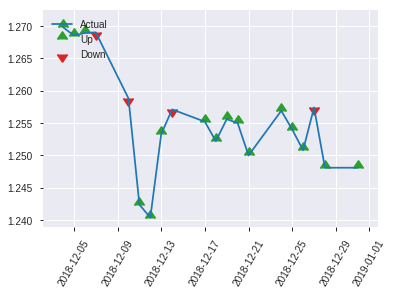


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.1667363748254281
RMSE: 0.40833365624869583
LogLoss: 0.5023679231386011
Mean Per-Class Error: 0.217741935483871
AUC: 0.8516006842619745
pr_auc: 0.8398498467949931
Gini: 0.7032013685239491
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4726278812746972: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      99   33   0.25     (33.0/132.0)
1      23   101  0.1855   (23.0/124.0)
Total  122  134  0.2188   (56.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.472628     0.782946  99
max f2                       0.416256     0.881924  155
max f0point5                 0.62763      0.779817  77
max accuracy                 0.472628     0.78125   99
max precision                0.996734     1         0
max recall                   0.0870924    1         206
max specificity              0.996734     1         0
max absolute_mcc             0.472628     0.564861  99
max min_per_class_accuracy   0.472628     0.75      99
max mean_per_class_accuracy  0.472628     0.782258  99

Gains/Lift Table: Avg response rate: 48.44 %, avg score: 53.22 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.99436            2.06452    2.06452            1                0.995975   1                           0.995975            0.0241935       0.0241935                  106.452   106.452
    2        0.0234375                   0.993203           2.06452    2.06452            1                0.993818   1                           0.994896            0.0241935       0.0483871                  106.452   106.452
    3        0.03125                     0.990401           2.06452    2.06452            1                0.991666   1                           0.994089            0.016129        0.0645161                  106.452   106.452
    4        0.0429688                   0.98902            2.06452    2.06452            1                0.989588   1                           0.992861            0.0241935       0.0887097                  106.452   106.452
    5        0.0507812                   0.987243           2.06452    2.06452            1                0.988192   1                           0.992143            0.016129        0.104839                   106.452   106.452
    6        0.101562                    0.97683            1.90571    1.98511            0.923077         0.982033   0.961538                    0.987088            0.0967742       0.201613                   90.5707   98.5112
    7        0.152344                    0.958092           1.90571    1.95864            0.923077         0.968094   0.948718                    0.980757            0.0967742       0.298387                   90.5707   95.8644
    8        0.203125                    0.905658           1.7469     1.90571            0.846154         0.926773   0.923077                    0.967261            0.0887097       0.387097                   74.6898   90.5707
    9        0.300781                    0.646853           1.56903    1.7964             0.76             0.782271   0.87013                     0.907199            0.153226        0.540323                   56.9032   79.6397
    10       0.523438                    0.472628           1.23147    1.55609            0.596491         0.492692   0.753731                    0.730879            0.274194        0.814516                   23.1466   55.6091
    11       0.601562                    0.464574           0.412903   1.40762            0.2              0.469091   0.681818                    0.696881            0.0322581       0.846774                   -58.7097  40.7625
    12       0.699219                    0.441402           0.908387   1.3379             0.44             0.453821   0.648045                    0.662934            0.0887097       0.935484                   -9.16129  33.7899
    13       0.800781                    0.326124           0.476427   1.22864            0.230769         0.396196   0.595122                    0.629103            0.0483871       0.983871                   -52.3573  22.8639
    14       0.898438                    0.133954           0.0825806  1.10407            0.04             0.214305   0.534783                    0.584017            0.00806452      0.991935                   -91.7419  10.4067
    15       1                           0.0152214          0.0794045  1                  0.0384615        0.0739887  0.484375                    0.532217            0.00806452      1                          -92.0596  0

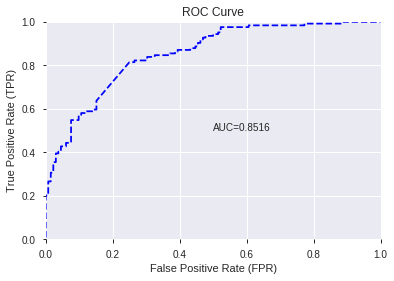

This function is available for GLM models only


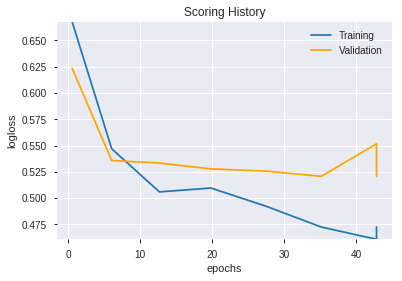

--2019-08-22 12:46:54--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.239.27
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.239.27|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


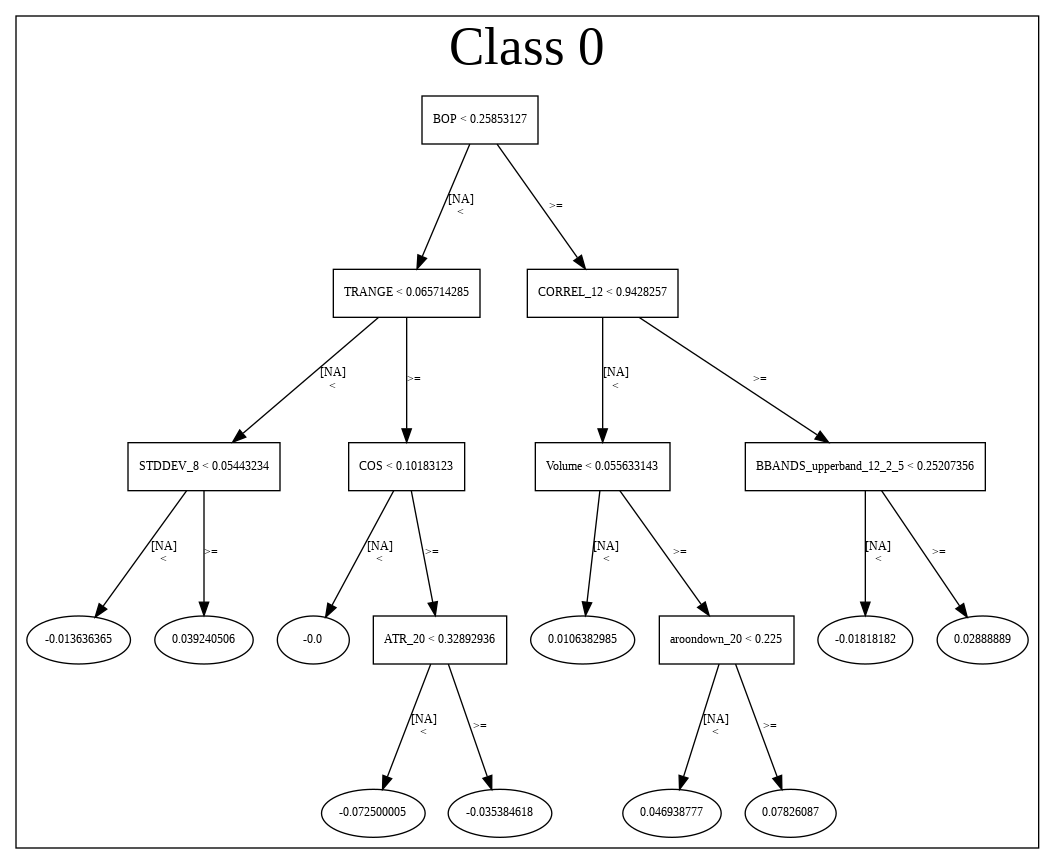

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190822_123848_model_8',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190822_123848_model_8',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_92dd',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLDOJI',
 'CDLLONGLEGGEDDOJI',
 'DIV',
 'SUB',
 'CDLCLOSINGMARUBOZU',
 'CDLRICKSHAWMAN',
 'ULTOSC',
 'STOCHF_fastk',
 'TAN',
 'TRANGE',
 'CDLGRAVESTONEDOJI',
 'CCI_8',
 'CDLINVERTEDHAMMER',
 'CDLBELTHOLD',
 'CDLTAKURI',
 'HT_TRENDMODE',
 'SIN',
 'SAREXT',
 'BETA_30',
 'day',
 'MINUS_DI_8',
 'PLUS_DM_8',
 'CDLHAMMER',
 'CORREL_12',
 'WILLR_14',
 'WILLR_8',
 'CDLDRAGONFLYDOJI',
 'MINUS_DM_24',
 'BETA_12',
 'PLUS_DI_14',
 'days_in_month',
 'BETA_14',
 'ROCR_8',
 'STOCHRSI_fastk',
 'CCI_14',
 'PLUS_DI_8',
 'MINUS_DI_12',
 'WILLR_12',
 'MOM_8',
 'MINUS_DI_14',
 'CDLHANGINGMAN',
 'ROC_8',
 'CDLSHOOTINGSTAR',
 'CCI_12',
 'PLUS_DM_12',
 'MINUS_DM_8',
 'is_month_start',
 'CCI_20',
 'CCI_30',
 'CCI_24']

In [11]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190822_124707_model_1  0.867485  0.455998              0.237292  0.387339  0.150031

variable  relative_importance  scaled_importance  percentage
0                CCI_8             0.960475           1.000000    0.096418
1            CDLTAKURI             0.779734           0.811821    0.078274
2         STOCHF_fastk             0.772944           0.804752    0.077592
3           MINUS_DI_8             0.757307           0.788472    0.076023
4             WILLR_14             0.516873           0.538143    0.051886
5    CDLGRAVESTONEDOJI             0.496065           0.516479    0.049798
6              WILLR_8             0.418814           0.436049    0.042043
7     CDLDRAGONFLYDOJI             0.392206           0.408346    0.039372
8          MINUS_DI_14             0.338474           0.352402    0.033978
9               CCI_30             0.305554           0.318129    0.030673
10              CCI_14             0.293928           0.306023    0.029506
11          PLUS_DI_14             0.273707           0.284970    0.027476
12              CCI_20             0.265486           0.276411    0.026651
13            WILLR_12             0.258184           0.268809    0.025918
14           PLUS_DM_8             0.230888           0.240390    0.023178
15              CCI_24             0.204420           0.212832    0.020521
16   CDLINVERTEDHAMMER             0.176378           0.183636    0.017706
17              CCI_12             0.175323           0.182538    0.017600
18          PLUS_DM_12             0.157474           0.163954    0.015808
19              ULTOSC             0.149060           0.155194    0.014963
20           PLUS_DI_8             0.128471           0.133758    0.012897
21              TRANGE             0.120695           0.125661    0.012116
22               MOM_8             0.120034           0.124974    0.012050
23                 TAN             0.115434           0.120184    0.011588
24  CDLCLOSINGMARUBOZU             0.113703           0.118382    0.011414
25         MINUS_DI_12             0.106049           0.110413    0.010646
26      STOCHRSI_fastk             0.101874           0.106067    0.010227
27             CDLDOJI             0.098979           0.103052    0.009936
28                 SUB             0.085716           0.089243    0.008605
29          MINUS_DM_8             0.080621           0.083939    0.008093
30              ROCR_8             0.079917           0.083206    0.008023
31               ROC_8             0.075149           0.078242    0.007544
32         MINUS_DM_24             0.073584           0.076612    0.007387
33   CDLLONGLEGGEDDOJI             0.071764           0.074717    0.007204
34       days_in_month             0.071567           0.074512    0.007184
35             BETA_14             0.068226           0.071034    0.006849
36                 DIV             0.067473           0.070249    0.006773
37         CDLBELTHOLD             0.066800           0.069549    0.006706
38           CDLHAMMER             0.062437           0.065006    0.006268
39       CDLHANGINGMAN             0.059168           0.061603    0.005940
40      is_month_start             0.054227           0.056459    0.005444
41      CDLRICKSHAWMAN             0.043059           0.044831    0.004322
42                 day             0.036860           0.038377    0.003700
43              SAREXT             0.036137           0.037624    0.003628
44        HT_TRENDMODE             0.033297           0.034668    0.003343
45             BETA_30             0.030940           0.032214    0.003106
46                 SIN             0.020065           0.020891    0.002014
47     CDLSHOOTINGSTAR             0.008933           0.009301    0.000897
48           CORREL_12             0.004414           0.004595    0.000443
49             BETA_12             0.002726           0.002838    0.000274

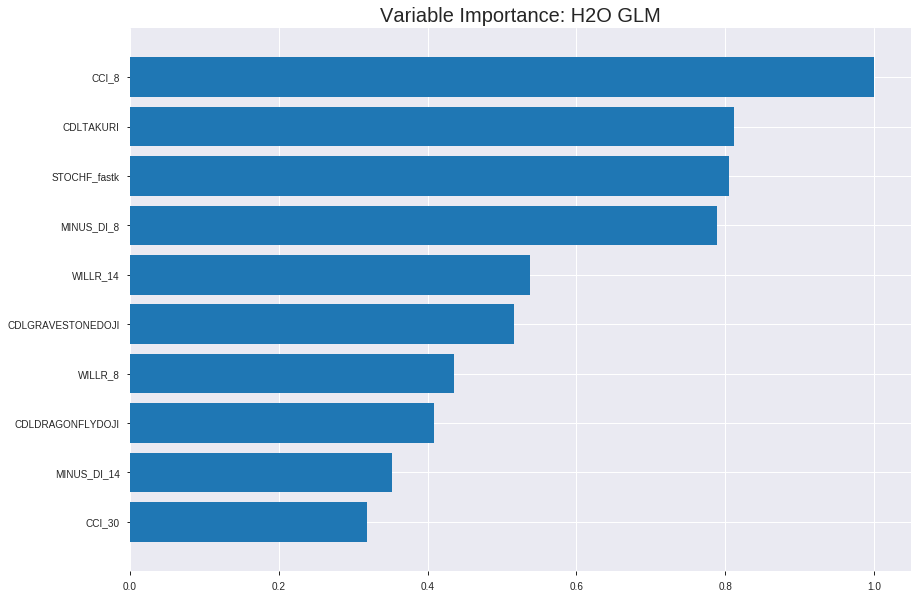

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190822_124707_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.18403710044306396
RMSE: 0.4289954550377707
LogLoss: 0.5412726191739453
Null degrees of freedom: 1786
Residual degrees of freedom: 1736
Null deviance: 2477.2806029937074
Residual deviance: 1934.5083409276804
AIC: 2036.5083409276804
AUC: 0.7945229416406749
pr_auc: 0.7990297824301845
Gini: 0.5890458832813499
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3713565314359417: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      439  451   0.5067   (451.0/890.0)
1      99   798   0.1104   (99.0/897.0)
Total  538  1249  0.3078   (550.0/1787.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.371357     0.743709  262
max f2                       0.156588     0.853305  343
max f0point5                 0.586558     0.720201  155
max accuracy                 0.485347     0.715165  205
max precision                0.996107     1         0
max recall                   0.0592884    1         383
max specificity              0.996107     1         0
max absolute_mcc             0.483292     0.430476  206
max min_per_class_accuracy   0.496163     0.710145  200
max mean_per_class_accuracy  0.485347     0.715115  205

Gains/Lift Table: Avg response rate: 50.20 %, avg score: 50.20 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100727                   0.97935            1.9922    1.9922             1                0.987016   1                           0.987016            0.0200669       0.0200669                  99.2196   99.2196
    2        0.0201455                   0.969351           1.88152   1.93686            0.944444         0.972938   0.972222                    0.979977            0.0189521       0.039019                   88.1519   93.6857
    3        0.0302182                   0.964205           1.88152   1.91841            0.944444         0.966826   0.962963                    0.975593            0.0189521       0.057971                   88.1519   91.8411
    4        0.040291                    0.959065           1.9922    1.93686            1                0.961985   0.972222                    0.972191            0.0200669       0.0780379                  99.2196   93.6857
    5        0.0503637                   0.947891           1.88152   1.92579            0.944444         0.953042   0.966667                    0.968361            0.0189521       0.09699                    88.1519   92.579
    6        0.100168                    0.898507           1.85789   1.89203            0.932584         0.925341   0.949721                    0.946971            0.0925307       0.189521                   85.7891   89.203
    7        0.149972                    0.808042           1.63405   1.80636            0.820225         0.855996   0.906716                    0.916759            0.0813824       0.270903                   63.4049   80.6357
    8        0.200336                    0.714916           1.63803   1.76404            0.822222         0.756438   0.885475                    0.876455            0.0824972       0.3534                     63.8028   76.404
    9        0.299944                    0.623767           1.30948   1.61308            0.657303         0.668393   0.809701                    0.80736             0.130435        0.483835                   30.9477   61.3084
    10       0.400112                    0.552532           1.19087   1.50738            0.597765         0.584679   0.756643                    0.751612            0.119287        0.603122                   19.0866   50.7382
    11       0.50028                     0.495495           1.06844   1.4195             0.536313         0.522588   0.712528                    0.705756            0.107023        0.710145                   6.84404   41.9496
    12       0.599888                    0.433302           0.962522  1.34362            0.483146         0.463548   0.67444                     0.665539            0.0958751       0.80602                    -3.74782  34.3617
    13       0.700056                    0.369629           0.845849  1.27239            0.424581         0.400883   0.638689                    0.62767             0.0847269       0.890747                   -15.4151  27.2394
    14       0.799664                    0.282748           0.548414  1.18221            0.275281         0.333334   0.593422                    0.591007            0.0546265       0.945373                   -45.1586  18.2213
    15       0.899832                    0.138026           0.400665  1.09521            0.201117         0.21269    0.549751                    0.548893            0.0401338       0.985507                   -59.9335  9.52123
    16       1                           3.97403e-05        0.144685  1                  0.0726257        0.0803342  0.501959                    0.



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.1761029346443997
RMSE: 0.41964620175142736
LogLoss: 0.5275660430170066
Null degrees of freedom: 509
Residual degrees of freedom: 459
Null deviance: 706.9709434262809
Residual deviance: 538.1173638773467
AIC: 640.1173638773467
AUC: 0.8198443460071367
pr_auc: 0.8140123458864446
Gini: 0.6396886920142735
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3466448904262287: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      150  102  0.4048   (102.0/252.0)
1      25   233  0.0969   (25.0/258.0)
Total  175  335  0.249    (127.0/510.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.346645     0.785835  258
max f2                       0.135245     0.853659  344
max f0point5                 0.493848     0.761618  177
max accuracy                 0.439258     0.75098   207
max precision                0.979962     1         0
max recall                   0.0488915    1         387
max specificity              0.979962     1         0
max absolute_mcc             0.346645     0.5248    258
max min_per_class_accuracy   0.454736     0.742063  199
max mean_per_class_accuracy  0.439258     0.7506    207

Gains/Lift Table: Avg response rate: 50.59 %, avg score: 47.80 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117647                   0.970037           1.97674   1.97674            1                0.974213   1                           0.974213            0.0232558       0.0232558                  97.6744   97.6744
    2        0.0215686                   0.961772           1.97674   1.97674            1                0.965959   1                           0.970461            0.0193798       0.0426357                  97.6744   97.6744
    3        0.0313725                   0.955362           1.97674   1.97674            1                0.957507   1                           0.966413            0.0193798       0.0620155                  97.6744   97.6744
    4        0.0411765                   0.948912           1.97674   1.97674            1                0.951428   1                           0.962845            0.0193798       0.0813953                  97.6744   97.6744
    5        0.0509804                   0.946286           0.790698  1.74866            0.4              0.947828   0.884615                    0.959957            0.00775194      0.0891473                  -20.9302  74.8658
    6        0.1                         0.920932           1.89767   1.82171            0.96             0.935376   0.921569                    0.947908            0.0930233       0.182171                   89.7674   82.1705
    7        0.15098                     0.833522           1.67263   1.77137            0.846154         0.892088   0.896104                    0.929059            0.0852713       0.267442                   67.263    77.1368
    8        0.2                         0.727112           1.89767   1.80233            0.96             0.767601   0.911765                    0.889486            0.0930233       0.360465                   89.7674   80.2326
    9        0.3                         0.606967           1.27907   1.62791            0.647059         0.654794   0.823529                    0.811255            0.127907        0.488372                   27.907    62.7907
    10       0.4                         0.529029           1.35659   1.56008            0.686275         0.564241   0.789216                    0.749502            0.135659        0.624031                   35.6589   56.0078
    11       0.5                         0.4572             1.16279   1.48062            0.588235         0.490897   0.74902                     0.697781            0.116279        0.74031                    16.2791   48.062
    12       0.6                         0.386294           0.968992  1.39535            0.490196         0.423948   0.705882                    0.652142            0.0968992       0.837209                   -3.10078  39.5349
    13       0.7                         0.32813            0.697674  1.29568            0.352941         0.354241   0.655462                    0.609585            0.0697674       0.906977                   -30.2326  29.5681
    14       0.8                         0.224297           0.348837  1.17733            0.176471         0.280398   0.595588                    0.568436            0.0348837       0.94186                    -65.1163  17.7326
    15       0.9                         0.11027            0.426357  1.09388            0.215686         0.169256   0.553377                    0.524083            0.0426357       0.984496                   -57.3643  9.38846
    16       1                           0.0117071          0.155039  1                  0.0784314        0.0630315  0.505882                    


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-22 12:47:07  0.000 sec   2            .16E2     51            1.369813276005582   1.366349257612666
     2019-08-22 12:47:07  0.031 sec   4            .96E1     51            1.3607943169619496  1.3554898557598651
     2019-08-22 12:47:07  0.061 sec   6            .6E1      51            1.3476296868202675  1.3396704427251565
     2019-08-22 12:47:07  0.090 sec   8            .37E1     51            1.3293431627130512  1.317768728984825
     2019-08-22 12:47:07  0.119 sec   10           .23E1     51            1.3055402602161004  1.289386343673312
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-22 12:47:07  0.552 sec   44           .7E-3     51            1.0816365345932015  1.0552440348775873
     2019-08-22 12:47:07  0.580 sec   46           .44E-3    51            1.0810195845193555  1.055448619950652
     2019-08-22 12:47:08  0.589 sec   47           .27E-3    51            1.0806309408249972  1.0556741834048278
     2019-08-22 12:47:08  0.599 sec   48           .17E-3    51            1.0803530177039522  1.0558050985790806
     2019-08-22 12:47:08  0.612 sec   49           .1E-3     51            1.080190666627015   1.0559703038633166


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.78125)

('F1', 0.7862068965517242)

('auc', 0.8674853372434018)

('logloss', 0.45599802212532026)

('mean_per_class_error', 0.22128543499511233)

('rmse', 0.38733860752240623)

('mse', 0.15003119687739666)

glm prediction progress: |████████████████████████████████████████████████| 100%


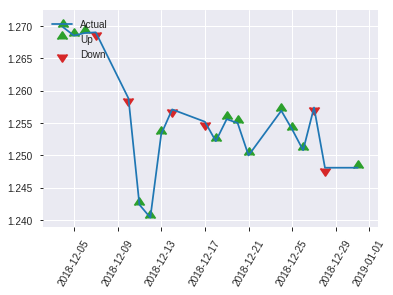


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.15003119687739666
RMSE: 0.38733860752240623
LogLoss: 0.45599802212532026
Null degrees of freedom: 255
Residual degrees of freedom: 205
Null deviance: 354.9579598113329
Residual deviance: 233.47098732816397
AIC: 335.470987328164
AUC: 0.8674853372434018
pr_auc: 0.8644539768032677
Gini: 0.7349706744868036
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37626026336304336: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      80   52   0.3939   (52.0/132.0)
1      10   114  0.0806   (10.0/124.0)
Total  90   166  0.2422   (62.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.37626      0.786207  165
max f2                       0.307587     0.868613  188
max f0point5                 0.623263     0.818182  78
max accuracy                 0.543918     0.78125   101
max precision                0.982868     1         0
max recall                   0.0588967    1         240
max specificity              0.982868     1         0
max absolute_mcc             0.623263     0.57084   78
max min_per_class_accuracy   0.4695       0.772727  125
max mean_per_class_accuracy  0.448451     0.778715  136

Gains/Lift Table: Avg response rate: 48.44 %, avg score: 49.53 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0117188                   0.974174           2.06452    2.06452            1                0.978567   1                           0.978567            0.0241935       0.0241935                  106.452    106.452
    2        0.0234375                   0.972875           2.06452    2.06452            1                0.973137   1                           0.975852            0.0241935       0.0483871                  106.452    106.452
    3        0.03125                     0.970819           2.06452    2.06452            1                0.971495   1                           0.974763            0.016129        0.0645161                  106.452    106.452
    4        0.0429688                   0.962132           2.06452    2.06452            1                0.966399   1                           0.972481            0.0241935       0.0887097                  106.452    106.452
    5        0.0507812                   0.955017           2.06452    2.06452            1                0.958652   1                           0.970354            0.016129        0.104839                   106.452    106.452
    6        0.101562                    0.93514            2.06452    2.06452            1                0.945513   1                           0.957934            0.104839        0.209677                   106.452    106.452
    7        0.152344                    0.892717           1.90571    2.01158            0.923077         0.912773   0.974359                    0.94288             0.0967742       0.306452                   90.5707    101.158
    8        0.203125                    0.810368           1.7469     1.94541            0.846154         0.847309   0.942308                    0.918987            0.0887097       0.395161                   74.6898    94.5409
    9        0.300781                    0.632721           1.73419    1.87683            0.84             0.716992   0.909091                    0.853404            0.169355        0.564516                   73.4194    87.6833
    10       0.402344                    0.540232           1.19107    1.70373            0.576923         0.582878   0.825243                    0.785116            0.120968        0.685484                   19.1067    70.3727
    11       0.5                         0.466558           0.990968   1.56452            0.48             0.502921   0.757812                    0.73                0.0967742       0.782258                   -0.903226  56.4516
    12       0.601562                    0.396742           0.952854   1.46125            0.461538         0.43481    0.707792                    0.680163            0.0967742       0.879032                   -4.71464   46.1248
    13       0.699219                    0.340201           0.495484   1.32637            0.24             0.370127   0.642458                    0.636862            0.0483871       0.927419                   -50.4516   32.6365
    14       0.800781                    0.220332           0.476427   1.21857            0.230769         0.283566   0.590244                    0.592053            0.0483871       0.975806                   -52.3573   21.8568
    15       0.898438                    0.101728           0.165161   1.10407            0.08             0.157397   0.534783                    0.544808            0.016129        0.991935                   -83.4839   10.4067
    16       1                           0.0145762          0.0794045  1                  0.0384615        0.0

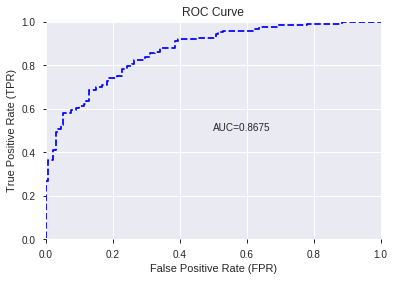

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


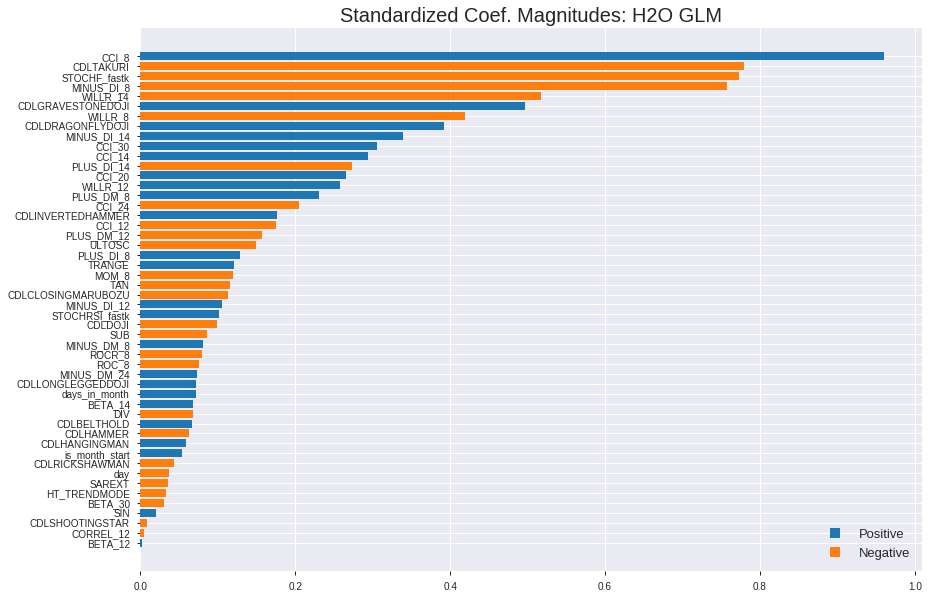

'log_likelihood'
--2019-08-22 12:47:13--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.0.164
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.0.164|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


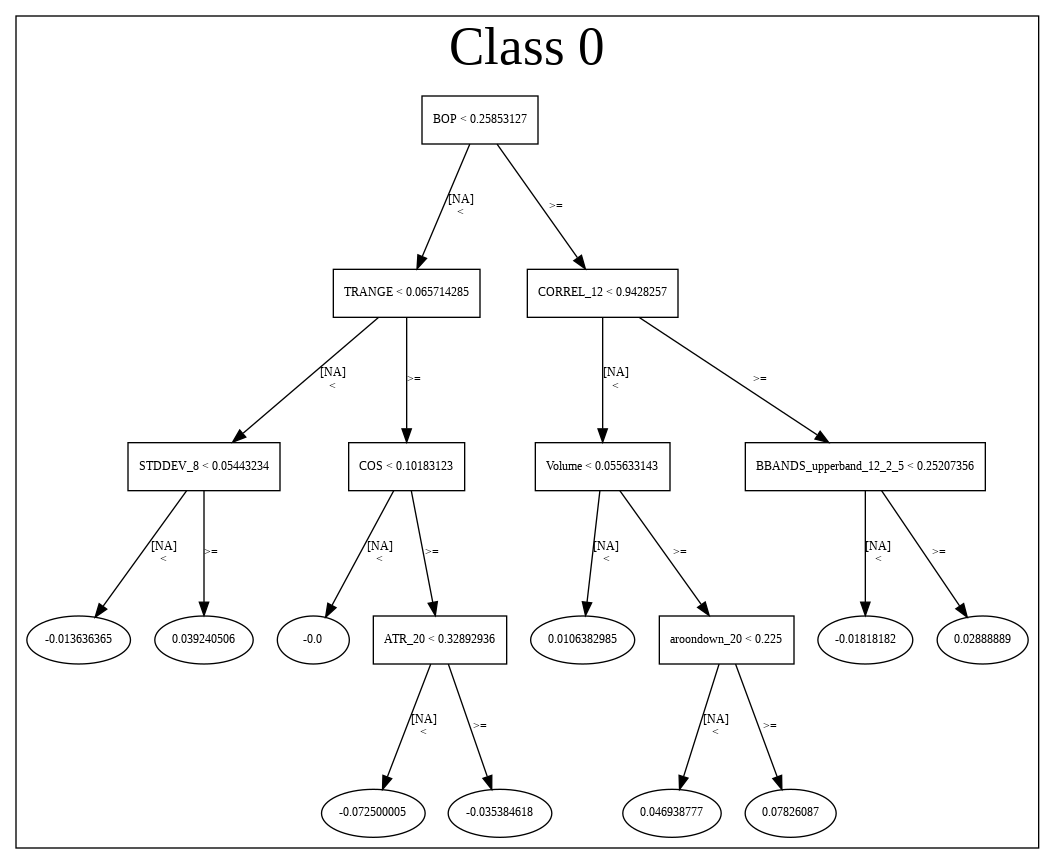

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190822_124707_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190822_124707_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_92dd',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['CCI_8',
 'CDLTAKURI',
 'STOCHF_fastk',
 'MINUS_DI_8',
 'WILLR_14',
 'CDLGRAVESTONEDOJI',
 'WILLR_8',
 'CDLDRAGONFLYDOJI',
 'MINUS_DI_14',
 'CCI_30',
 'CCI_14',
 'PLUS_DI_14',
 'CCI_20',
 'WILLR_12',
 'PLUS_DM_8',
 'CCI_24',
 'CDLINVERTEDHAMMER',
 'CCI_12',
 'PLUS_DM_12',
 'ULTOSC',
 'PLUS_DI_8',
 'TRANGE',
 'MOM_8',
 'TAN',
 'CDLCLOSINGMARUBOZU',
 'MINUS_DI_12',
 'STOCHRSI_fastk',
 'CDLDOJI',
 'SUB',
 'MINUS_DM_8',
 'ROCR_8',
 'ROC_8',
 'MINUS_DM_24',
 'CDLLONGLEGGEDDOJI',
 'days_in_month',
 'BETA_14',
 'DIV',
 'CDLBELTHOLD',
 'CDLHAMMER',
 'CDLHANGINGMAN',
 'is_month_start',
 'CDLRICKSHAWMAN',
 'day',
 'SAREXT',
 'HT_TRENDMODE',
 'BETA_30',
 'SIN',
 'CDLSHOOTINGSTAR',
 'CORREL_12',
 'BETA_12']

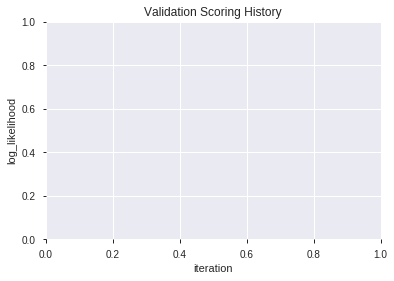

In [12]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190822_124725_model_7  0.861009  0.476023              0.223607  0.394845  0.155902
1  XGBoost_grid_1_AutoML_20190822_124725_model_3  0.855633  0.476302              0.242302  0.396903  0.157532
2               XGBoost_1_AutoML_20190822_124725  0.854717  0.485405              0.252199  0.399409  0.159528
3  XGBoost_grid_1_AutoML_20190822_124725_model_5  0.852456  0.483830              0.218231  0.402347  0.161883
4  XGBoost_grid_1_AutoML_20190822_124725_model_6  0.847996  0.488438              0.247312  0.403232  0.162596
5               XGBoost_2_AutoML_20190822_124725  0.846774  0.492904              0.235948  0.404464  0.163591
6  XGBoost_grid_1_AutoML_20190822_124725_model_2  0.843781  0.497251              0.235704  0.407042  0.165683
7  XGBoost_grid_1_AutoML_20190822_124725_model_4  0.842864  0.503855              0.251588  0.408858  0.167165
8  XGBoost_grid_1_AutoML_20190822_124725_model_1  0.842681  0.490882              0.267595  0.403970  0.163192
9               XGBoost_3_AutoML_20190822_124725  0.839321  0.497828              0.250122  0.408324  0.166728

variable  relative_importance  scaled_importance  percentage
0   CDLGRAVESTONEDOJI          1137.364136           1.000000    0.095361
1        STOCHF_fastk           634.775208           0.558111    0.053222
2               CCI_8           623.010742           0.547767    0.052236
3           CDLTAKURI           617.262817           0.542713    0.051754
4              ULTOSC           516.302612           0.453947    0.043289
5                 DIV           443.265381           0.389730    0.037165
6             WILLR_8           424.207214           0.372974    0.035567
7           CORREL_12           370.971527           0.326168    0.031104
8          MINUS_DI_8           339.168823           0.298206    0.028437
9            WILLR_14           335.921783           0.295351    0.028165
10            BETA_12           331.235962           0.291231    0.027772
11           WILLR_12           322.192871           0.283280    0.027014
12            BETA_14           294.989105           0.259362    0.024733
13                TAN           291.236420           0.256063    0.024418
14              ROC_8           290.961243           0.255821    0.024395
15             SAREXT           290.361176           0.255293    0.024345
16             CCI_14           285.798523           0.251281    0.023963
17                day           279.307098           0.245574    0.023418
18             CCI_12           279.190948           0.245472    0.023409
19         PLUS_DM_12           277.385712           0.243885    0.023257
20                SIN           266.266907           0.234109    0.022325
21             TRANGE           248.371552           0.218375    0.020824
22            BETA_30           247.970779           0.218022    0.020791
23          PLUS_DM_8           231.306946           0.203371    0.019394
24        MINUS_DI_12           227.267670           0.199820    0.019055
25                SUB           224.092819           0.197028    0.018789
26        MINUS_DM_24           222.783737           0.195877    0.018679
27         PLUS_DI_14           211.267456           0.185752    0.017714
28          PLUS_DI_8           208.184845           0.183042    0.017455
29              MOM_8           207.408401           0.182359    0.017390
30         MINUS_DM_8           177.888565           0.156404    0.014915
31        MINUS_DI_14           158.199966           0.139094    0.013264
32     STOCHRSI_fastk           149.717484           0.131635    0.012553
33             CCI_20           147.583038           0.129759    0.012374
34             CCI_30           136.074493           0.119640    0.011409
35             CCI_24           111.970932           0.098448    0.009388
36   CDLDRAGONFLYDOJI            85.120903           0.074841    0.007137
37             ROCR_8            68.383644           0.060125    0.005734
38     CDLRICKSHAWMAN            57.978397           0.050976    0.004861
39       HT_TRENDMODE            57.204845           0.050296    0.004796
40      days_in_month            36.900448           0.032444    0.003094
41            CDLDOJI            32.296318           0.028396    0.002708
42  CDLINVERTEDHAMMER            19.839767           0.017444    0.001663
43  CDLLONGLEGGEDDOJI             7.911930           0.006956    0.000663

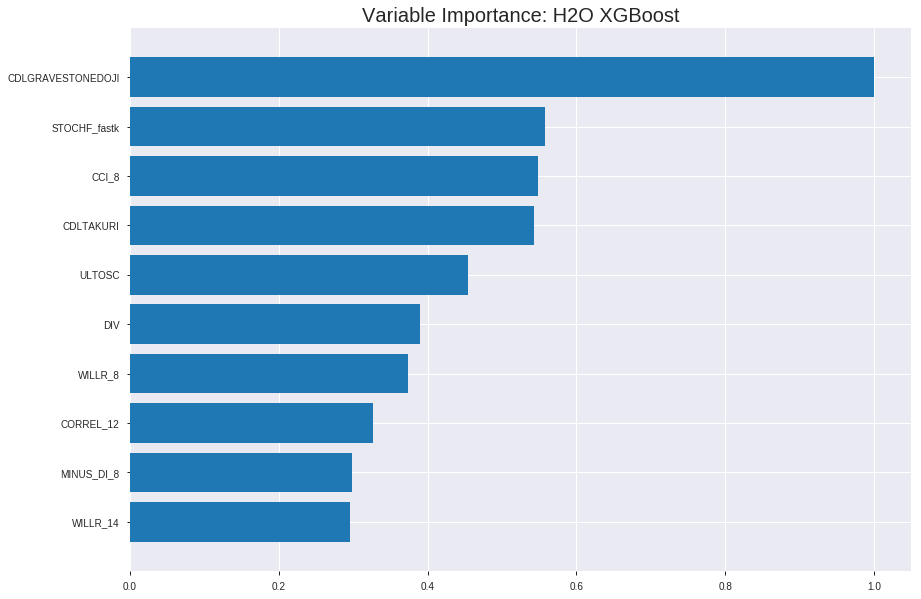

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190822_124725_model_7


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.09511230721776623
RMSE: 0.3084028327006194
LogLoss: 0.33694483394143737
Mean Per-Class Error: 0.07938947553016917
AUC: 0.9705547831097415
pr_auc: 0.9682312499781874
Gini: 0.941109566219483
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4961223006248474: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      821  69   0.0775   (69.0/890.0)
1      73   824  0.0814   (73.0/897.0)
Total  894  893  0.0795   (142.0/1787.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.496122     0.92067   198
max f2                       0.37821      0.939979  245
max f0point5                 0.5245       0.930367  188
max accuracy                 0.521888     0.920537  189
max precision                0.964622     1         0
max recall                   0.169156     1         340
max specificity              0.964622     1         0
max absolute_mcc             0.521888     0.841705  189
max min_per_class_accuracy   0.494024     0.919101  199
max mean_per_class_accuracy  0.521888     0.920611  189

Gains/Lift Table: Avg response rate: 50.20 %, avg score: 50.41 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100727                   0.949259           1.9922     1.9922             1                0.955894   1                           0.955894            0.0200669       0.0200669                  99.2196   99.2196
    2        0.0201455                   0.942036           1.9922     1.9922             1                0.945385   1                           0.95064             0.0200669       0.0401338                  99.2196   99.2196
    3        0.0302182                   0.93642            1.9922     1.9922             1                0.939872   1                           0.947051            0.0200669       0.0602007                  99.2196   99.2196
    4        0.040291                    0.930112           1.9922     1.9922             1                0.933218   1                           0.943592            0.0200669       0.0802676                  99.2196   99.2196
    5        0.0503637                   0.925306           1.9922     1.9922             1                0.928084   1                           0.940491            0.0200669       0.100334                   99.2196   99.2196
    6        0.100168                    0.891811           1.9922     1.9922             1                0.909957   1                           0.925309            0.0992196       0.199554                   99.2196   99.2196
    7        0.149972                    0.85279            1.96981    1.98476            0.988764         0.87223    0.996269                    0.907682            0.0981048       0.297659                   96.9812   98.4763
    8        0.200336                    0.809251           1.94793    1.9755             0.977778         0.831373   0.99162                     0.888498            0.0981048       0.395764                   94.7925   97.5502
    9        0.299944                    0.721646           1.90266    1.95131            0.955056         0.762738   0.979478                    0.846735            0.189521        0.585284                   90.2659   95.1312
    10       0.400112                    0.62158            1.82525    1.91975            0.916201         0.674075   0.963636                    0.803509            0.182832        0.768116                   82.5252   91.9753
    11       0.50028                     0.494625           1.50249    1.83621            0.75419          0.563033   0.9217                      0.75536             0.150502        0.918618                   50.2494   83.6208
    12       0.599888                    0.378585           0.570798   1.62609            0.286517         0.43321    0.816231                    0.701869            0.0568562       0.975474                   -42.9202  62.6093
    13       0.700056                    0.290674           0.144685   1.41412            0.0726257        0.333306   0.709832                    0.649133            0.0144928       0.989967                   -85.5315  41.4125
    14       0.799664                    0.206032           0.0783448  1.24774            0.0393258        0.247647   0.626312                    0.599123            0.00780379      0.99777                    -92.1655  24.7737
    15       0.899832                    0.123067           0.0222592  1.11132            0.0111732        0.165635   0.557836                    0.550868            0.00222965      1                          -97.7741  11.1318
    16       1                           0.03455            0          1                  0                0.0835111  0.501959 



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.1705221292796045
RMSE: 0.4129432518877194
LogLoss: 0.5112541009919743
Mean Per-Class Error: 0.25087670727205613
AUC: 0.8266349821582379
pr_auc: 0.8230993788292252
Gini: 0.6532699643164759
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2927105724811554: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      125  127  0.504    (127.0/252.0)
1      17   241  0.0659   (17.0/258.0)
Total  142  368  0.2824   (144.0/510.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.292711     0.769968  290
max f2                       0.242472     0.861948  311
max f0point5                 0.547426     0.761618  174
max accuracy                 0.494717     0.74902   195
max precision                0.952776     1         0
max recall                   0.083977     1         385
max specificity              0.952776     1         0
max absolute_mcc             0.494717     0.498247  195
max min_per_class_accuracy   0.48381      0.742063  200
max mean_per_class_accuracy  0.494717     0.749123  195

Gains/Lift Table: Avg response rate: 50.59 %, avg score: 50.50 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117647                   0.942069           1.97674   1.97674            1                0.946832   1                           0.946832            0.0232558       0.0232558                  97.6744   97.6744
    2        0.0215686                   0.937742           1.5814    1.79704            0.8              0.938516   0.909091                    0.943052            0.0155039       0.0387597                  58.1395   79.704
    3        0.0313725                   0.929108           1.97674   1.8532             1                0.932835   0.9375                      0.939859            0.0193798       0.0581395                  97.6744   85.3198
    4        0.0411765                   0.922581           1.97674   1.88261            1                0.926332   0.952381                    0.936638            0.0193798       0.0775194                  97.6744   88.2614
    5        0.0509804                   0.916818           1.97674   1.90072            1                0.919677   0.961538                    0.933377            0.0193798       0.0968992                  97.6744   90.0716
    6        0.1                         0.892508           1.97674   1.93798            1                0.905925   0.980392                    0.91992             0.0968992       0.193798                   97.6744   93.7984
    7        0.15098                     0.850247           1.52057   1.79704            0.769231         0.873145   0.909091                    0.904126            0.0775194       0.271318                   52.0572   79.704
    8        0.2                         0.808467           1.66047   1.76357            0.84             0.828059   0.892157                    0.885482            0.0813953       0.352713                   66.0465   76.3566
    9        0.3                         0.685676           1.35659   1.62791            0.686275         0.747122   0.823529                    0.839362            0.135659        0.488372                   35.6589   62.7907
    10       0.4                         0.577786           1.39535   1.56977            0.705882         0.638784   0.794118                    0.789218            0.139535        0.627907                   39.5349   56.9767
    11       0.5                         0.488865           1.12403   1.48062            0.568627         0.538018   0.74902                     0.738978            0.112403        0.74031                    12.4031   48.062
    12       0.6                         0.411174           0.852713  1.37597            0.431373         0.446707   0.696078                    0.690266            0.0852713       0.825581                   -14.7287  37.5969
    13       0.7                         0.312368           0.891473  1.30676            0.45098          0.36515    0.661064                    0.643821            0.0891473       0.914729                   -10.8527  30.6755
    14       0.8                         0.212674           0.465116  1.20155            0.235294         0.26484    0.607843                    0.596448            0.0465116       0.96124                    -53.4884  20.155
    15       0.9                         0.140552           0.271318  1.09819            0.137255         0.18131    0.555556                    0.550322            0.0271318       0.988372                   -72.8682  9.81912
    16       1                           0.0399516          0.116279  1                  0.0588235        0.0971037  0.505882                    0.5


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 12:47:47  14.329 sec  0                  0.5              0.693147            0.5             0                  1                0.498041                         0.5                0.693147              0.5               0                    1                  0.494118
    2019-08-22 12:47:47  14.503 sec  5                  0.465899         0.62674             0.877073        0.880363           1.9922           0.217124                         0.472383           0.638986              0.806924          0.80368              1.97674            0.286275
    2019-08-22 12:47:47  14.607 sec  10                 0.438525         0.574997            0.902035        0.900249           1.9922           0.173475                         0.452583           0.600518              0.821344          0.821357             1.97674            0.276471
    2019-08-22 12:47:47  14.718 sec  15                 0.418237         0.536745            0.909662        0.909823           1.9922           0.168439                         0.439078           0.573445              0.821775          0.822664             1.97674            0.290196
    2019-08-22 12:47:47  14.827 sec  20                 0.402294         0.506576            0.918985        0.918309           1.9922           0.155568                         0.429538           0.553392              0.824174          0.823975             1.97674            0.260784
    2019-08-22 12:47:47  14.931 sec  25                 0.389889         0.482689            0.923659        0.920906           1.9922           0.149972                         0.423234           0.539608              0.827535          0.826785             1.97674            0.266667
    2019-08-22 12:47:48  15.033 sec  30                 0.378413         0.46097             0.931117        0.928908           1.9922           0.136542                         0.420222           0.532222              0.826781          0.824369             1.97674            0.266667
    2019-08-22 12:47:48  15.148 sec  35                 0.367071         0.439965            0.937306        0.934904           1.9922           0.131505                         0.417858           0.526319              0.827273          0.826862             1.97674            0.278431
    2019-08-22 12:47:48  15.243 sec  40                 0.357945         0.422947            0.942263        0.939083           1.9922           0.126469                         0.415582           0.520359              0.827704          0.826503             1.97674            0.260784
    2019-08-22 12:47:48  15.342 sec  45                 0.350733         0.409286            0.944862        0.93798            1.9922           0.118635                         0.41396            0.516536              0.829157          0.826184             1.97674            0.254902
    2019-08-22 12:47:48  15.452 sec  50                 0.341876         0.393687            0.951072        0.947841           1.9922           0.106883                         0.412998           0.51371               0.829296          0.82909              1.97674            0.268627
    2019-08-22 12:47:48  15.560 sec  55                 0.335257         0.381778            0.955083        0.951048           1.9922           0.105764                         0.411602           0.511071              0.831034          0

Variable Importances: 


variable           relative_importance    scaled_importance     percentage
-----------------  ---------------------  --------------------  ---------------------
CDLGRAVESTONEDOJI  1137.3641357421875     1.0                   0.09536124445282465
STOCHF_fastk       634.7752075195312      0.5581107998497846    0.053222140416236796
CCI_8              623.0107421875         0.5477671772909861    0.052235759696879464
CDLTAKURI          617.2628173828125      0.5427134529611463    0.05175383025566442
ULTOSC             516.3026123046875      0.4539466263087098    0.043288915199959914
---                ---                    ---                   ---
HT_TRENDMODE       57.2048454284668       0.05029598141068317   0.0047962873782988824
days_in_month      36.900447845458984     0.03244382927669825   0.0030938839346409306
CDLDOJI            32.29631805419922      0.0283957591410461    0.002707854928872827
CDLINVERTEDHAMMER  19.839767456054688     0.017443637294847738  0.001663446960220384
CDLLONGLEGGEDDOJI  7.911930084228516      0.006956373808169696  0.000663368463226097


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.78125)

('F1', 0.7883211678832117)

('auc', 0.8610092864125123)

('logloss', 0.47602272812052865)

('mean_per_class_error', 0.2201857282502444)

('rmse', 0.39484480941935374)

('mse', 0.1559024235254058)

xgboost prediction progress: |████████████████████████████████████████████| 100%


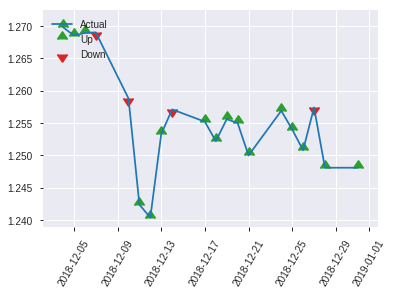


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.1559024235254058
RMSE: 0.39484480941935374
LogLoss: 0.47602272812052865
Mean Per-Class Error: 0.2201857282502444
AUC: 0.8610092864125123
pr_auc: 0.8386100034240583
Gini: 0.7220185728250246
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46200650930404663: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      90   42   0.3182   (42.0/132.0)
1      16   108  0.129    (16.0/124.0)
Total  106  150  0.2266   (58.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.462007     0.788321  149
max f2                       0.198497     0.873239  213
max f0point5                 0.641752     0.805785  89
max accuracy                 0.566961     0.78125   113
max precision                0.959799     1         0
max recall                   0.198497     1         213
max specificity              0.959799     1         0
max absolute_mcc             0.641752     0.563254  89
max min_per_class_accuracy   0.547275     0.766129  123
max mean_per_class_accuracy  0.566961     0.779814  113

Gains/Lift Table: Avg response rate: 48.44 %, avg score: 52.42 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.947958           2.06452   2.06452            1                0.955086  1                           0.955086            0.0241935       0.0241935                  106.452   106.452
    2        0.0234375                   0.942758           1.37634   1.72043            0.666667         0.945182  0.833333                    0.950134            0.016129        0.0403226                  37.6344   72.043
    3        0.03125                     0.939025           2.06452   1.80645            1                0.940002  0.875                       0.947601            0.016129        0.0564516                  106.452   80.6452
    4        0.0429688                   0.936734           2.06452   1.87683            1                0.937702  0.909091                    0.944901            0.0241935       0.0806452                  106.452   87.6833
    5        0.0507812                   0.930078           2.06452   1.90571            1                0.934085  0.923077                    0.943237            0.016129        0.0967742                  106.452   90.5707
    6        0.101562                    0.901504           2.06452   1.98511            1                0.919339  0.961538                    0.931288            0.104839        0.201613                   106.452   98.5112
    7        0.152344                    0.874783           2.06452   2.01158            1                0.88872   0.974359                    0.917099            0.104839        0.306452                   106.452   101.158
    8        0.203125                    0.829376           1.58809   1.90571            0.769231         0.856188  0.923077                    0.901871            0.0806452       0.387097                   58.8089   90.5707
    9        0.300781                    0.712684           1.56903   1.7964             0.76             0.760365  0.87013                     0.855928            0.153226        0.540323                   56.9032   79.6397
    10       0.402344                    0.589676           1.27047   1.66364            0.615385         0.643208  0.805825                    0.802232            0.129032        0.669355                   27.0471   66.3639
    11       0.5                         0.520251           1.07355   1.54839            0.52             0.561706  0.75                        0.755254            0.104839        0.774194                   7.35484   54.8387
    12       0.601562                    0.455885           0.952854  1.44784            0.461538         0.483394  0.701299                    0.709356            0.0967742       0.870968                   -4.71464  44.7842
    13       0.699219                    0.353944           0.743226  1.34943            0.36             0.394302  0.653631                    0.665354            0.0725806       0.943548                   -25.6774  34.9432
    14       0.800781                    0.253548           0.158809  1.19843            0.0769231        0.29779   0.580488                    0.618736            0.016129        0.959677                   -84.1191  19.8426
    15       0.898438                    0.137956           0.412903  1.11304            0.2              0.18672   0.53913                     0.571778            0.0403226       1                          -58.7097  11.3043
    16       1                           0.0606025          0         1                  0                0.102892  0.484375                    0.524156          

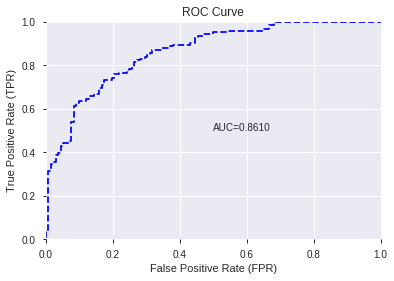

This function is available for GLM models only


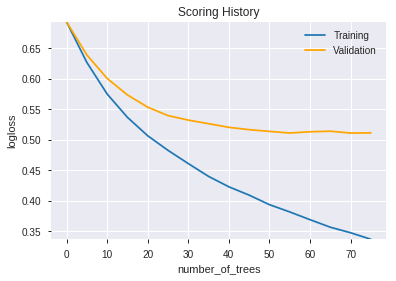

--2019-08-22 12:47:54--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.166.107
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.166.107|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

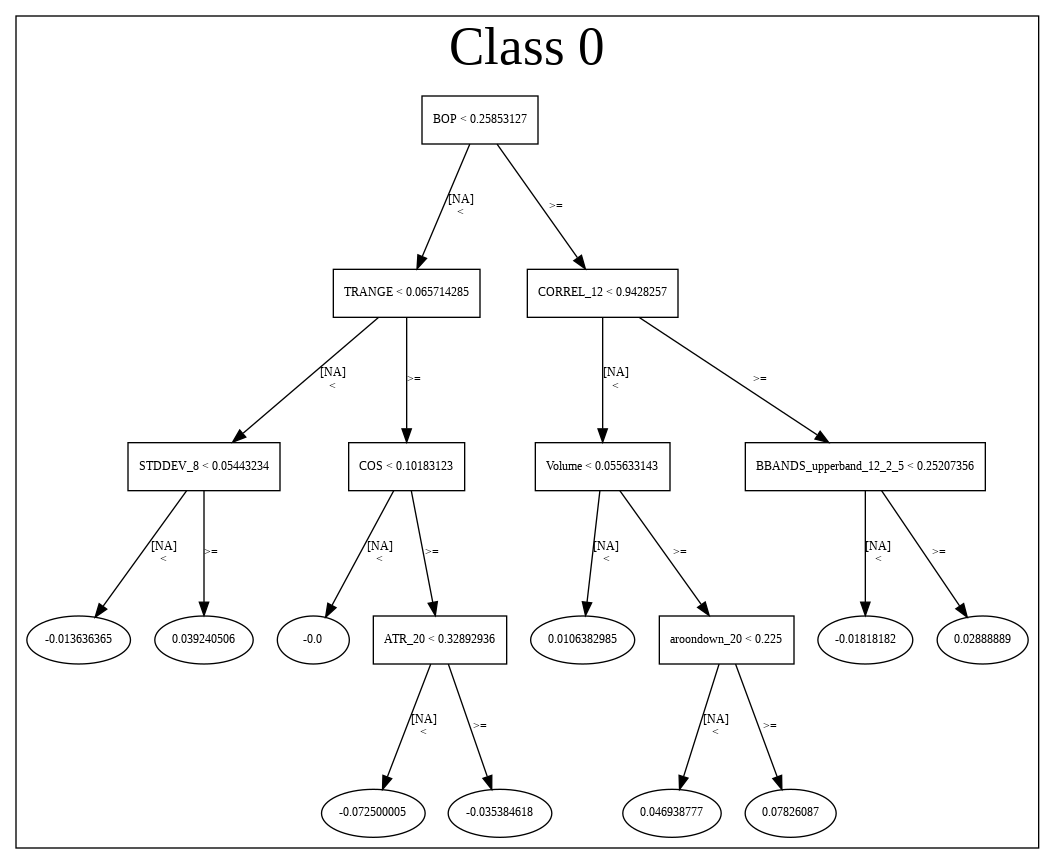

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190822_124725_model_7',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190822_124725_model_7',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_92dd',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['CDLGRAVESTONEDOJI',
 'STOCHF_fastk',
 'CCI_8',
 'CDLTAKURI',
 'ULTOSC',
 'DIV',
 'WILLR_8',
 'CORREL_12',
 'MINUS_DI_8',
 'WILLR_14',
 'BETA_12',
 'WILLR_12',
 'BETA_14',
 'TAN',
 'ROC_8',
 'SAREXT',
 'CCI_14',
 'day',
 'CCI_12',
 'PLUS_DM_12',
 'SIN',
 'TRANGE',
 'BETA_30',
 'PLUS_DM_8',
 'MINUS_DI_12',
 'SUB',
 'MINUS_DM_24',
 'PLUS_DI_14',
 'PLUS_DI_8',
 'MOM_8',
 'MINUS_DM_8',
 'MINUS_DI_14',
 'STOCHRSI_fastk',
 'CCI_20',
 'CCI_30',
 'CCI_24',
 'CDLDRAGONFLYDOJI',
 'ROCR_8',
 'CDLRICKSHAWMAN',
 'HT_TRENDMODE',
 'days_in_month',
 'CDLDOJI',
 'CDLINVERTEDHAMMER',
 'CDLLONGLEGGEDDOJI']

In [13]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190822_124803_model_1  0.865103  0.483846              0.227884  0.397985  0.158392

variable  relative_importance  scaled_importance    percentage
0            CDLGRAVESTONEDOJI             0.324756           1.000000  2.309928e-02
1                        CCI_8             0.308948           0.951323  2.197488e-02
2                 STOCHF_fastk             0.297792           0.916972  2.118139e-02
3                    CDLTAKURI             0.207829           0.639955  1.478250e-02
4                       ULTOSC             0.197293           0.607510  1.403305e-02
...                        ...                  ...                ...           ...
1014                   DEMA_12             0.000028           0.000087  2.020316e-06
1015                  TRIMA_24             0.000019           0.000060  1.379189e-06
1016                 MAVP_12_5             0.000011           0.000035  8.146118e-07
1017                    SMA_12             0.000010           0.000030  6.835169e-07
1018  BBANDS_middleband_24_3_3             0.000003           0.000008  1.907228e-07

[1019 rows x 4 columns]

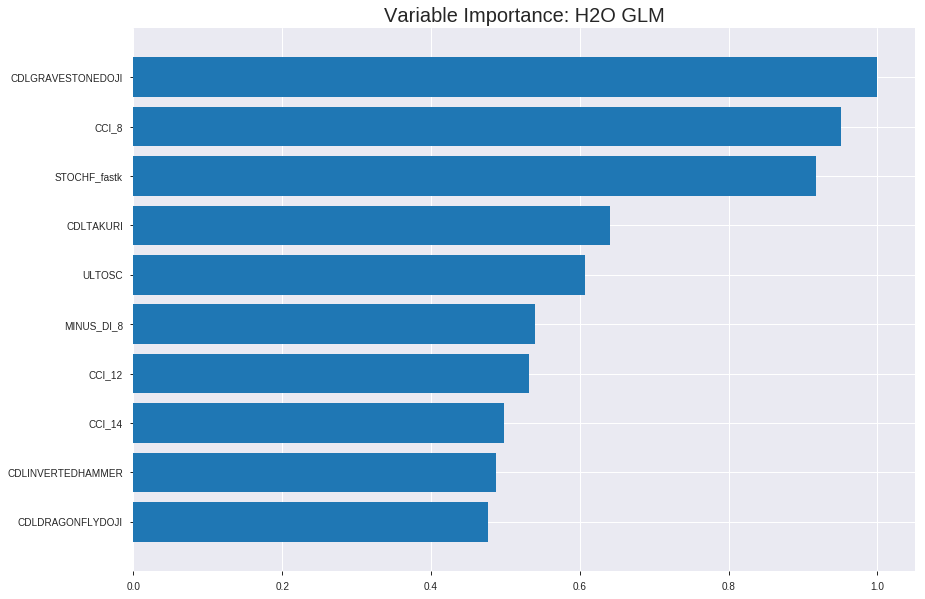

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190822_124803_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.17760804189389642
RMSE: 0.4214356912909684
LogLoss: 0.5286068222584559
Null degrees of freedom: 1786
Residual degrees of freedom: 767
Null deviance: 2477.2806029937074
Residual deviance: 1889.2407827517213
AIC: 3929.2407827517213
AUC: 0.8201245099144464
pr_auc: 0.825834407843287
Gini: 0.6402490198288928
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.43834570005574214: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      535  355   0.3989   (355.0/890.0)
1      135  762   0.1505   (135.0/897.0)
Total  670  1117  0.2742   (490.0/1787.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.438346     0.756703  233
max f2                       0.265168     0.852106  315
max f0point5                 0.569042     0.756278  160
max accuracy                 0.482649     0.742026  209
max precision                0.995049     1         0
max recall                   0.0920028    1         377
max specificity              0.995049     1         0
max absolute_mcc             0.482649     0.484461  209
max min_per_class_accuracy   0.491556     0.737079  204
max mean_per_class_accuracy  0.482649     0.741932  209

Gains/Lift Table: Avg response rate: 50.20 %, avg score: 50.20 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100727                   0.954311           1.9922    1.9922             1                0.97251   1                           0.97251             0.0200669       0.0200669                  99.2196   99.2196
    2        0.0201455                   0.942113           1.88152   1.93686            0.944444         0.947906  0.972222                    0.960208            0.0189521       0.039019                   88.1519   93.6857
    3        0.0302182                   0.931463           1.9922    1.9553             1                0.936288  0.981481                    0.952234            0.0200669       0.0590858                  99.2196   95.5304
    4        0.040291                    0.920057           1.9922    1.96453            1                0.925884  0.986111                    0.945647            0.0200669       0.0791527                  99.2196   96.4527
    5        0.0503637                   0.907571           1.88152   1.94793            0.944444         0.912744  0.977778                    0.939066            0.0189521       0.0981048                  88.1519   94.7925
    6        0.100168                    0.845874           1.85789   1.90316            0.932584         0.87876   0.955307                    0.909082            0.0925307       0.190635                   85.7891   90.316
    7        0.149972                    0.760124           1.72359   1.84352            0.865169         0.805492  0.925373                    0.874681            0.0858417       0.276477                   72.3585   84.3525
    8        0.200336                    0.693124           1.70443   1.80856            0.855556         0.722397  0.907821                    0.836397            0.0858417       0.362319                   70.4435   80.8558
    9        0.299944                    0.59557            1.41021   1.67627            0.707865         0.641168  0.841418                    0.771563            0.140468        0.502787                   41.0206   67.627
    10       0.400112                    0.539123           1.24651   1.56868            0.625698         0.566131  0.787413                    0.720133            0.124861        0.627648                   24.6514   56.868
    11       0.50028                     0.49118            1.0907    1.47298            0.547486         0.514468  0.739374                    0.678954            0.109253        0.736901                   9.06996   47.2977
    12       0.599888                    0.448368           0.861793  1.37149            0.432584         0.470489  0.688433                    0.64434             0.0858417       0.822742                   -13.8207  37.1493
    13       0.700056                    0.393631           0.80133   1.28991            0.402235         0.422684  0.647482                    0.612624            0.0802676       0.90301                    -19.867   28.9911
    14       0.799664                    0.322853           0.470069  1.18779            0.235955         0.359671  0.596221                    0.581115            0.0468227       0.949833                   -52.9931  18.7789
    15       0.899832                    0.181057           0.311628  1.09026            0.156425         0.260191  0.547264                    0.545391            0.0312152       0.981048                   -68.8372  9.02566
    16       1                           3.82966e-06        0.189203  1                  0.0949721        0.111797  0.501959                    0.501958            



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.17909517049991538
RMSE: 0.4231963734484446
LogLoss: 0.5331550284880381
Null degrees of freedom: 509
Residual degrees of freedom: -510
Null deviance: 706.9709434262809
Residual deviance: 543.8181290577988
AIC: 2583.8181290577986
AUC: 0.816229851113572
pr_auc: 0.8093148840733579
Gini: 0.6324597022271441
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3863806497520815: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      160  92   0.3651   (92.0/252.0)
1      39   219  0.1512   (39.0/258.0)
Total  199  311  0.2569   (131.0/510.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.386381     0.769772  236
max f2                       0.234332     0.860768  329
max f0point5                 0.424397     0.748175  211
max accuracy                 0.424397     0.752941  211
max precision                0.977091     1         0
max recall                   0.0724986    1         383
max specificity              0.977091     1         0
max absolute_mcc             0.422463     0.507207  213
max min_per_class_accuracy   0.447147     0.738095  196
max mean_per_class_accuracy  0.424397     0.752446  211

Gains/Lift Table: Avg response rate: 50.59 %, avg score: 47.10 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117647                   0.947777           1.97674   1.97674            1                0.95875   1                           0.95875             0.0232558       0.0232558                  97.6744   97.6744
    2        0.0215686                   0.933194           1.97674   1.97674            1                0.940801  1                           0.950591            0.0193798       0.0426357                  97.6744   97.6744
    3        0.0313725                   0.921319           1.97674   1.97674            1                0.924766  1                           0.942521            0.0193798       0.0620155                  97.6744   97.6744
    4        0.0411765                   0.913651           1.5814    1.88261            0.8              0.917663  0.952381                    0.936602            0.0155039       0.0775194                  58.1395   88.2614
    5        0.0509804                   0.902992           1.97674   1.90072            1                0.909075  0.961538                    0.931309            0.0193798       0.0968992                  97.6744   90.0716
    6        0.1                         0.862512           1.66047   1.78295            0.84             0.880712  0.901961                    0.906506            0.0813953       0.178295                   66.0465   78.2946
    7        0.15098                     0.793772           1.90072   1.82271            0.961538         0.824759  0.922078                    0.878903            0.0968992       0.275194                   90.0716   82.2712
    8        0.2                         0.683071           1.42326   1.72481            0.72             0.736322  0.872549                    0.843957            0.0697674       0.344961                   42.3256   72.4806
    9        0.3                         0.575873           1.43411   1.62791            0.72549          0.625644  0.823529                    0.771186            0.143411        0.488372                   43.4109   62.7907
    10       0.4                         0.511196           1.16279   1.51163            0.588235         0.544075  0.764706                    0.714408            0.116279        0.604651                   16.2791   51.1628
    11       0.5                         0.447097           1.31783   1.47287            0.666667         0.479238  0.745098                    0.667374            0.131783        0.736434                   31.7829   47.2868
    12       0.6                         0.390567           0.968992  1.38889            0.490196         0.420508  0.702614                    0.62623             0.0968992       0.833333                   -3.10078  38.8889
    13       0.7                         0.335713           0.658915  1.28461            0.333333         0.364818  0.64986                     0.588885            0.0658915       0.899225                   -34.1085  28.4607
    14       0.8                         0.266934           0.542636  1.19186            0.27451          0.301506  0.602941                    0.552963            0.0542636       0.953488                   -45.7364  19.186
    15       0.9                         0.137378           0.271318  1.08958            0.137255         0.203037  0.551198                    0.514082            0.0271318       0.98062                    -72.8682  8.9578
    16       1                           0.0107169          0.193798  1                  0.0980392        0.08277   0.505882                    0.470951           


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-22 12:48:07  0.000 sec   2            .16E2     1017          1.362891911847871   1.3674317019762157
     2019-08-22 12:48:10  2.278 sec   4            .11E2     1019          1.3559657505321228  1.359284510170393
     2019-08-22 12:48:12  4.538 sec   6            .82E1     1020          1.3471109748325614  1.3487858190892095
     2019-08-22 12:48:14  6.821 sec   8            .6E1      1020          1.3359892383991585  1.3356942548829982
     2019-08-22 12:48:16  9.220 sec   10           .44E1     1020          1.3223701848322666  1.3197686702794427
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-22 12:48:54  46.389 sec  40           .37E-1    1020          1.0444403569011755  1.0688834737523296
     2019-08-22 12:48:56  48.779 sec  42           .27E-1    1020          1.0324323046356023  1.0758531241782945
     2019-08-22 12:48:58  51.016 sec  44           .2E-1     1020          1.021191033175654   1.0874367780451524
     2019-08-22 12:49:01  53.373 sec  46           .14E-1    1020          1.0109825442274085  1.1019503885849353
     2019-08-22 12:49:03  55.625 sec  48           .1E-1     1020          1.0015842556215921  1.120060342380773


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.78515625)

('F1', 0.7822878228782288)

('auc', 0.8651026392961877)

('logloss', 0.4838459897708485)

('mean_per_class_error', 0.21542033235581626)

('rmse', 0.39798548847941134)

('mse', 0.15839244904019567)

glm prediction progress: |████████████████████████████████████████████████| 100%


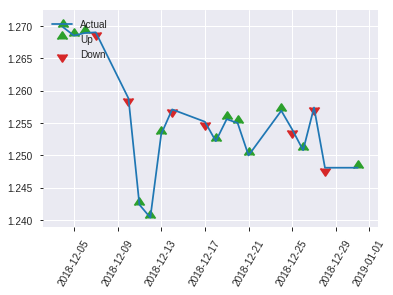


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.15839244904019567
RMSE: 0.39798548847941134
LogLoss: 0.4838459897708485
Null degrees of freedom: 255
Residual degrees of freedom: -764
Null deviance: 354.9579598113329
Residual deviance: 247.72914676267442
AIC: 2287.7291467626746
AUC: 0.8651026392961877
pr_auc: 0.8604469463858957
Gini: 0.7302052785923754
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4704974370301064: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      91   41   0.3106   (41.0/132.0)
1      18   106  0.1452   (18.0/124.0)
Total  109  147  0.2305   (59.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.470497     0.782288  146
max f2                       0.38195      0.875     183
max f0point5                 0.640788     0.81422   77
max accuracy                 0.531441     0.785156  116
max precision                0.955666     1         0
max recall                   0.0863853    1         247
max specificity              0.955666     1         0
max absolute_mcc             0.531441     0.570013  116
max min_per_class_accuracy   0.519152     0.774194  123
max mean_per_class_accuracy  0.525014     0.78458   120

Gains/Lift Table: Avg response rate: 48.44 %, avg score: 51.45 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.946362           2.06452   2.06452            1                0.952677   1                           0.952677            0.0241935       0.0241935                  106.452   106.452
    2        0.0234375                   0.943958           2.06452   2.06452            1                0.944808   1                           0.948742            0.0241935       0.0483871                  106.452   106.452
    3        0.03125                     0.938818           2.06452   2.06452            1                0.941286   1                           0.946878            0.016129        0.0645161                  106.452   106.452
    4        0.0429688                   0.93407            2.06452   2.06452            1                0.93693    1                           0.944165            0.0241935       0.0887097                  106.452   106.452
    5        0.0507812                   0.927308           2.06452   2.06452            1                0.930937   1                           0.94213             0.016129        0.104839                   106.452   106.452
    6        0.101562                    0.889657           2.06452   2.06452            1                0.915838   1                           0.928984            0.104839        0.209677                   106.452   106.452
    7        0.152344                    0.835694           1.7469    1.95864            0.846154         0.861662   0.948718                    0.906543            0.0887097       0.298387                   74.6898   95.8644
    8        0.203125                    0.784793           1.7469    1.90571            0.846154         0.806435   0.923077                    0.881516            0.0887097       0.387097                   74.6898   90.5707
    9        0.300781                    0.641298           1.81677   1.87683            0.88             0.685881   0.909091                    0.817998            0.177419        0.564516                   81.6774   87.6833
    10       0.402344                    0.55446            1.11166   1.68368            0.538462         0.593647   0.815534                    0.761366            0.112903        0.677419                   11.1663   68.3683
    11       0.5                         0.510595           1.07355   1.56452            0.52             0.531874   0.757812                    0.716543            0.104839        0.782258                   7.35484   56.4516
    12       0.601562                    0.457161           0.873449  1.44784            0.423077         0.482897   0.701299                    0.677096            0.0887097       0.870968                   -12.6551  44.7842
    13       0.699219                    0.391524           0.660645  1.3379             0.32             0.424177   0.648045                    0.641772            0.0645161       0.935484                   -33.9355  33.7899
    14       0.800781                    0.306731           0.317618  1.2085             0.153846         0.350958   0.585366                    0.604889            0.0322581       0.967742                   -68.2382  20.8497
    15       0.898438                    0.140179           0.165161  1.09509            0.08             0.212527   0.530435                    0.562241            0.016129        0.983871                   -83.4839  9.50912
    16       1                           0.033516           0.158809  1                  0.0769231        0.0921867  0.484375                   

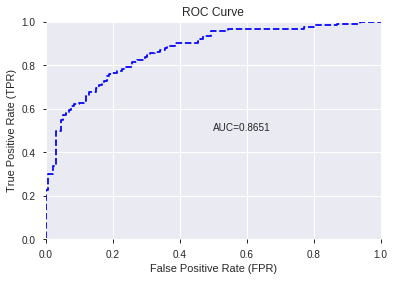

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


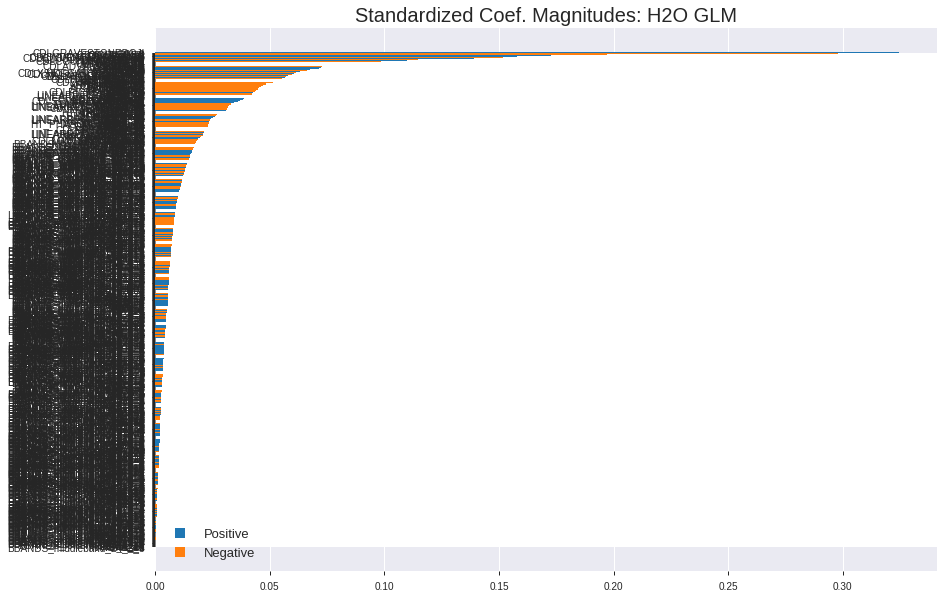

'log_likelihood'
--2019-08-22 12:49:32--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.184.211
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.184.211|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


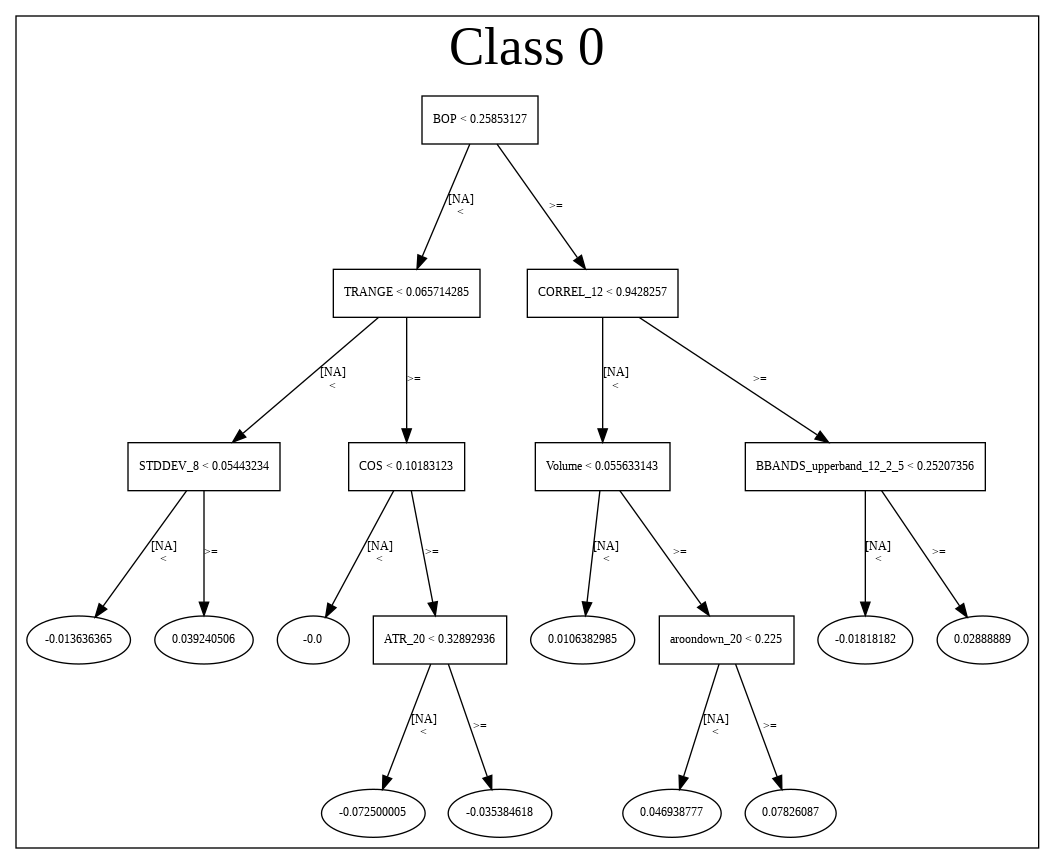

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190822_124803_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190822_124803_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_92dd',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

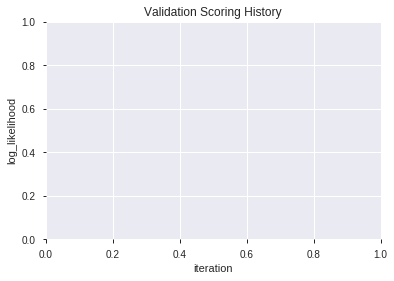

In [14]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [15]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [16]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [17]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190822_124942_model_2  0.841703  0.499787              0.237659  0.406719  0.165420
1               XGBoost_1_AutoML_20190822_124942  0.840420  0.498567              0.267595  0.408023  0.166482
2               XGBoost_2_AutoML_20190822_124942  0.836083  0.503923              0.240469  0.409847  0.167975
3  XGBoost_grid_1_AutoML_20190822_124942_model_6  0.835777  0.505206              0.226540  0.409566  0.167744
4               XGBoost_3_AutoML_20190822_124942  0.833089  0.503280              0.278715  0.410606  0.168597
5  XGBoost_grid_1_AutoML_20190822_124942_model_7  0.832722  0.511617              0.262219  0.414905  0.172146
6  XGBoost_grid_1_AutoML_20190822_124942_model_3  0.832661  0.504004              0.276149  0.410500  0.168510
7  XGBoost_grid_1_AutoML_20190822_124942_model_4  0.831928  0.517964              0.253421  0.415094  0.172303
8  XGBoost_grid_1_AutoML_20190822_124942_model_1  0.830401  0.506950              0.283480  0.411070  0.168978
9  XGBoost_grid_1_AutoML_20190822_124942_model_5  0.821725  0.517255              0.286779  0.417672  0.174450

variable  relative_importance  scaled_importance  percentage
0          CDLGRAVESTONEDOJI          1617.724854           1.000000    0.132099
1                  CDLTAKURI           857.088013           0.529811    0.069988
2               STOCHF_fastk           787.695374           0.486916    0.064321
3                      CCI_8           618.492737           0.382323    0.050504
4                     ULTOSC           424.942169           0.262679    0.034700
..                       ...                  ...                ...         ...
414  BBANDS_lowerband_20_0_2             0.366137           0.000226    0.000030
415  BBANDS_upperband_12_6_2             0.338511           0.000209    0.000028
416  BBANDS_upperband_20_7_3             0.321250           0.000199    0.000026
417   BBANDS_lowerband_8_4_5             0.138046           0.000085    0.000011
418   BBANDS_lowerband_8_1_5             0.101140           0.000063    0.000008

[419 rows x 4 columns]

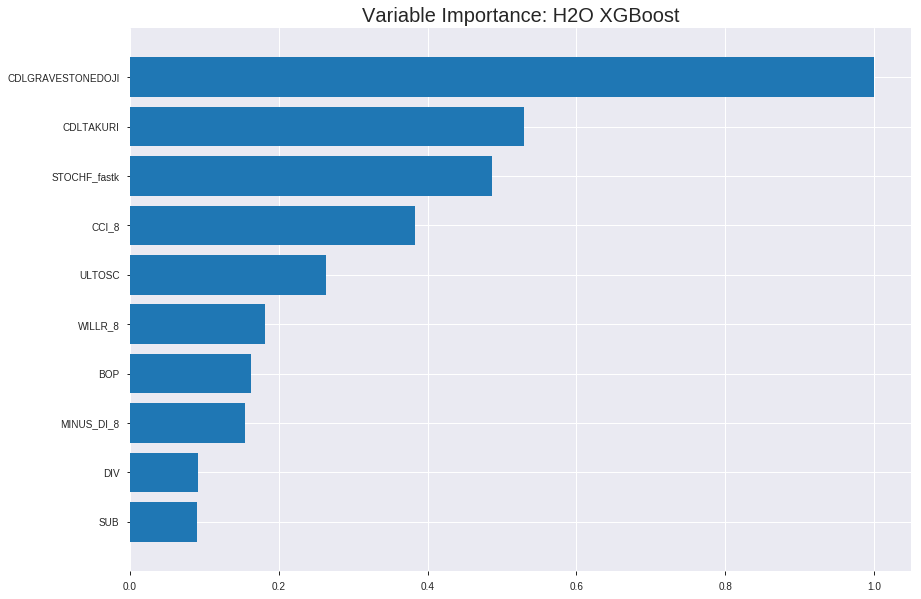

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190822_124942_model_2


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.11562181944629468
RMSE: 0.34003208590704304
LogLoss: 0.388449695268234
Mean Per-Class Error: 0.09968434106196677
AUC: 0.9601762429070685
pr_auc: 0.9598647911989918
Gini: 0.920352485814137
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4705596387386322: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      784  106  0.1191   (106.0/890.0)
1      72   825  0.0803   (72.0/897.0)
Total  856  931  0.0996   (178.0/1787.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.47056      0.902626  212
max f2                       0.423658     0.927411  235
max f0point5                 0.567245     0.909565  168
max accuracy                 0.47056      0.900392  212
max precision                0.961277     1         0
max recall                   0.214663     1         333
max specificity              0.961277     1         0
max absolute_mcc             0.47056      0.801331  212
max min_per_class_accuracy   0.487063     0.895506  205
max mean_per_class_accuracy  0.47056      0.900316  212

Gains/Lift Table: Avg response rate: 50.20 %, avg score: 50.01 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100727                   0.946965           1.9922     1.9922             1                0.952025  1                           0.952025            0.0200669       0.0200669                  99.2196   99.2196
    2        0.0201455                   0.941141           1.9922     1.9922             1                0.944174  1                           0.948099            0.0200669       0.0401338                  99.2196   99.2196
    3        0.0302182                   0.93497            1.9922     1.9922             1                0.938365  1                           0.944854            0.0200669       0.0602007                  99.2196   99.2196
    4        0.040291                    0.928704           1.9922     1.9922             1                0.93211   1                           0.941668            0.0200669       0.0802676                  99.2196   99.2196
    5        0.0503637                   0.922049           1.9922     1.9922             1                0.925225  1                           0.93838             0.0200669       0.100334                   99.2196   99.2196
    6        0.100168                    0.871097           1.9922     1.9922             1                0.903827  1                           0.9212              0.0992196       0.199554                   99.2196   99.2196
    7        0.149972                    0.802839           1.96981    1.98476            0.988764         0.83901   0.996269                    0.893905            0.0981048       0.297659                   96.9812   98.4763
    8        0.200336                    0.748666           1.9922     1.98663            1                0.773745  0.997207                    0.863698            0.100334        0.397993                   99.2196   98.6631
    9        0.299944                    0.652256           1.88028    1.95131            0.94382          0.69607   0.979478                    0.80803             0.187291        0.585284                   88.0275   95.1312
    10       0.400112                    0.574253           1.75847    1.90303            0.882682         0.615121  0.955245                    0.759735            0.176143        0.761427                   75.8475   90.3035
    11       0.50028                     0.487582           1.32442    1.78718            0.664804         0.529899  0.897092                    0.713717            0.132664        0.894091                   32.4421   78.7183
    12       0.599888                    0.404536           0.682719   1.60379            0.342697         0.444643  0.805037                    0.669038            0.0680045       0.962096                   -31.7281  60.3792
    13       0.700056                    0.336369           0.211462   1.40457            0.106145         0.367417  0.705036                    0.625881            0.0211817       0.983278                   -78.8538  40.457
    14       0.799664                    0.264203           0.0895369  1.24077            0.0449438        0.302406  0.622813                    0.585588            0.00891862      0.992196                   -91.0463  24.0766
    15       0.899832                    0.15227            0.0779071  1.11132            0.0391061        0.210818  0.557836                    0.543869            0.00780379      1                          -92.2093  11.1318
    16       1                           0.0444966          0          1                  0                0.107091  0.501959                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.16941515212411376
RMSE: 0.41160071929494213
LogLoss: 0.5079712080632854
Mean Per-Class Error: 0.24561646363971945
AUC: 0.8308877814691769
pr_auc: 0.8271061339104487
Gini: 0.6617755629383537
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3690054416656494: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      149  103  0.4087   (103.0/252.0)
1      25   233  0.0969   (25.0/258.0)
Total  174  336  0.251    (128.0/510.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.369005     0.784512  262
max f2                       0.241039     0.876039  320
max f0point5                 0.51873      0.761421  184
max accuracy                 0.441619     0.754902  219
max precision                0.944076     1         0
max recall                   0.146322     1         360
max specificity              0.944076     1         0
max absolute_mcc             0.369005     0.521337  262
max min_per_class_accuracy   0.475558     0.736434  203
max mean_per_class_accuracy  0.441619     0.754384  219

Gains/Lift Table: Avg response rate: 50.59 %, avg score: 49.66 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117647                   0.934142           1.97674    1.97674            1                0.938037  1                           0.938037            0.0232558       0.0232558                  97.6744   97.6744
    2        0.0215686                   0.926192           1.97674    1.97674            1                0.92831   1                           0.933616            0.0193798       0.0426357                  97.6744   97.6744
    3        0.0313725                   0.918238           1.97674    1.97674            1                0.922019  1                           0.929992            0.0193798       0.0620155                  97.6744   97.6744
    4        0.0411765                   0.912725           1.97674    1.97674            1                0.916067  1                           0.926676            0.0193798       0.0813953                  97.6744   97.6744
    5        0.0509804                   0.907395           1.97674    1.97674            1                0.909775  1                           0.923426            0.0193798       0.100775                   97.6744   97.6744
    6        0.1                         0.868685           1.73953    1.86047            0.88             0.890974  0.941176                    0.907518            0.0852713       0.186047                   73.9535   86.0465
    7        0.15098                     0.812395           1.74866    1.82271            0.884615         0.835983  0.922078                    0.883363            0.0891473       0.275194                   74.8658   82.2712
    8        0.2                         0.759704           1.66047    1.78295            0.84             0.786544  0.901961                    0.859633            0.0813953       0.356589                   66.0465   78.2946
    9        0.3                         0.647668           1.31783    1.62791            0.666667         0.702461  0.823529                    0.807242            0.131783        0.488372                   31.7829   62.7907
    10       0.4                         0.558254           1.31783    1.55039            0.666667         0.603701  0.784314                    0.756357            0.131783        0.620155                   31.7829   55.0388
    11       0.5                         0.473705           1.16279    1.47287            0.588235         0.519781  0.745098                    0.709042            0.116279        0.736434                   16.2791   47.2868
    12       0.6                         0.416589           0.930233   1.38243            0.470588         0.443356  0.699346                    0.664761            0.0930233       0.829457                   -6.97674  38.2429
    13       0.7                         0.343828           0.891473   1.31229            0.45098          0.377905  0.663866                    0.623781            0.0891473       0.918605                   -10.8527  31.2292
    14       0.8                         0.2491             0.542636   1.21609            0.27451          0.293746  0.615196                    0.582527            0.0542636       0.972868                   -45.7364  21.6085
    15       0.9                         0.147329           0.232558   1.1068             0.117647         0.194778  0.559913                    0.539444            0.0232558       0.996124                   -76.7442  10.6804
    16       1                           0.0577361          0.0387597  1                  0.0196078        0.110731  0.505882                   


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 12:50:13  5.138 sec   0                  0.5              0.693147            0.5             0                  1                0.498041                         0.5                0.693147              0.5               0                    1                  0.494118
    2019-08-22 12:50:14  6.273 sec   5                  0.477579         0.64904             0.825042        0.652325           1.95683          0.290431                         0.477363           0.648606              0.800241          0.625817             1.82171            0.258824
    2019-08-22 12:50:15  6.525 sec   10                 0.460755         0.616276            0.838306        0.677751           1.97934          0.261332                         0.460805           0.616252              0.809085          0.658245             1.92968            0.272549
    2019-08-22 12:50:15  6.774 sec   15                 0.447137         0.58957             0.851682        0.708551           1.97786          0.253497                         0.449794           0.594447              0.812546          0.789038             1.64729            0.25098
    2019-08-22 12:50:15  7.019 sec   20                 0.436668         0.568715            0.860952        0.778134           1.9922           0.231114                         0.441719           0.577998              0.816691          0.803656             1.64729            0.25098
    2019-08-22 12:50:15  7.275 sec   25                 0.428162         0.551307            0.86569         0.78418            1.9922           0.233352                         0.435588           0.565019              0.816807          0.80282              1.64729            0.258824
    2019-08-22 12:50:16  7.543 sec   30                 0.419587         0.534091            0.873671        0.795876           1.9922           0.213766                         0.429829           0.552554              0.819567          0.805379             1.64729            0.272549
    2019-08-22 12:50:16  7.808 sec   35                 0.412522         0.51977             0.881327        0.848238           1.9922           0.205932                         0.426645           0.545138              0.820175          0.813203             1.64729            0.268627
    2019-08-22 12:50:16  8.084 sec   40                 0.406254         0.507055            0.888021        0.893676           1.9922           0.191942                         0.422942           0.536755              0.82329           0.815939             1.64729            0.268627
    2019-08-22 12:50:17  8.362 sec   45                 0.399626         0.494038            0.896751        0.901742           1.9922           0.185227                         0.420558           0.530768              0.823597          0.817864             1.64729            0.260784
    2019-08-22 12:50:17  8.628 sec   50                 0.394145         0.48311             0.902454        0.904565           1.9922           0.172356                         0.418386           0.525813              0.825997          0.822185             1.97674            0.262745
    2019-08-22 12:50:17  8.899 sec   55                 0.387876         0.471193            0.909713        0.913234           1.9922           0.18075                          0.4172             0.522873              0.826712          0.8

Variable Importances: 


variable                 relative_importance    scaled_importance       percentage
-----------------------  ---------------------  ----------------------  ----------------------
CDLGRAVESTONEDOJI        1617.724853515625      1.0                     0.13209909228282443
CDLTAKURI                857.0880126953125      0.5298107467612286      0.06998751872884366
STOCHF_fastk             787.6953735351562      0.48691554180140323     0.06432110109036503
CCI_8                    618.4927368164062      0.3823225782012951      0.05050446553962024
ULTOSC                   424.9421691894531      0.2626788902117518      0.03469964295883211
---                      ---                    ---                     ---
BBANDS_lowerband_20_0_2  0.36613690853118896    0.00022632829540542915  2.9897762380976134e-05
BBANDS_upperband_12_6_2  0.33851107954978943    0.00020925133146971206  2.7641910946121377e-05
BBANDS_upperband_20_7_3  0.3212502896785736     0.00019858153812772017  2.6232440930798925e-05
BBANDS_lowerband_8_4_5   0.13804644346237183    8.533369760770538e-05   1.1272503995114907e-05
BBANDS_lowerband_8_1_5   0.10113975405693054    6.251975039954078e-05   8.258802277528087e-06


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.765625)

('F1', 0.7607843137254903)

('auc', 0.8417033235581624)

('logloss', 0.4997866986722681)

('mean_per_class_error', 0.23582600195503423)

('rmse', 0.4067191295657908)

('mse', 0.16542045035475453)

xgboost prediction progress: |████████████████████████████████████████████| 100%


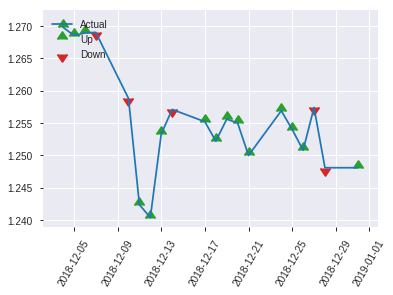


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.16542045035475453
RMSE: 0.4067191295657908
LogLoss: 0.4997866986722681
Mean Per-Class Error: 0.23582600195503423
AUC: 0.8417033235581624
pr_auc: 0.833336552377007
Gini: 0.6834066471163247
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5272555947303772: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      98   34   0.2576   (34.0/132.0)
1      27   97   0.2177   (27.0/124.0)
Total  125  131  0.2383   (61.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.527256     0.760784  130
max f2                       0.291267     0.868006  200
max f0point5                 0.645304     0.79      93
max accuracy                 0.645304     0.765625  93
max precision                0.942297     1         0
max recall                   0.143588     1         235
max specificity              0.942297     1         0
max absolute_mcc             0.645304     0.5427    93
max min_per_class_accuracy   0.537081     0.75      125
max mean_per_class_accuracy  0.566111     0.764174  113

Gains/Lift Table: Avg response rate: 48.44 %, avg score: 52.39 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0117188                   0.935325           2.06452    2.06452            1                0.937952  1                           0.937952            0.0241935       0.0241935                  106.452    106.452
    2        0.0234375                   0.930016           2.06452    2.06452            1                0.932257  1                           0.935105            0.0241935       0.0483871                  106.452    106.452
    3        0.03125                     0.919048           2.06452    2.06452            1                0.926019  1                           0.932833            0.016129        0.0645161                  106.452    106.452
    4        0.0429688                   0.914818           2.06452    2.06452            1                0.916261  1                           0.928313            0.0241935       0.0887097                  106.452    106.452
    5        0.0507812                   0.911628           2.06452    2.06452            1                0.912551  1                           0.925889            0.016129        0.104839                   106.452    106.452
    6        0.101562                    0.870933           1.90571    1.98511            0.923077         0.897516  0.961538                    0.911702            0.0967742       0.201613                   90.5707    98.5112
    7        0.152344                    0.842437           2.06452    2.01158            1                0.858614  0.974359                    0.894006            0.104839        0.306452                   106.452    101.158
    8        0.203125                    0.773792           1.42928    1.866              0.692308         0.815605  0.903846                    0.874406            0.0725806       0.379032                   42.928     86.6005
    9        0.300781                    0.685684           1.65161    1.7964             0.8              0.720563  0.87013                     0.824457            0.16129         0.540323                   65.1613    79.6397
    10       0.402344                    0.581353           1.27047    1.66364            0.615385         0.644536  0.805825                    0.77904             0.129032        0.669355                   27.0471    66.3639
    11       0.5                         0.531345           0.990968   1.53226            0.48             0.558817  0.742188                    0.736028            0.0967742       0.766129                   -0.903226  53.2258
    12       0.601562                    0.450242           0.635236   1.38081            0.307692         0.488976  0.668831                    0.694318            0.0645161       0.830645                   -36.4764   38.0813
    13       0.699219                    0.372971           0.825806   1.3033             0.4              0.414336  0.631285                    0.655214            0.0806452       0.91129                    -17.4194   30.3298
    14       0.800781                    0.276712           0.635236   1.21857            0.307692         0.319232  0.590244                    0.612602            0.0645161       0.975806                   -36.4764   21.8568
    15       0.898438                    0.162409           0.0825806  1.09509            0.04             0.210252  0.530435                    0.568868            0.00806452      0.983871                   -91.7419   9.50912
    16       1                           0.0693407          0.158809   1                  0.0769231        0.12592   0.484375  

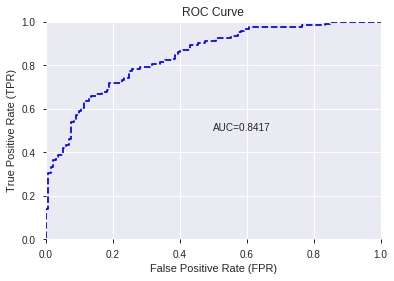

This function is available for GLM models only


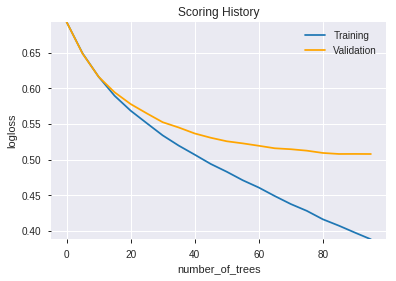

--2019-08-22 12:51:10--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.170.251
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.170.251|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.calculateChildInclusiveNa(Sha

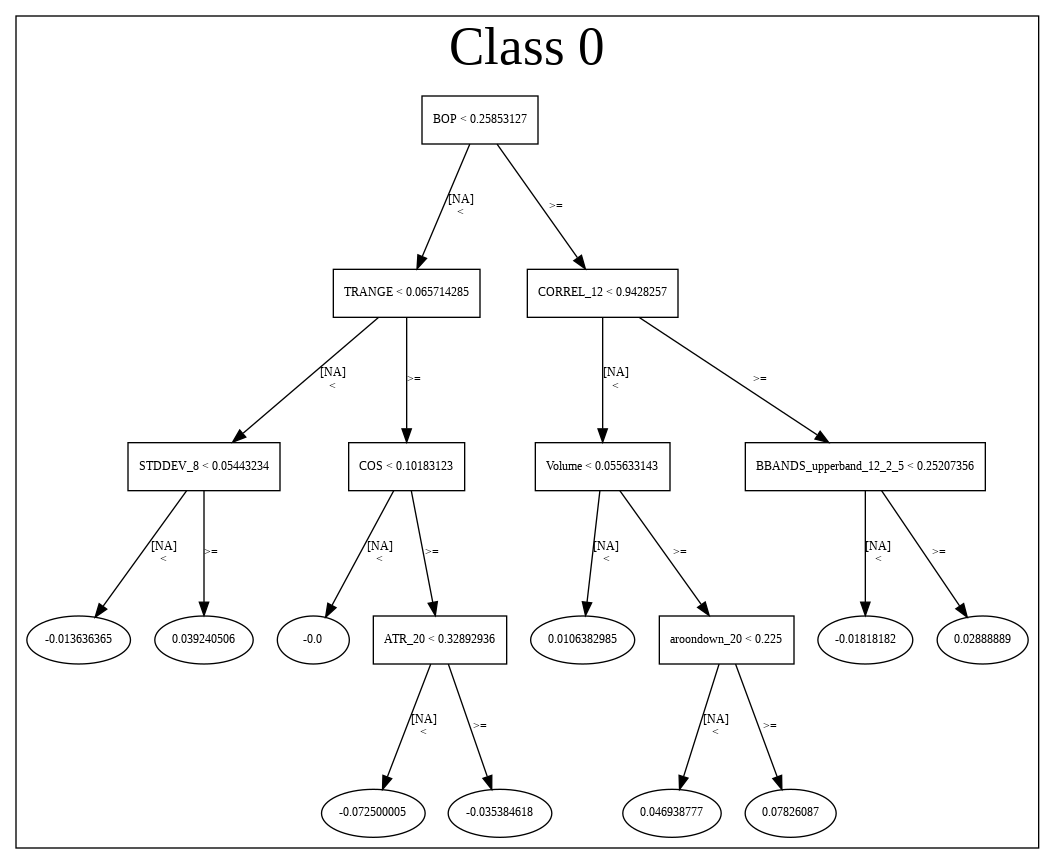

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190822_124942_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190822_124942_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_92dd',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

In [18]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190822_125118_model_5  0.850684  0.496027              0.235459  0.405416  0.164362
1  DeepLearning_grid_1_AutoML_20190822_125118_model_7  0.849462  0.542654              0.269917  0.419231  0.175754
2  DeepLearning_grid_1_AutoML_20190822_125118_model_9  0.843475  0.488071              0.241813  0.402411  0.161934
3  DeepLearning_grid_1_AutoML_20190822_125118_model_6  0.842864  0.503727              0.234726  0.408898  0.167198
4               DeepLearning_1_AutoML_20190822_125118  0.841764  0.476635              0.292400  0.400463  0.160371
5  DeepLearning_grid_1_AutoML_20190822_125118_model_8  0.831928  0.512396              0.264785  0.413891  0.171306
6  DeepLearning_grid_1_AutoML_20190822_125118_model_3  0.786962  0.550457              0.320870  0.434117  0.188458
7  DeepLearning_grid_1_AutoML_20190822_125118_model_4  0.768328  0.682349              0.351417  0.473878  0.224561
8  DeepLearning_grid_1_AutoML_20190822_125118_model_1  0.740042  0.623733              0.318426  0.462380  0.213796
9  DeepLearning_grid_1_AutoML_20190822_125118_model_2  0.699413  0.625497              0.425464  0.469811  0.220722

variable  relative_importance  scaled_importance  percentage
0              CDLDOJI             1.000000           1.000000    0.036278
1    CDLLONGLEGGEDDOJI             0.943514           0.943514    0.034229
2                  DIV             0.862840           0.862840    0.031302
3       CDLRICKSHAWMAN             0.849919           0.849919    0.030833
4         STOCHF_fastk             0.793363           0.793363    0.028782
5               ULTOSC             0.768047           0.768047    0.027863
6                  SUB             0.746719           0.746719    0.027089
7                  TAN             0.692078           0.692078    0.025107
8    CDLGRAVESTONEDOJI             0.681331           0.681331    0.024717
9                CCI_8             0.665144           0.665144    0.024130
10  CDLCLOSINGMARUBOZU             0.619237           0.619237    0.022465
11              TRANGE             0.615732           0.615732    0.022338
12        HT_TRENDMODE             0.597502           0.597502    0.021676
13                 SIN             0.578229           0.578229    0.020977
14   CDLINVERTEDHAMMER             0.574654           0.574654    0.020847
15             WILLR_8             0.574549           0.574549    0.020843
16              SAREXT             0.574121           0.574121    0.020828
17           CDLTAKURI             0.566546           0.566546    0.020553
18            WILLR_14             0.553795           0.553795    0.020091
19             BETA_30             0.547539           0.547539    0.019864
20                 day             0.547133           0.547133    0.019849
21         MINUS_DM_24             0.521849           0.521849    0.018932
22    CDLDRAGONFLYDOJI             0.512431           0.512431    0.018590
23              CCI_12             0.505903           0.505903    0.018353
24           CORREL_12             0.502651           0.502651    0.018235
25      STOCHRSI_fastk             0.501762           0.501762    0.018203
26         CDLBELTHOLD             0.500412           0.500412    0.018154
27               ROC_8             0.491916           0.491916    0.017846
28            WILLR_12             0.486924           0.486924    0.017665
29             BETA_12             0.483454           0.483454    0.017539
30              ROCR_8             0.477835           0.477835    0.017335
31               MOM_8             0.476014           0.476014    0.017269
32           PLUS_DI_8             0.472918           0.472918    0.017157
33       days_in_month             0.472423           0.472423    0.017139
34           PLUS_DM_8             0.468213           0.468213    0.016986
35          MINUS_DI_8             0.463242           0.463242    0.016805
36             BETA_14             0.460182           0.460182    0.016694
37          MINUS_DM_8             0.458944           0.458944    0.016650
38          PLUS_DM_12             0.454828           0.454828    0.016500
39              CCI_14             0.447864           0.447864    0.016248
40          PLUS_DI_14             0.434871           0.434871    0.015776
41       CDLHANGINGMAN             0.425460           0.425460    0.015435
42         MINUS_DI_14             0.418530           0.418530    0.015183
43         MINUS_DI_12             0.416539           0.416539    0.015111
44              CCI_30             0.397848           0.397848    0.014433
45      is_month_start             0.397785           0.397785    0.014431
46           CDLHAMMER             0.392922           0.392922    0.014254
47     CDLSHOOTINGSTAR             0.391781           0.391781    0.014213
48              CCI_20             0.390230           0.390230    0.014157
49              CCI_24             0.387209           0.387209    0.014047

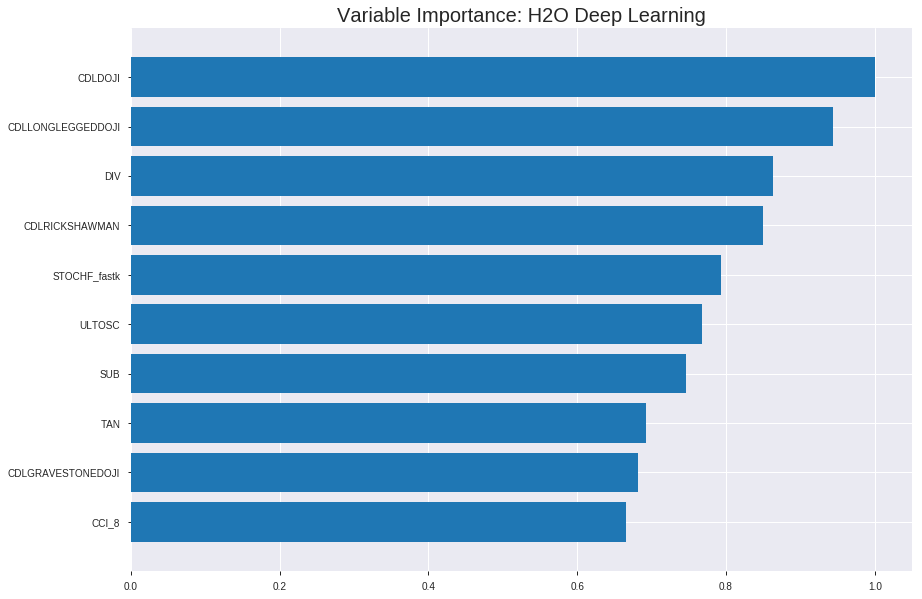

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190822_125118_model_5


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.1570688931843295
RMSE: 0.3963191809442605
LogLoss: 0.46530424755888944
Mean Per-Class Error: 0.2425131211403806
AUC: 0.8582653789786179
pr_auc: 0.8646028163027815
Gini: 0.7165307579572358
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4326612227715949: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      516  374   0.4202   (374.0/890.0)
1      88   809   0.0981   (88.0/897.0)
Total  604  1183  0.2585   (462.0/1787.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.432661     0.777885  229
max f2                       0.322334     0.880112  278
max f0point5                 0.5593       0.78747   147
max accuracy                 0.480975     0.757694  203
max precision                0.999651     1         0
max recall                   0.100834     1         357
max specificity              0.999651     1         0
max absolute_mcc             0.470663     0.522002  210
max min_per_class_accuracy   0.490632     0.749164  193
max mean_per_class_accuracy  0.480975     0.757487  203

Gains/Lift Table: Avg response rate: 50.20 %, avg score: 50.02 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100727                   0.995224           1.9922     1.9922             1                0.997522   1                           0.997522            0.0200669       0.0200669                  99.2196   99.2196
    2        0.0201455                   0.992794           1.9922     1.9922             1                0.993984   1                           0.995753            0.0200669       0.0401338                  99.2196   99.2196
    3        0.0302182                   0.989685           1.9922     1.9922             1                0.991316   1                           0.994274            0.0200669       0.0602007                  99.2196   99.2196
    4        0.040291                    0.984347           1.9922     1.9922             1                0.987076   1                           0.992474            0.0200669       0.0802676                  99.2196   99.2196
    5        0.0503637                   0.979721           1.9922     1.9922             1                0.981615   1                           0.990302            0.0200669       0.100334                   99.2196   99.2196
    6        0.100168                    0.939558           1.9922     1.9922             1                0.964534   1                           0.97749             0.0992196       0.199554                   99.2196   99.2196
    7        0.149972                    0.872373           1.96981    1.98476            0.988764         0.909159   0.996269                    0.954798            0.0981048       0.297659                   96.9812   98.4763
    8        0.200336                    0.715254           1.72657    1.91985            0.866667         0.798286   0.963687                    0.915451            0.0869565       0.384615                   72.657    91.9854
    9        0.299944                    0.540742           1.46617    1.76919            0.735955         0.605061   0.88806                     0.812374            0.146042        0.530658                   46.6167   76.9189
    10       0.400112                    0.505394           1.19087    1.62441            0.597765         0.519336   0.815385                    0.739012            0.119287        0.649944                   19.0866   62.4406
    11       0.50028                     0.489295           1.02392    1.50417            0.513966         0.496569   0.755034                    0.690469            0.102564        0.752508                   2.39221   50.4175
    12       0.599888                    0.463709           0.973714   1.41609            0.488764         0.479397   0.710821                    0.655422            0.09699         0.849498                   -2.62861  41.6095
    13       0.700056                    0.399378           0.745682   1.32017            0.374302         0.437264   0.66267                     0.624207            0.0746934       0.924192                   -25.4318  32.0168
    14       0.799664                    0.302433           0.593182   1.22961            0.297753         0.353752   0.617215                    0.590518            0.0590858       0.983278                   -40.6818  22.9613
    15       0.899832                    0.134535           0.155814   1.11008            0.0782123        0.222643   0.557214                    0.549567            0.0156076       0.998885                   -84.4186  11.0079
    16       1                           1.02336e-07        0.0111296  1                  0.00558659       0.0566891  0.501959 



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.17635893759916202
RMSE: 0.4199511133443535
LogLoss: 0.5215300334561932
Mean Per-Class Error: 0.2642580287929125
AUC: 0.8163759689922481
pr_auc: 0.819616780956711
Gini: 0.6327519379844961
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3787848133038095: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      125  127  0.504    (127.0/252.0)
1      24   234  0.093    (24.0/258.0)
Total  149  361  0.2961   (151.0/510.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.378785     0.756058  274
max f2                       0.243655     0.875687  325
max f0point5                 0.482077     0.749567  177
max accuracy                 0.475378     0.735294  187
max precision                0.999531     1         0
max recall                   0.125092     1         366
max specificity              0.999531     1         0
max absolute_mcc             0.475378     0.47263   187
max min_per_class_accuracy   0.463615     0.72619   198
max mean_per_class_accuracy  0.475378     0.735742  187

Gains/Lift Table: Avg response rate: 50.59 %, avg score: 50.43 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117647                   0.996306           1.97674    1.97674            1                0.997852   1                           0.997852            0.0232558       0.0232558                  97.6744   97.6744
    2        0.0215686                   0.994643           1.97674    1.97674            1                0.995555   1                           0.996808            0.0193798       0.0426357                  97.6744   97.6744
    3        0.0313725                   0.99338            1.97674    1.97674            1                0.994009   1                           0.995933            0.0193798       0.0620155                  97.6744   97.6744
    4        0.0411765                   0.989734           1.97674    1.97674            1                0.991781   1                           0.994944            0.0193798       0.0813953                  97.6744   97.6744
    5        0.0509804                   0.984395           1.97674    1.97674            1                0.986164   1                           0.993256            0.0193798       0.100775                   97.6744   97.6744
    6        0.1                         0.964989           1.8186     1.89922            0.92             0.976141   0.960784                    0.984866            0.0891473       0.189922                   81.8605   89.9225
    7        0.15098                     0.927592           1.74866    1.84838            0.884615         0.950765   0.935065                    0.973352            0.0891473       0.27907                    74.8658   84.8384
    8        0.2                         0.792717           1.5814     1.78295            0.8              0.865907   0.901961                    0.947017            0.0775194       0.356589                   58.1395   78.2946
    9        0.3                         0.545864           1.35659    1.64083            0.686275         0.657996   0.830065                    0.850677            0.135659        0.492248                   35.6589   64.0827
    10       0.4                         0.494159           1.27907    1.55039            0.647059         0.513658   0.784314                    0.766422            0.127907        0.620155                   27.907    55.0388
    11       0.5                         0.465661           1.04651    1.44961            0.529412         0.478656   0.733333                    0.708869            0.104651        0.724806                   4.65116   44.9612
    12       0.6                         0.429613           0.930233   1.36305            0.470588         0.447726   0.689542                    0.665345            0.0930233       0.817829                   -6.97674  36.3049
    13       0.7                         0.38102            0.775194   1.27907            0.392157         0.405706   0.647059                    0.628254            0.0775194       0.895349                   -22.4806  27.907
    14       0.8                         0.290406           0.697674   1.2064             0.352941         0.345612   0.610294                    0.592924            0.0697674       0.965116                   -30.2326  20.6395
    15       0.9                         0.138186           0.271318   1.1025             0.137255         0.220693   0.557734                    0.551565            0.0271318       0.992248                   -72.8682  10.2498
    16       1                           3.06433e-05        0.0775194  1                  0.0392157        0.0791874  0.505882  


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 12:54:31  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-22 12:54:33  1 min 20.868 sec  1134 obs/sec      0.956911  1             1710       0.444254         0.574987            0.210542       0.768273        0.777207           1.9922           0.362619                         0.440116           0.569718              0.225085         0.784345          0.780387             1.64729            0.305882
    2019-08-22 12:54:39  1 min 26.815 sec  1988 obs/sec      7.68215   8             13728      0.41447          0.506156            0.312847       0.820375        0.828988           1.9922           0.289871                         0.423763           0.533008              0.2816           0.808716          0.810482             1.97674            0.290196
    2019-08-22 12:54:45  1 min 32.453 sec  2294 obs/sec      15.3867   16            27496      0.411841         0.494174            0.321538       0.838844        0.850039           1.9922           0.279799                         0.423866           0.52406               0.28125          0.813331          0.816406             1.97674            0.292157
    2019-08-22 12:54:51  1 min 38.482 sec  2464 obs/sec      24.0789   25            43029      0.396319         0.465304            0.371715       0.858265        0.864603           1.9922           0.258534                         0.419951           0.52153               0.294467         0.816376          0.819617             1.97674            0.296078
    2019-08-22 12:54:56  1 min 44.323 sec  2576 obs/sec      32.7336   34            58495      0.388677         0.444926            0.395712       0.866993        0.86727            1.9922           0.241746                         0.432614           0.544876              0.251277         0.79885           0.79897              1.97674            0.284314
    2019-08-22 12:55:03  1 min 50.588 sec  2676 obs/sec      42.3486   44            75677      0.387987         0.438997            0.397855       0.886683        0.8818             1.9922           0.229435                         0.441209           0.564521              0.22123          0.802818          0.802661             1.97674            0.327451
    2019-08-22 12:55:10  1 min 57.735 sec  2763 obs/sec      53.8993   56            96318      0.36956          0.40378             0.453694       0.89288         0.876804           1.9922           0.217683                         0.435462           0.575387              0.241385         0.788068          0.78413              1.97674            0.335294
    2019-08-22 12:55:10  1 min 58.309 sec  2761 obs/sec      53.8993   56            96318      0.396319         0.465304            0.371715       0.858265        0.864603           1.9922           0.258534                         0.419951           0.52153               0.294467         0.816376          0.819617             1.97674            0.296078

Variable Importances: 


variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  --------------------
CDLDOJI            1.0                    1.0                  0.03627798131277711
CDLLONGLEGGEDDOJI  0.943514347076416      0.943514347076416    0.03422879585157532
DIV                0.8628402352333069     0.8628402352333069   0.031302101929706116
CDLRICKSHAWMAN     0.8499186038970947     0.8499186038970947   0.030833331229560414
STOCHF_fastk       0.7933626770973206     0.7933626770973206   0.028781596373991417
---                ---                    ---                  ---
is_month_start     0.3977845311164856     0.3977845311164856   0.01443081978635567
CDLHAMMER          0.3929215967655182     0.3929215967655182   0.014254402344846012
CDLSHOOTINGSTAR    0.39178064465522766    0.39178064465522766  0.01421301090551012
CCI_20             0.39022964239120483    0.39022964239120483  0.014156743674359824
CCI_24             0.3872091770172119     0.3872091770172119   0.01404716728796622


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.765625)

('F1', 0.7765567765567765)

('auc', 0.8506842619745846)

('logloss', 0.4960269812154199)

('mean_per_class_error', 0.23545943304007821)

('rmse', 0.40541567999789047)

('mse', 0.1643618735881519)

deeplearning prediction progress: |███████████████████████████████████████| 100%


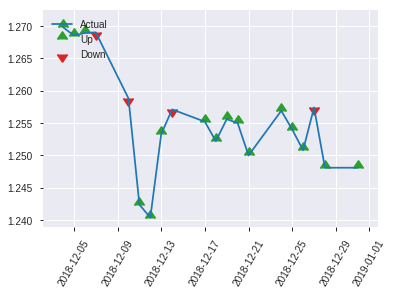


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.1643618735881519
RMSE: 0.40541567999789047
LogLoss: 0.4960269812154199
Mean Per-Class Error: 0.23545943304007821
AUC: 0.8506842619745846
pr_auc: 0.8368129353707636
Gini: 0.7013685239491692
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.43827514908427717: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      89   43   0.3258   (43.0/132.0)
1      18   106  0.1452   (18.0/124.0)
Total  107  149  0.2383   (61.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.438275     0.776557  148
max f2                       0.387457     0.872781  179
max f0point5                 0.51         0.787402  95
max accuracy                 0.51         0.765625  95
max precision                0.998653     1         0
max recall                   0.108356     1         243
max specificity              0.998653     1         0
max absolute_mcc             0.51         0.540868  95
max min_per_class_accuracy   0.473413     0.75      125
max mean_per_class_accuracy  0.438275     0.764541  148

Gains/Lift Table: Avg response rate: 48.44 %, avg score: 52.15 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0117188                   0.997857           2.06452    2.06452            1                0.998428   1                           0.998428            0.0241935       0.0241935                  106.452    106.452
    2        0.0234375                   0.995568           2.06452    2.06452            1                0.996476   1                           0.997452            0.0241935       0.0483871                  106.452    106.452
    3        0.03125                     0.99416            2.06452    2.06452            1                0.995229   1                           0.996896            0.016129        0.0645161                  106.452    106.452
    4        0.0429688                   0.991004           2.06452    2.06452            1                0.992284   1                           0.995639            0.0241935       0.0887097                  106.452    106.452
    5        0.0507812                   0.988675           2.06452    2.06452            1                0.990287   1                           0.994815            0.016129        0.104839                   106.452    106.452
    6        0.101562                    0.968884           1.90571    1.98511            0.923077         0.980641   0.961538                    0.987728            0.0967742       0.201613                   90.5707    98.5112
    7        0.152344                    0.933892           1.90571    1.95864            0.923077         0.950555   0.948718                    0.975337            0.0967742       0.298387                   90.5707    95.8644
    8        0.203125                    0.817718           1.58809    1.866              0.769231         0.887883   0.903846                    0.953473            0.0806452       0.379032                   58.8089    86.6005
    9        0.300781                    0.610922           1.56903    1.76959            0.76             0.705801   0.857143                    0.87306             0.153226        0.532258                   56.9032    76.9585
    10       0.402344                    0.504716           1.27047    1.6436             0.615385         0.53462    0.796117                    0.787629            0.129032        0.66129                    27.0471    64.3595
    11       0.5                         0.469357           0.990968   1.51613            0.48             0.485664   0.734375                    0.728651            0.0967742       0.758065                   -0.903226  51.6129
    12       0.601562                    0.423428           0.952854   1.42103            0.461538         0.451219   0.688312                    0.681812            0.0967742       0.854839                   -4.71464   42.1031
    13       0.699219                    0.387465           0.908387   1.34943            0.44             0.404209   0.653631                    0.643041            0.0887097       0.943548                   -9.16129   34.9432
    14       0.800781                    0.327441           0.238213   1.2085             0.115385         0.360725   0.585366                    0.607235            0.0241935       0.967742                   -76.1787   20.8497
    15       0.898438                    0.169203           0.247742   1.10407            0.12             0.25756    0.534783                    0.569227            0.0241935       0.991935                   -75.2258   10.4067
    16       1                           0.00463915         0.0794045  1                  0.0384615        0.0

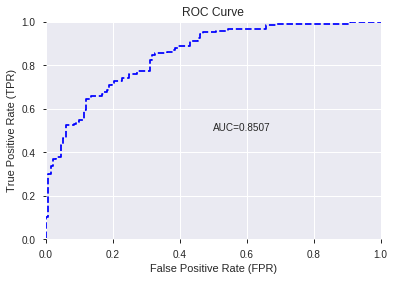

This function is available for GLM models only


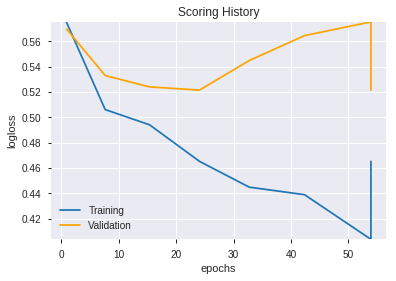

--2019-08-22 12:59:30--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.81.192
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.81.192|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


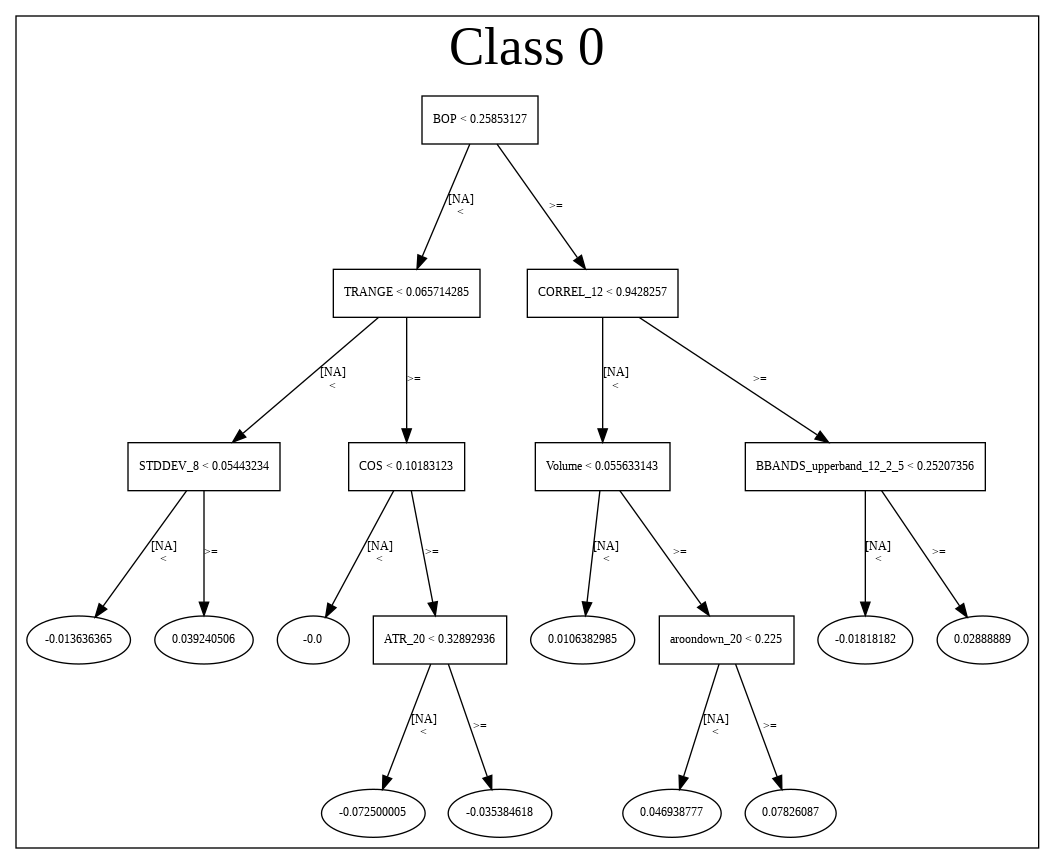

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190822_125118_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190822_125118_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_92dd',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLDOJI',
 'CDLLONGLEGGEDDOJI',
 'DIV',
 'CDLRICKSHAWMAN',
 'STOCHF_fastk',
 'ULTOSC',
 'SUB',
 'TAN',
 'CDLGRAVESTONEDOJI',
 'CCI_8',
 'CDLCLOSINGMARUBOZU',
 'TRANGE',
 'HT_TRENDMODE',
 'SIN',
 'CDLINVERTEDHAMMER',
 'WILLR_8',
 'SAREXT',
 'CDLTAKURI',
 'WILLR_14',
 'BETA_30',
 'day',
 'MINUS_DM_24',
 'CDLDRAGONFLYDOJI',
 'CCI_12',
 'CORREL_12',
 'STOCHRSI_fastk',
 'CDLBELTHOLD',
 'ROC_8',
 'WILLR_12',
 'BETA_12',
 'ROCR_8',
 'MOM_8',
 'PLUS_DI_8',
 'days_in_month',
 'PLUS_DM_8',
 'MINUS_DI_8',
 'BETA_14',
 'MINUS_DM_8',
 'PLUS_DM_12',
 'CCI_14',
 'PLUS_DI_14',
 'CDLHANGINGMAN',
 'MINUS_DI_14',
 'MINUS_DI_12',
 'CCI_30',
 'is_month_start',
 'CDLHAMMER',
 'CDLSHOOTINGSTAR',
 'CCI_20',
 'CCI_24']

In [19]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190822_125941_model_1  0.867485  0.455998              0.237292  0.387339  0.150031

variable  relative_importance  scaled_importance  percentage
0                CCI_8             0.960475           1.000000    0.096418
1            CDLTAKURI             0.779734           0.811821    0.078274
2         STOCHF_fastk             0.772944           0.804752    0.077592
3           MINUS_DI_8             0.757307           0.788472    0.076023
4             WILLR_14             0.516873           0.538143    0.051886
5    CDLGRAVESTONEDOJI             0.496065           0.516479    0.049798
6              WILLR_8             0.418814           0.436049    0.042043
7     CDLDRAGONFLYDOJI             0.392206           0.408346    0.039372
8          MINUS_DI_14             0.338474           0.352402    0.033978
9               CCI_30             0.305554           0.318129    0.030673
10              CCI_14             0.293928           0.306023    0.029506
11          PLUS_DI_14             0.273707           0.284970    0.027476
12              CCI_20             0.265486           0.276411    0.026651
13            WILLR_12             0.258184           0.268809    0.025918
14           PLUS_DM_8             0.230888           0.240390    0.023178
15              CCI_24             0.204420           0.212832    0.020521
16   CDLINVERTEDHAMMER             0.176378           0.183636    0.017706
17              CCI_12             0.175323           0.182538    0.017600
18          PLUS_DM_12             0.157474           0.163954    0.015808
19              ULTOSC             0.149060           0.155194    0.014963
20           PLUS_DI_8             0.128471           0.133758    0.012897
21              TRANGE             0.120695           0.125661    0.012116
22               MOM_8             0.120034           0.124974    0.012050
23                 TAN             0.115434           0.120184    0.011588
24  CDLCLOSINGMARUBOZU             0.113703           0.118382    0.011414
25         MINUS_DI_12             0.106049           0.110413    0.010646
26      STOCHRSI_fastk             0.101874           0.106067    0.010227
27             CDLDOJI             0.098979           0.103052    0.009936
28                 SUB             0.085716           0.089243    0.008605
29          MINUS_DM_8             0.080621           0.083939    0.008093
30              ROCR_8             0.079917           0.083206    0.008023
31               ROC_8             0.075149           0.078242    0.007544
32         MINUS_DM_24             0.073584           0.076612    0.007387
33   CDLLONGLEGGEDDOJI             0.071764           0.074717    0.007204
34       days_in_month             0.071567           0.074512    0.007184
35             BETA_14             0.068226           0.071034    0.006849
36                 DIV             0.067473           0.070249    0.006773
37         CDLBELTHOLD             0.066800           0.069549    0.006706
38           CDLHAMMER             0.062437           0.065006    0.006268
39       CDLHANGINGMAN             0.059168           0.061603    0.005940
40      is_month_start             0.054227           0.056459    0.005444
41      CDLRICKSHAWMAN             0.043059           0.044831    0.004322
42                 day             0.036860           0.038377    0.003700
43              SAREXT             0.036137           0.037624    0.003628
44        HT_TRENDMODE             0.033297           0.034668    0.003343
45             BETA_30             0.030940           0.032214    0.003106
46                 SIN             0.020065           0.020891    0.002014
47     CDLSHOOTINGSTAR             0.008933           0.009301    0.000897
48           CORREL_12             0.004414           0.004595    0.000443
49             BETA_12             0.002726           0.002838    0.000274

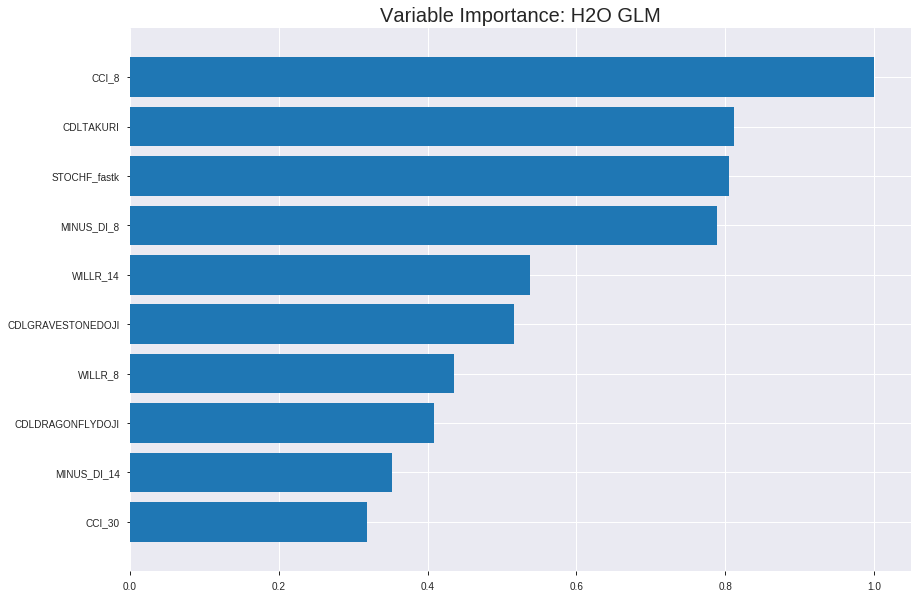

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190822_125941_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.18403710044306396
RMSE: 0.4289954550377707
LogLoss: 0.5412726191739453
Null degrees of freedom: 1786
Residual degrees of freedom: 1736
Null deviance: 2477.2806029937074
Residual deviance: 1934.5083409276804
AIC: 2036.5083409276804
AUC: 0.7945229416406749
pr_auc: 0.7990297824301845
Gini: 0.5890458832813499
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3713565314359417: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      439  451   0.5067   (451.0/890.0)
1      99   798   0.1104   (99.0/897.0)
Total  538  1249  0.3078   (550.0/1787.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.371357     0.743709  262
max f2                       0.156588     0.853305  343
max f0point5                 0.586558     0.720201  155
max accuracy                 0.485347     0.715165  205
max precision                0.996107     1         0
max recall                   0.0592884    1         383
max specificity              0.996107     1         0
max absolute_mcc             0.483292     0.430476  206
max min_per_class_accuracy   0.496163     0.710145  200
max mean_per_class_accuracy  0.485347     0.715115  205

Gains/Lift Table: Avg response rate: 50.20 %, avg score: 50.20 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100727                   0.97935            1.9922    1.9922             1                0.987016   1                           0.987016            0.0200669       0.0200669                  99.2196   99.2196
    2        0.0201455                   0.969351           1.88152   1.93686            0.944444         0.972938   0.972222                    0.979977            0.0189521       0.039019                   88.1519   93.6857
    3        0.0302182                   0.964205           1.88152   1.91841            0.944444         0.966826   0.962963                    0.975593            0.0189521       0.057971                   88.1519   91.8411
    4        0.040291                    0.959065           1.9922    1.93686            1                0.961985   0.972222                    0.972191            0.0200669       0.0780379                  99.2196   93.6857
    5        0.0503637                   0.947891           1.88152   1.92579            0.944444         0.953042   0.966667                    0.968361            0.0189521       0.09699                    88.1519   92.579
    6        0.100168                    0.898507           1.85789   1.89203            0.932584         0.925341   0.949721                    0.946971            0.0925307       0.189521                   85.7891   89.203
    7        0.149972                    0.808042           1.63405   1.80636            0.820225         0.855996   0.906716                    0.916759            0.0813824       0.270903                   63.4049   80.6357
    8        0.200336                    0.714916           1.63803   1.76404            0.822222         0.756438   0.885475                    0.876455            0.0824972       0.3534                     63.8028   76.404
    9        0.299944                    0.623767           1.30948   1.61308            0.657303         0.668393   0.809701                    0.80736             0.130435        0.483835                   30.9477   61.3084
    10       0.400112                    0.552532           1.19087   1.50738            0.597765         0.584679   0.756643                    0.751612            0.119287        0.603122                   19.0866   50.7382
    11       0.50028                     0.495495           1.06844   1.4195             0.536313         0.522588   0.712528                    0.705756            0.107023        0.710145                   6.84404   41.9496
    12       0.599888                    0.433302           0.962522  1.34362            0.483146         0.463548   0.67444                     0.665539            0.0958751       0.80602                    -3.74782  34.3617
    13       0.700056                    0.369629           0.845849  1.27239            0.424581         0.400883   0.638689                    0.62767             0.0847269       0.890747                   -15.4151  27.2394
    14       0.799664                    0.282748           0.548414  1.18221            0.275281         0.333334   0.593422                    0.591007            0.0546265       0.945373                   -45.1586  18.2213
    15       0.899832                    0.138026           0.400665  1.09521            0.201117         0.21269    0.549751                    0.548893            0.0401338       0.985507                   -59.9335  9.52123
    16       1                           3.97403e-05        0.144685  1                  0.0726257        0.0803342  0.501959                    0.



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.1761029346443997
RMSE: 0.41964620175142736
LogLoss: 0.5275660430170066
Null degrees of freedom: 509
Residual degrees of freedom: 459
Null deviance: 706.9709434262809
Residual deviance: 538.1173638773467
AIC: 640.1173638773467
AUC: 0.8198443460071367
pr_auc: 0.8140123458864446
Gini: 0.6396886920142735
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3466448904262287: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      150  102  0.4048   (102.0/252.0)
1      25   233  0.0969   (25.0/258.0)
Total  175  335  0.249    (127.0/510.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.346645     0.785835  258
max f2                       0.135245     0.853659  344
max f0point5                 0.493848     0.761618  177
max accuracy                 0.439258     0.75098   207
max precision                0.979962     1         0
max recall                   0.0488915    1         387
max specificity              0.979962     1         0
max absolute_mcc             0.346645     0.5248    258
max min_per_class_accuracy   0.454736     0.742063  199
max mean_per_class_accuracy  0.439258     0.7506    207

Gains/Lift Table: Avg response rate: 50.59 %, avg score: 47.80 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117647                   0.970037           1.97674   1.97674            1                0.974213   1                           0.974213            0.0232558       0.0232558                  97.6744   97.6744
    2        0.0215686                   0.961772           1.97674   1.97674            1                0.965959   1                           0.970461            0.0193798       0.0426357                  97.6744   97.6744
    3        0.0313725                   0.955362           1.97674   1.97674            1                0.957507   1                           0.966413            0.0193798       0.0620155                  97.6744   97.6744
    4        0.0411765                   0.948912           1.97674   1.97674            1                0.951428   1                           0.962845            0.0193798       0.0813953                  97.6744   97.6744
    5        0.0509804                   0.946286           0.790698  1.74866            0.4              0.947828   0.884615                    0.959957            0.00775194      0.0891473                  -20.9302  74.8658
    6        0.1                         0.920932           1.89767   1.82171            0.96             0.935376   0.921569                    0.947908            0.0930233       0.182171                   89.7674   82.1705
    7        0.15098                     0.833522           1.67263   1.77137            0.846154         0.892088   0.896104                    0.929059            0.0852713       0.267442                   67.263    77.1368
    8        0.2                         0.727112           1.89767   1.80233            0.96             0.767601   0.911765                    0.889486            0.0930233       0.360465                   89.7674   80.2326
    9        0.3                         0.606967           1.27907   1.62791            0.647059         0.654794   0.823529                    0.811255            0.127907        0.488372                   27.907    62.7907
    10       0.4                         0.529029           1.35659   1.56008            0.686275         0.564241   0.789216                    0.749502            0.135659        0.624031                   35.6589   56.0078
    11       0.5                         0.4572             1.16279   1.48062            0.588235         0.490897   0.74902                     0.697781            0.116279        0.74031                    16.2791   48.062
    12       0.6                         0.386294           0.968992  1.39535            0.490196         0.423948   0.705882                    0.652142            0.0968992       0.837209                   -3.10078  39.5349
    13       0.7                         0.32813            0.697674  1.29568            0.352941         0.354241   0.655462                    0.609585            0.0697674       0.906977                   -30.2326  29.5681
    14       0.8                         0.224297           0.348837  1.17733            0.176471         0.280398   0.595588                    0.568436            0.0348837       0.94186                    -65.1163  17.7326
    15       0.9                         0.11027            0.426357  1.09388            0.215686         0.169256   0.553377                    0.524083            0.0426357       0.984496                   -57.3643  9.38846
    16       1                           0.0117071          0.155039  1                  0.0784314        0.0630315  0.505882                    


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-22 12:59:41  0.000 sec   2            .16E2     51            1.369813276005582   1.366349257612666
     2019-08-22 12:59:41  0.015 sec   4            .96E1     51            1.3607943169619496  1.3554898557598651
     2019-08-22 12:59:41  0.032 sec   6            .6E1      51            1.3476296868202675  1.3396704427251565
     2019-08-22 12:59:41  0.054 sec   8            .37E1     51            1.3293431627130512  1.317768728984825
     2019-08-22 12:59:41  0.079 sec   10           .23E1     51            1.3055402602161004  1.289386343673312
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-22 12:59:42  0.509 sec   44           .7E-3     51            1.0816365345932015  1.0552440348775873
     2019-08-22 12:59:42  0.536 sec   46           .44E-3    51            1.0810195845193555  1.055448619950652
     2019-08-22 12:59:42  0.551 sec   47           .27E-3    51            1.0806309408249972  1.0556741834048278
     2019-08-22 12:59:42  0.561 sec   48           .17E-3    51            1.0803530177039522  1.0558050985790806
     2019-08-22 12:59:42  0.582 sec   49           .1E-3     51            1.080190666627015   1.0559703038633166


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.78125)

('F1', 0.7862068965517242)

('auc', 0.8674853372434018)

('logloss', 0.45599802212532026)

('mean_per_class_error', 0.22128543499511233)

('rmse', 0.38733860752240623)

('mse', 0.15003119687739666)

glm prediction progress: |████████████████████████████████████████████████| 100%


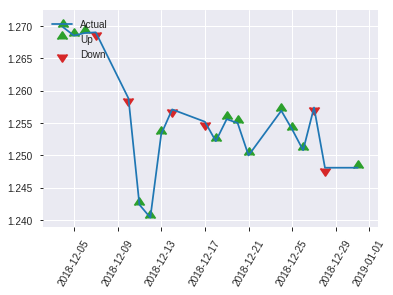


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.15003119687739666
RMSE: 0.38733860752240623
LogLoss: 0.45599802212532026
Null degrees of freedom: 255
Residual degrees of freedom: 205
Null deviance: 354.9579598113329
Residual deviance: 233.47098732816397
AIC: 335.470987328164
AUC: 0.8674853372434018
pr_auc: 0.8644539768032677
Gini: 0.7349706744868036
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37626026336304336: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      80   52   0.3939   (52.0/132.0)
1      10   114  0.0806   (10.0/124.0)
Total  90   166  0.2422   (62.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.37626      0.786207  165
max f2                       0.307587     0.868613  188
max f0point5                 0.623263     0.818182  78
max accuracy                 0.543918     0.78125   101
max precision                0.982868     1         0
max recall                   0.0588967    1         240
max specificity              0.982868     1         0
max absolute_mcc             0.623263     0.57084   78
max min_per_class_accuracy   0.4695       0.772727  125
max mean_per_class_accuracy  0.448451     0.778715  136

Gains/Lift Table: Avg response rate: 48.44 %, avg score: 49.53 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0117188                   0.974174           2.06452    2.06452            1                0.978567   1                           0.978567            0.0241935       0.0241935                  106.452    106.452
    2        0.0234375                   0.972875           2.06452    2.06452            1                0.973137   1                           0.975852            0.0241935       0.0483871                  106.452    106.452
    3        0.03125                     0.970819           2.06452    2.06452            1                0.971495   1                           0.974763            0.016129        0.0645161                  106.452    106.452
    4        0.0429688                   0.962132           2.06452    2.06452            1                0.966399   1                           0.972481            0.0241935       0.0887097                  106.452    106.452
    5        0.0507812                   0.955017           2.06452    2.06452            1                0.958652   1                           0.970354            0.016129        0.104839                   106.452    106.452
    6        0.101562                    0.93514            2.06452    2.06452            1                0.945513   1                           0.957934            0.104839        0.209677                   106.452    106.452
    7        0.152344                    0.892717           1.90571    2.01158            0.923077         0.912773   0.974359                    0.94288             0.0967742       0.306452                   90.5707    101.158
    8        0.203125                    0.810368           1.7469     1.94541            0.846154         0.847309   0.942308                    0.918987            0.0887097       0.395161                   74.6898    94.5409
    9        0.300781                    0.632721           1.73419    1.87683            0.84             0.716992   0.909091                    0.853404            0.169355        0.564516                   73.4194    87.6833
    10       0.402344                    0.540232           1.19107    1.70373            0.576923         0.582878   0.825243                    0.785116            0.120968        0.685484                   19.1067    70.3727
    11       0.5                         0.466558           0.990968   1.56452            0.48             0.502921   0.757812                    0.73                0.0967742       0.782258                   -0.903226  56.4516
    12       0.601562                    0.396742           0.952854   1.46125            0.461538         0.43481    0.707792                    0.680163            0.0967742       0.879032                   -4.71464   46.1248
    13       0.699219                    0.340201           0.495484   1.32637            0.24             0.370127   0.642458                    0.636862            0.0483871       0.927419                   -50.4516   32.6365
    14       0.800781                    0.220332           0.476427   1.21857            0.230769         0.283566   0.590244                    0.592053            0.0483871       0.975806                   -52.3573   21.8568
    15       0.898438                    0.101728           0.165161   1.10407            0.08             0.157397   0.534783                    0.544808            0.016129        0.991935                   -83.4839   10.4067
    16       1                           0.0145762          0.0794045  1                  0.0384615        0.0

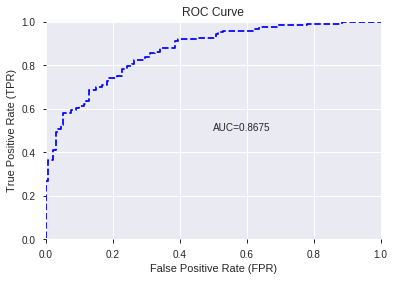

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


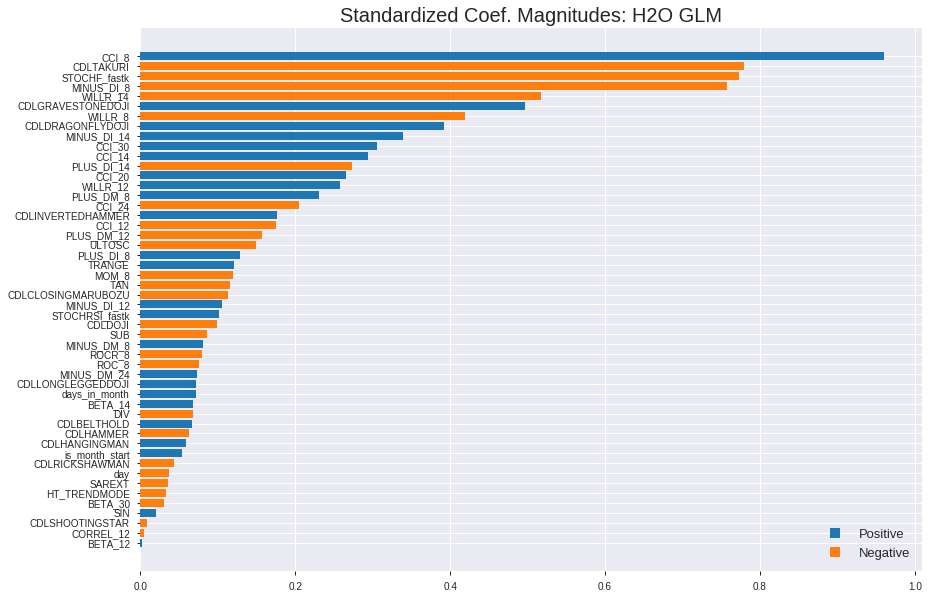

'log_likelihood'
--2019-08-22 12:59:48--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.107.124
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.107.124|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


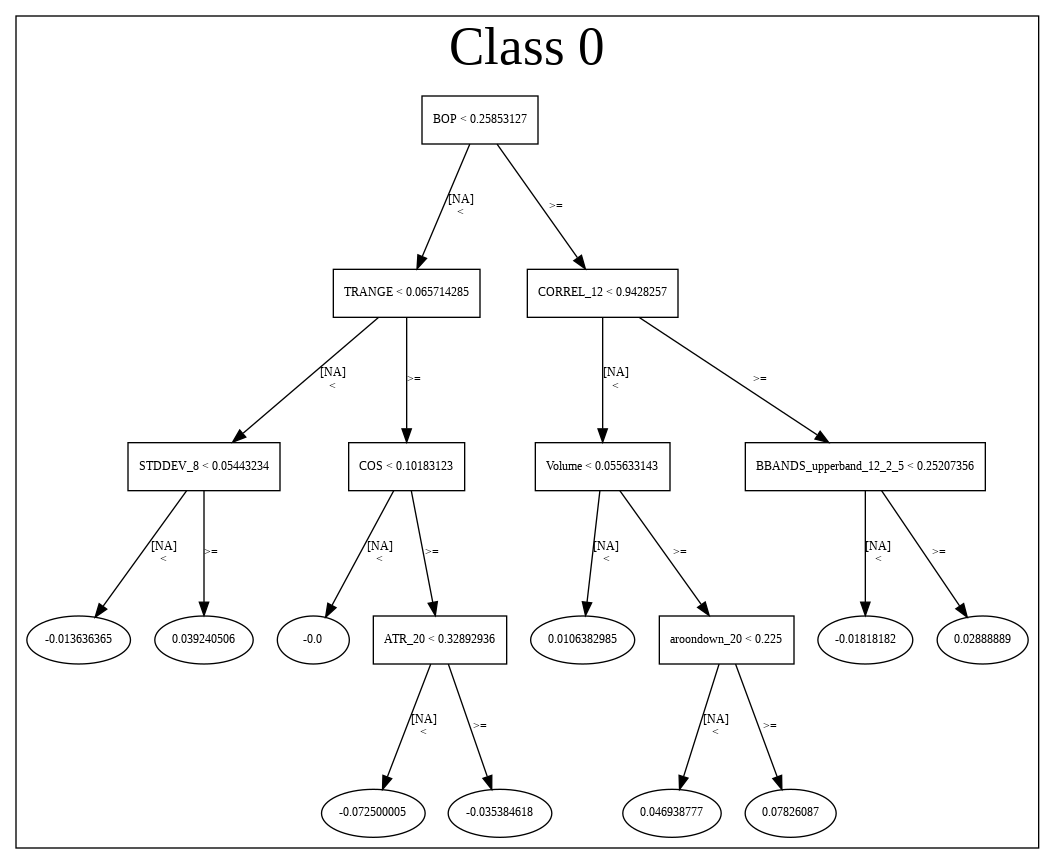

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190822_125941_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190822_125941_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_92dd',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['CCI_8',
 'CDLTAKURI',
 'STOCHF_fastk',
 'MINUS_DI_8',
 'WILLR_14',
 'CDLGRAVESTONEDOJI',
 'WILLR_8',
 'CDLDRAGONFLYDOJI',
 'MINUS_DI_14',
 'CCI_30',
 'CCI_14',
 'PLUS_DI_14',
 'CCI_20',
 'WILLR_12',
 'PLUS_DM_8',
 'CCI_24',
 'CDLINVERTEDHAMMER',
 'CCI_12',
 'PLUS_DM_12',
 'ULTOSC',
 'PLUS_DI_8',
 'TRANGE',
 'MOM_8',
 'TAN',
 'CDLCLOSINGMARUBOZU',
 'MINUS_DI_12',
 'STOCHRSI_fastk',
 'CDLDOJI',
 'SUB',
 'MINUS_DM_8',
 'ROCR_8',
 'ROC_8',
 'MINUS_DM_24',
 'CDLLONGLEGGEDDOJI',
 'days_in_month',
 'BETA_14',
 'DIV',
 'CDLBELTHOLD',
 'CDLHAMMER',
 'CDLHANGINGMAN',
 'is_month_start',
 'CDLRICKSHAWMAN',
 'day',
 'SAREXT',
 'HT_TRENDMODE',
 'BETA_30',
 'SIN',
 'CDLSHOOTINGSTAR',
 'CORREL_12',
 'BETA_12']

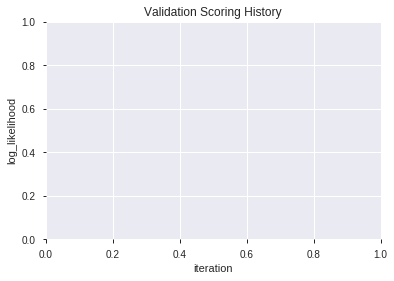

In [20]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190822_125956_model_7  0.861009  0.476023              0.223607  0.394845  0.155902
1  XGBoost_grid_1_AutoML_20190822_125956_model_3  0.855633  0.476302              0.242302  0.396903  0.157532
2               XGBoost_1_AutoML_20190822_125956  0.854717  0.485405              0.252199  0.399409  0.159528
3  XGBoost_grid_1_AutoML_20190822_125956_model_5  0.852456  0.483830              0.218231  0.402347  0.161883
4  XGBoost_grid_1_AutoML_20190822_125956_model_6  0.847996  0.488438              0.247312  0.403232  0.162596
5               XGBoost_2_AutoML_20190822_125956  0.846774  0.492904              0.235948  0.404464  0.163591
6  XGBoost_grid_1_AutoML_20190822_125956_model_2  0.843781  0.497251              0.235704  0.407042  0.165683
7  XGBoost_grid_1_AutoML_20190822_125956_model_4  0.842864  0.503855              0.251588  0.408858  0.167165
8  XGBoost_grid_1_AutoML_20190822_125956_model_1  0.842681  0.490882              0.267595  0.403970  0.163192
9               XGBoost_3_AutoML_20190822_125956  0.839321  0.497828              0.250122  0.408324  0.166728

variable  relative_importance  scaled_importance  percentage
0   CDLGRAVESTONEDOJI          1137.364136           1.000000    0.095361
1        STOCHF_fastk           634.775208           0.558111    0.053222
2               CCI_8           623.010742           0.547767    0.052236
3           CDLTAKURI           617.262817           0.542713    0.051754
4              ULTOSC           516.302612           0.453947    0.043289
5                 DIV           443.265381           0.389730    0.037165
6             WILLR_8           424.207214           0.372974    0.035567
7           CORREL_12           370.971527           0.326168    0.031104
8          MINUS_DI_8           339.168823           0.298206    0.028437
9            WILLR_14           335.921783           0.295351    0.028165
10            BETA_12           331.235962           0.291231    0.027772
11           WILLR_12           322.192871           0.283280    0.027014
12            BETA_14           294.989105           0.259362    0.024733
13                TAN           291.236420           0.256063    0.024418
14              ROC_8           290.961243           0.255821    0.024395
15             SAREXT           290.361176           0.255293    0.024345
16             CCI_14           285.798523           0.251281    0.023963
17                day           279.307098           0.245574    0.023418
18             CCI_12           279.190948           0.245472    0.023409
19         PLUS_DM_12           277.385712           0.243885    0.023257
20                SIN           266.266907           0.234109    0.022325
21             TRANGE           248.371552           0.218375    0.020824
22            BETA_30           247.970779           0.218022    0.020791
23          PLUS_DM_8           231.306946           0.203371    0.019394
24        MINUS_DI_12           227.267670           0.199820    0.019055
25                SUB           224.092819           0.197028    0.018789
26        MINUS_DM_24           222.783737           0.195877    0.018679
27         PLUS_DI_14           211.267456           0.185752    0.017714
28          PLUS_DI_8           208.184845           0.183042    0.017455
29              MOM_8           207.408401           0.182359    0.017390
30         MINUS_DM_8           177.888565           0.156404    0.014915
31        MINUS_DI_14           158.199966           0.139094    0.013264
32     STOCHRSI_fastk           149.717484           0.131635    0.012553
33             CCI_20           147.583038           0.129759    0.012374
34             CCI_30           136.074493           0.119640    0.011409
35             CCI_24           111.970932           0.098448    0.009388
36   CDLDRAGONFLYDOJI            85.120903           0.074841    0.007137
37             ROCR_8            68.383644           0.060125    0.005734
38     CDLRICKSHAWMAN            57.978397           0.050976    0.004861
39       HT_TRENDMODE            57.204845           0.050296    0.004796
40      days_in_month            36.900448           0.032444    0.003094
41            CDLDOJI            32.296318           0.028396    0.002708
42  CDLINVERTEDHAMMER            19.839767           0.017444    0.001663
43  CDLLONGLEGGEDDOJI             7.911930           0.006956    0.000663

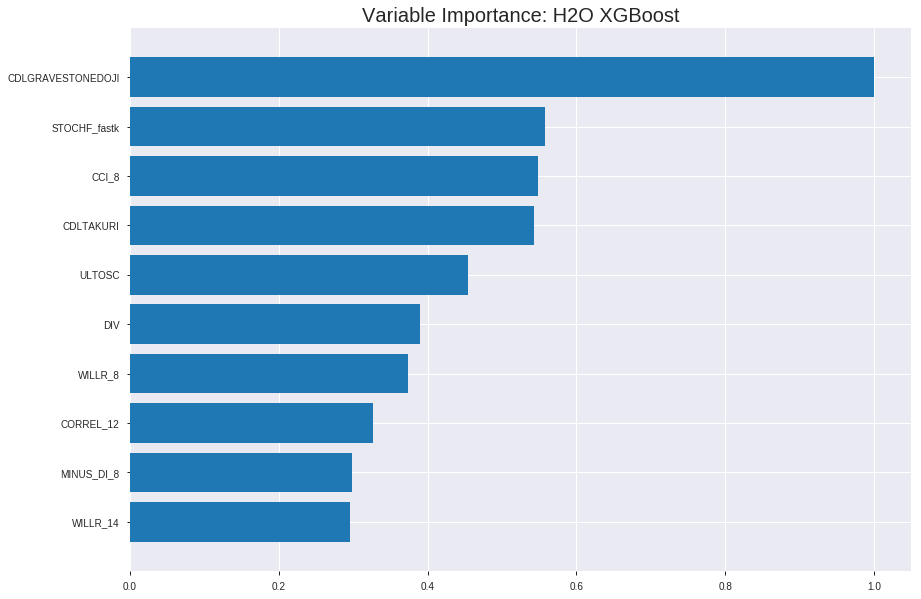

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190822_125956_model_7


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.09511230721776623
RMSE: 0.3084028327006194
LogLoss: 0.33694483394143737
Mean Per-Class Error: 0.07938947553016917
AUC: 0.9705547831097415
pr_auc: 0.9682312499781874
Gini: 0.941109566219483
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4961223006248474: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      821  69   0.0775   (69.0/890.0)
1      73   824  0.0814   (73.0/897.0)
Total  894  893  0.0795   (142.0/1787.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.496122     0.92067   198
max f2                       0.37821      0.939979  245
max f0point5                 0.5245       0.930367  188
max accuracy                 0.521888     0.920537  189
max precision                0.964622     1         0
max recall                   0.169156     1         340
max specificity              0.964622     1         0
max absolute_mcc             0.521888     0.841705  189
max min_per_class_accuracy   0.494024     0.919101  199
max mean_per_class_accuracy  0.521888     0.920611  189

Gains/Lift Table: Avg response rate: 50.20 %, avg score: 50.41 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100727                   0.949259           1.9922     1.9922             1                0.955894   1                           0.955894            0.0200669       0.0200669                  99.2196   99.2196
    2        0.0201455                   0.942036           1.9922     1.9922             1                0.945385   1                           0.95064             0.0200669       0.0401338                  99.2196   99.2196
    3        0.0302182                   0.93642            1.9922     1.9922             1                0.939872   1                           0.947051            0.0200669       0.0602007                  99.2196   99.2196
    4        0.040291                    0.930112           1.9922     1.9922             1                0.933218   1                           0.943592            0.0200669       0.0802676                  99.2196   99.2196
    5        0.0503637                   0.925306           1.9922     1.9922             1                0.928084   1                           0.940491            0.0200669       0.100334                   99.2196   99.2196
    6        0.100168                    0.891811           1.9922     1.9922             1                0.909957   1                           0.925309            0.0992196       0.199554                   99.2196   99.2196
    7        0.149972                    0.85279            1.96981    1.98476            0.988764         0.87223    0.996269                    0.907682            0.0981048       0.297659                   96.9812   98.4763
    8        0.200336                    0.809251           1.94793    1.9755             0.977778         0.831373   0.99162                     0.888498            0.0981048       0.395764                   94.7925   97.5502
    9        0.299944                    0.721646           1.90266    1.95131            0.955056         0.762738   0.979478                    0.846735            0.189521        0.585284                   90.2659   95.1312
    10       0.400112                    0.62158            1.82525    1.91975            0.916201         0.674075   0.963636                    0.803509            0.182832        0.768116                   82.5252   91.9753
    11       0.50028                     0.494625           1.50249    1.83621            0.75419          0.563033   0.9217                      0.75536             0.150502        0.918618                   50.2494   83.6208
    12       0.599888                    0.378585           0.570798   1.62609            0.286517         0.43321    0.816231                    0.701869            0.0568562       0.975474                   -42.9202  62.6093
    13       0.700056                    0.290674           0.144685   1.41412            0.0726257        0.333306   0.709832                    0.649133            0.0144928       0.989967                   -85.5315  41.4125
    14       0.799664                    0.206032           0.0783448  1.24774            0.0393258        0.247647   0.626312                    0.599123            0.00780379      0.99777                    -92.1655  24.7737
    15       0.899832                    0.123067           0.0222592  1.11132            0.0111732        0.165635   0.557836                    0.550868            0.00222965      1                          -97.7741  11.1318
    16       1                           0.03455            0          1                  0                0.0835111  0.501959 



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.1705221292796045
RMSE: 0.4129432518877194
LogLoss: 0.5112541009919743
Mean Per-Class Error: 0.25087670727205613
AUC: 0.8266349821582379
pr_auc: 0.8230993788292252
Gini: 0.6532699643164759
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2927105724811554: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      125  127  0.504    (127.0/252.0)
1      17   241  0.0659   (17.0/258.0)
Total  142  368  0.2824   (144.0/510.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.292711     0.769968  290
max f2                       0.242472     0.861948  311
max f0point5                 0.547426     0.761618  174
max accuracy                 0.494717     0.74902   195
max precision                0.952776     1         0
max recall                   0.083977     1         385
max specificity              0.952776     1         0
max absolute_mcc             0.494717     0.498247  195
max min_per_class_accuracy   0.48381      0.742063  200
max mean_per_class_accuracy  0.494717     0.749123  195

Gains/Lift Table: Avg response rate: 50.59 %, avg score: 50.50 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117647                   0.942069           1.97674   1.97674            1                0.946832   1                           0.946832            0.0232558       0.0232558                  97.6744   97.6744
    2        0.0215686                   0.937742           1.5814    1.79704            0.8              0.938516   0.909091                    0.943052            0.0155039       0.0387597                  58.1395   79.704
    3        0.0313725                   0.929108           1.97674   1.8532             1                0.932835   0.9375                      0.939859            0.0193798       0.0581395                  97.6744   85.3198
    4        0.0411765                   0.922581           1.97674   1.88261            1                0.926332   0.952381                    0.936638            0.0193798       0.0775194                  97.6744   88.2614
    5        0.0509804                   0.916818           1.97674   1.90072            1                0.919677   0.961538                    0.933377            0.0193798       0.0968992                  97.6744   90.0716
    6        0.1                         0.892508           1.97674   1.93798            1                0.905925   0.980392                    0.91992             0.0968992       0.193798                   97.6744   93.7984
    7        0.15098                     0.850247           1.52057   1.79704            0.769231         0.873145   0.909091                    0.904126            0.0775194       0.271318                   52.0572   79.704
    8        0.2                         0.808467           1.66047   1.76357            0.84             0.828059   0.892157                    0.885482            0.0813953       0.352713                   66.0465   76.3566
    9        0.3                         0.685676           1.35659   1.62791            0.686275         0.747122   0.823529                    0.839362            0.135659        0.488372                   35.6589   62.7907
    10       0.4                         0.577786           1.39535   1.56977            0.705882         0.638784   0.794118                    0.789218            0.139535        0.627907                   39.5349   56.9767
    11       0.5                         0.488865           1.12403   1.48062            0.568627         0.538018   0.74902                     0.738978            0.112403        0.74031                    12.4031   48.062
    12       0.6                         0.411174           0.852713  1.37597            0.431373         0.446707   0.696078                    0.690266            0.0852713       0.825581                   -14.7287  37.5969
    13       0.7                         0.312368           0.891473  1.30676            0.45098          0.36515    0.661064                    0.643821            0.0891473       0.914729                   -10.8527  30.6755
    14       0.8                         0.212674           0.465116  1.20155            0.235294         0.26484    0.607843                    0.596448            0.0465116       0.96124                    -53.4884  20.155
    15       0.9                         0.140552           0.271318  1.09819            0.137255         0.18131    0.555556                    0.550322            0.0271318       0.988372                   -72.8682  9.81912
    16       1                           0.0399516          0.116279  1                  0.0588235        0.0971037  0.505882                    0.5


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 13:00:16  13.645 sec  0                  0.5              0.693147            0.5             0                  1                0.498041                         0.5                0.693147              0.5               0                    1                  0.494118
    2019-08-22 13:00:16  13.804 sec  5                  0.465899         0.62674             0.877073        0.880363           1.9922           0.217124                         0.472383           0.638986              0.806924          0.80368              1.97674            0.286275
    2019-08-22 13:00:16  13.907 sec  10                 0.438525         0.574997            0.902035        0.900249           1.9922           0.173475                         0.452583           0.600518              0.821344          0.821357             1.97674            0.276471
    2019-08-22 13:00:17  14.026 sec  15                 0.418237         0.536745            0.909662        0.909823           1.9922           0.168439                         0.439078           0.573445              0.821775          0.822664             1.97674            0.290196
    2019-08-22 13:00:17  14.133 sec  20                 0.402294         0.506576            0.918985        0.918309           1.9922           0.155568                         0.429538           0.553392              0.824174          0.823975             1.97674            0.260784
    2019-08-22 13:00:17  14.250 sec  25                 0.389889         0.482689            0.923659        0.920906           1.9922           0.149972                         0.423234           0.539608              0.827535          0.826785             1.97674            0.266667
    2019-08-22 13:00:17  14.356 sec  30                 0.378413         0.46097             0.931117        0.928908           1.9922           0.136542                         0.420222           0.532222              0.826781          0.824369             1.97674            0.266667
    2019-08-22 13:00:17  14.462 sec  35                 0.367071         0.439965            0.937306        0.934904           1.9922           0.131505                         0.417858           0.526319              0.827273          0.826862             1.97674            0.278431
    2019-08-22 13:00:17  14.559 sec  40                 0.357945         0.422947            0.942263        0.939083           1.9922           0.126469                         0.415582           0.520359              0.827704          0.826503             1.97674            0.260784
    2019-08-22 13:00:17  14.655 sec  45                 0.350733         0.409286            0.944862        0.93798            1.9922           0.118635                         0.41396            0.516536              0.829157          0.826184             1.97674            0.254902
    2019-08-22 13:00:17  14.761 sec  50                 0.341876         0.393687            0.951072        0.947841           1.9922           0.106883                         0.412998           0.51371               0.829296          0.82909              1.97674            0.268627
    2019-08-22 13:00:17  14.866 sec  55                 0.335257         0.381778            0.955083        0.951048           1.9922           0.105764                         0.411602           0.511071              0.831034          0

Variable Importances: 


variable           relative_importance    scaled_importance     percentage
-----------------  ---------------------  --------------------  ---------------------
CDLGRAVESTONEDOJI  1137.3641357421875     1.0                   0.09536124445282465
STOCHF_fastk       634.7752075195312      0.5581107998497846    0.053222140416236796
CCI_8              623.0107421875         0.5477671772909861    0.052235759696879464
CDLTAKURI          617.2628173828125      0.5427134529611463    0.05175383025566442
ULTOSC             516.3026123046875      0.4539466263087098    0.043288915199959914
---                ---                    ---                   ---
HT_TRENDMODE       57.2048454284668       0.05029598141068317   0.0047962873782988824
days_in_month      36.900447845458984     0.03244382927669825   0.0030938839346409306
CDLDOJI            32.29631805419922      0.0283957591410461    0.002707854928872827
CDLINVERTEDHAMMER  19.839767456054688     0.017443637294847738  0.001663446960220384
CDLLONGLEGGEDDOJI  7.911930084228516      0.006956373808169696  0.000663368463226097


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.78125)

('F1', 0.7883211678832117)

('auc', 0.8610092864125123)

('logloss', 0.47602272812052865)

('mean_per_class_error', 0.2201857282502444)

('rmse', 0.39484480941935374)

('mse', 0.1559024235254058)

xgboost prediction progress: |████████████████████████████████████████████| 100%


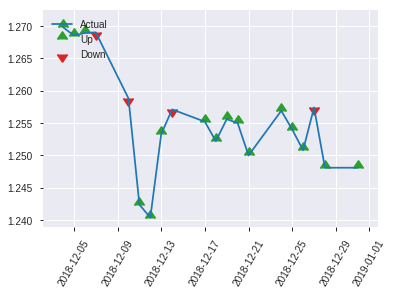


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.1559024235254058
RMSE: 0.39484480941935374
LogLoss: 0.47602272812052865
Mean Per-Class Error: 0.2201857282502444
AUC: 0.8610092864125123
pr_auc: 0.8386100034240583
Gini: 0.7220185728250246
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46200650930404663: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      90   42   0.3182   (42.0/132.0)
1      16   108  0.129    (16.0/124.0)
Total  106  150  0.2266   (58.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.462007     0.788321  149
max f2                       0.198497     0.873239  213
max f0point5                 0.641752     0.805785  89
max accuracy                 0.566961     0.78125   113
max precision                0.959799     1         0
max recall                   0.198497     1         213
max specificity              0.959799     1         0
max absolute_mcc             0.641752     0.563254  89
max min_per_class_accuracy   0.547275     0.766129  123
max mean_per_class_accuracy  0.566961     0.779814  113

Gains/Lift Table: Avg response rate: 48.44 %, avg score: 52.42 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.947958           2.06452   2.06452            1                0.955086  1                           0.955086            0.0241935       0.0241935                  106.452   106.452
    2        0.0234375                   0.942758           1.37634   1.72043            0.666667         0.945182  0.833333                    0.950134            0.016129        0.0403226                  37.6344   72.043
    3        0.03125                     0.939025           2.06452   1.80645            1                0.940002  0.875                       0.947601            0.016129        0.0564516                  106.452   80.6452
    4        0.0429688                   0.936734           2.06452   1.87683            1                0.937702  0.909091                    0.944901            0.0241935       0.0806452                  106.452   87.6833
    5        0.0507812                   0.930078           2.06452   1.90571            1                0.934085  0.923077                    0.943237            0.016129        0.0967742                  106.452   90.5707
    6        0.101562                    0.901504           2.06452   1.98511            1                0.919339  0.961538                    0.931288            0.104839        0.201613                   106.452   98.5112
    7        0.152344                    0.874783           2.06452   2.01158            1                0.88872   0.974359                    0.917099            0.104839        0.306452                   106.452   101.158
    8        0.203125                    0.829376           1.58809   1.90571            0.769231         0.856188  0.923077                    0.901871            0.0806452       0.387097                   58.8089   90.5707
    9        0.300781                    0.712684           1.56903   1.7964             0.76             0.760365  0.87013                     0.855928            0.153226        0.540323                   56.9032   79.6397
    10       0.402344                    0.589676           1.27047   1.66364            0.615385         0.643208  0.805825                    0.802232            0.129032        0.669355                   27.0471   66.3639
    11       0.5                         0.520251           1.07355   1.54839            0.52             0.561706  0.75                        0.755254            0.104839        0.774194                   7.35484   54.8387
    12       0.601562                    0.455885           0.952854  1.44784            0.461538         0.483394  0.701299                    0.709356            0.0967742       0.870968                   -4.71464  44.7842
    13       0.699219                    0.353944           0.743226  1.34943            0.36             0.394302  0.653631                    0.665354            0.0725806       0.943548                   -25.6774  34.9432
    14       0.800781                    0.253548           0.158809  1.19843            0.0769231        0.29779   0.580488                    0.618736            0.016129        0.959677                   -84.1191  19.8426
    15       0.898438                    0.137956           0.412903  1.11304            0.2              0.18672   0.53913                     0.571778            0.0403226       1                          -58.7097  11.3043
    16       1                           0.0606025          0         1                  0                0.102892  0.484375                    0.524156          

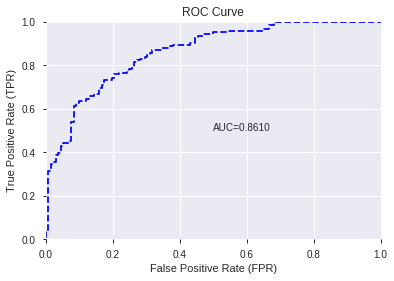

This function is available for GLM models only


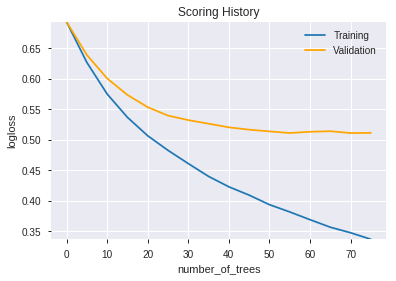

--2019-08-22 13:00:23--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.171.35
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.171.35|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

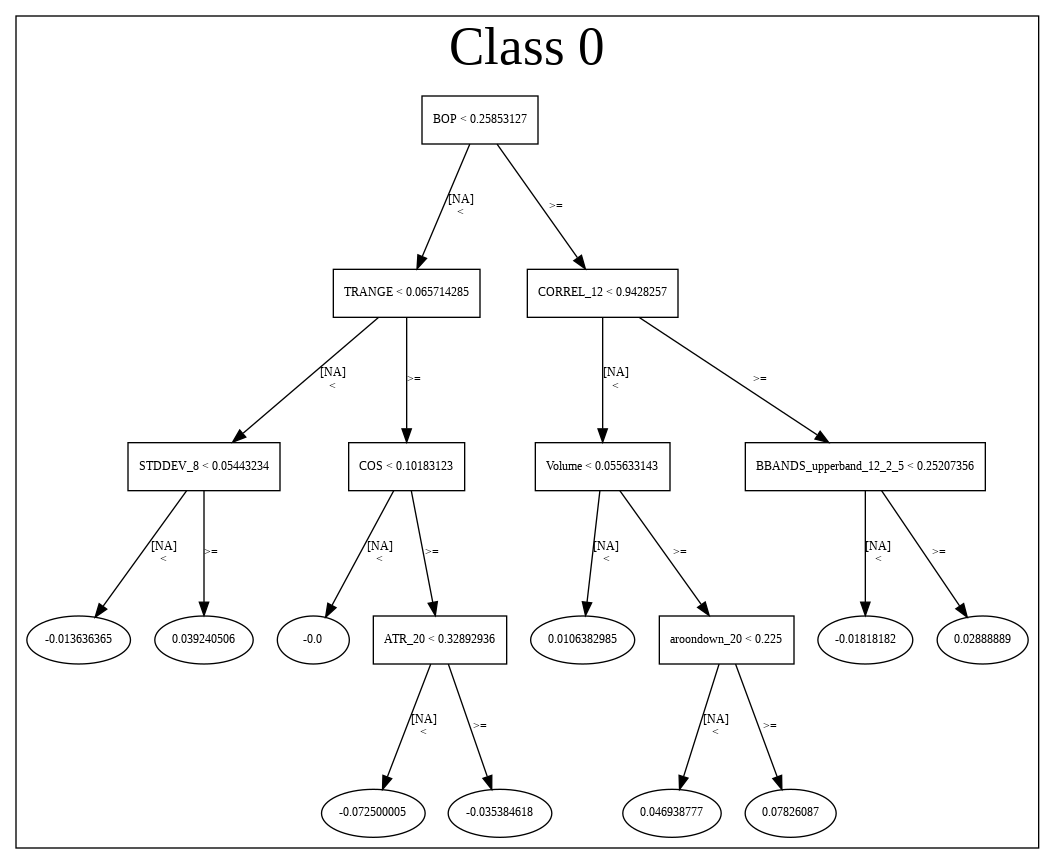

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190822_125956_model_7',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190822_125956_model_7',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_92dd',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['CDLGRAVESTONEDOJI',
 'STOCHF_fastk',
 'CCI_8',
 'CDLTAKURI',
 'ULTOSC',
 'DIV',
 'WILLR_8',
 'CORREL_12',
 'MINUS_DI_8',
 'WILLR_14',
 'BETA_12',
 'WILLR_12',
 'BETA_14',
 'TAN',
 'ROC_8',
 'SAREXT',
 'CCI_14',
 'day',
 'CCI_12',
 'PLUS_DM_12',
 'SIN',
 'TRANGE',
 'BETA_30',
 'PLUS_DM_8',
 'MINUS_DI_12',
 'SUB',
 'MINUS_DM_24',
 'PLUS_DI_14',
 'PLUS_DI_8',
 'MOM_8',
 'MINUS_DM_8',
 'MINUS_DI_14',
 'STOCHRSI_fastk',
 'CCI_20',
 'CCI_30',
 'CCI_24',
 'CDLDRAGONFLYDOJI',
 'ROCR_8',
 'CDLRICKSHAWMAN',
 'HT_TRENDMODE',
 'days_in_month',
 'CDLDOJI',
 'CDLINVERTEDHAMMER',
 'CDLLONGLEGGEDDOJI']

In [21]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [23]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [24]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [25]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [27]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [28]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [29]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [31]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [32]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [33]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [35]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [36]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [37]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [39]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [40]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [41]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [43]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [44]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [45]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [46]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

14

['CCI_8',
 'MINUS_DI_8',
 'CCI_12',
 'STOCHF_fastk',
 'ULTOSC',
 'CDLBELTHOLD',
 'CDLCLOSINGMARUBOZU',
 'CDLDRAGONFLYDOJI',
 'CDLGRAVESTONEDOJI',
 'CDLHAMMER',
 'CDLHANGINGMAN',
 'CDLINVERTEDHAMMER',
 'CDLSHOOTINGSTAR',
 'CDLTAKURI']

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190822_130035_model_7  0.843353  0.545977              0.235215  0.421833  0.177943
1  DeepLearning_grid_1_AutoML_20190822_130035_model_3  0.840970  0.507250              0.246823  0.415418  0.172572
2  DeepLearning_grid_1_AutoML_20190822_130035_model_8  0.838893  0.528238              0.257942  0.420625  0.176925
3  DeepLearning_grid_1_AutoML_20190822_130035_model_6  0.835960  0.506923              0.230572  0.411947  0.169700
4  DeepLearning_grid_1_AutoML_20190822_130035_model_4  0.833211  0.524199              0.249878  0.414351  0.171687
5  DeepLearning_grid_1_AutoML_20190822_130035_model_9  0.831989  0.513819              0.271872  0.415525  0.172661
6               DeepLearning_1_AutoML_20190822_130035  0.830523  0.504920              0.271628  0.412748  0.170361
7  DeepLearning_grid_1_AutoML_20190822_130035_model_5  0.827529  0.513672              0.275660  0.415209  0.172399
8  DeepLearning_grid_1_AutoML_20190822_130035_model_1  0.817510  0.534155              0.261730  0.425098  0.180709
9  DeepLearning_grid_1_AutoML_20190822_130035_model_2  0.797654  0.533159              0.297165  0.428379  0.183509

variable  relative_importance  scaled_importance  percentage
0         STOCHF_fastk             1.000000           1.000000    0.083235
1    CDLGRAVESTONEDOJI             0.998891           0.998891    0.083143
2            CDLTAKURI             0.935209           0.935209    0.077842
3               ULTOSC             0.922218           0.922218    0.076761
4   CDLCLOSINGMARUBOZU             0.889250           0.889250    0.074017
5    CDLINVERTEDHAMMER             0.869441           0.869441    0.072368
6     CDLDRAGONFLYDOJI             0.866670           0.866670    0.072138
7                CCI_8             0.848541           0.848541    0.070629
8          CDLBELTHOLD             0.824831           0.824831    0.068655
9           MINUS_DI_8             0.798858           0.798858    0.066493
10     CDLSHOOTINGSTAR             0.781797           0.781797    0.065073
11              CCI_12             0.775345           0.775345    0.064536
12       CDLHANGINGMAN             0.769997           0.769997    0.064091
13           CDLHAMMER             0.733093           0.733093    0.061019

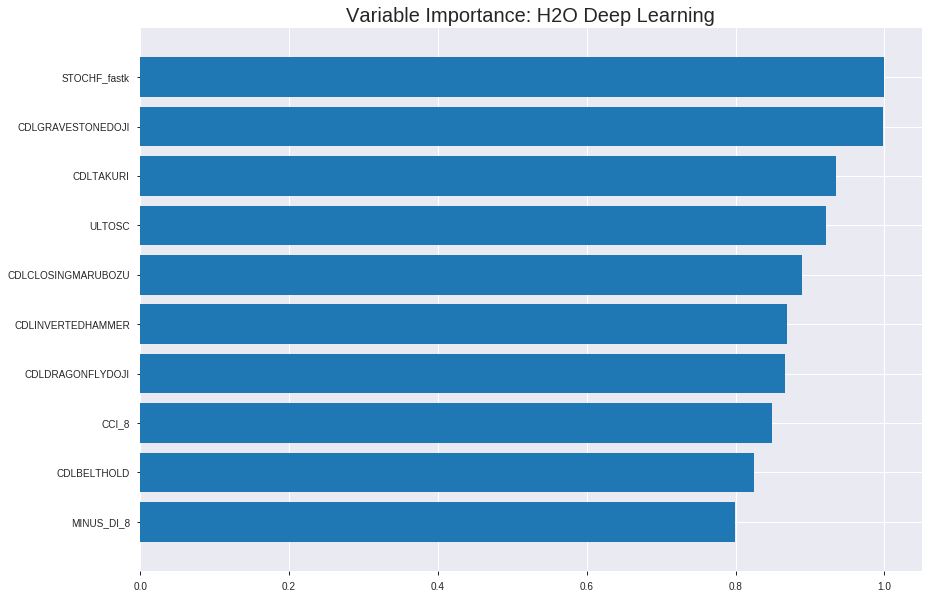

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190822_130035_model_7


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.1985715331693164
RMSE: 0.4456136590919497
LogLoss: 0.5825843810585191
Mean Per-Class Error: 0.31393659263713003
AUC: 0.7675416181278418
pr_auc: 0.7525239353647691
Gini: 0.5350832362556837
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49717594810200594: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      333  557   0.6258   (557.0/890.0)
1      61   836   0.068    (61.0/897.0)
Total  394  1393  0.3458   (618.0/1787.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.497176     0.730131  242
max f2                       0.132267     0.850859  346
max f0point5                 0.591536     0.693082  161
max accuracy                 0.562795     0.686066  185
max precision                0.999327     1         0
max recall                   0.017223     1         391
max specificity              0.999327     1         0
max absolute_mcc             0.562795     0.372125  185
max min_per_class_accuracy   0.562795     0.685393  185
max mean_per_class_accuracy  0.562795     0.686063  185

Gains/Lift Table: Avg response rate: 50.20 %, avg score: 55.96 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100727                   0.999257           1.9922    1.9922             1                0.999351   1                           0.999351            0.0200669       0.0200669                  99.2196   99.2196
    2        0.0201455                   0.999086           1.9922    1.9922             1                0.999169   1                           0.99926             0.0200669       0.0401338                  99.2196   99.2196
    3        0.0302182                   0.998789           1.88152   1.9553             0.944444         0.998976   0.981481                    0.999165            0.0189521       0.0590858                  88.1519   95.5304
    4        0.040291                    0.998147           1.88152   1.93686            0.944444         0.998425   0.972222                    0.99898             0.0189521       0.0780379                  88.1519   93.6857
    5        0.0503637                   0.997479           1.88152   1.92579            0.944444         0.997866   0.966667                    0.998757            0.0189521       0.09699                    88.1519   92.579
    6        0.100168                    0.983159           1.88028   1.90316            0.94382          0.993494   0.955307                    0.996141            0.0936455       0.190635                   88.0275   90.316
    7        0.149972                    0.764963           1.58928   1.79892            0.797753         0.86803    0.902985                    0.953596            0.0791527       0.269788                   58.928    79.8923
    8        0.200336                    0.697359           1.39454   1.69726            0.7              0.726966   0.851955                    0.896622            0.0702341       0.340022                   39.4537   69.7262
    9        0.299944                    0.63072            1.24232   1.54618            0.623596         0.660758   0.776119                    0.818294            0.123746        0.463768                   24.2325   54.6182
    10       0.400112                    0.591458           1.15748   1.44887            0.581006         0.609297   0.727273                    0.765972            0.115942        0.57971                    15.7477   44.887
    11       0.50028                     0.562589           1.05731   1.37047            0.530726         0.574543   0.687919                    0.727643            0.105909        0.685619                   5.73108   37.0471
    12       0.599888                    0.548023           0.872985  1.28787            0.438202         0.555066   0.646455                    0.698988            0.0869565       0.772575                   -12.7015  28.7866
    13       0.700056                    0.529758           0.912626  1.23417            0.458101         0.539891   0.619504                    0.676223            0.0914158       0.863991                   -8.73738  23.4174
    14       0.799664                    0.459523           0.772256  1.17664            0.38764          0.509942   0.590623                    0.655511            0.0769231       0.940914                   -22.7744  17.6637
    15       0.899832                    0.09331            0.434054  1.09397            0.217877         0.318463   0.549129                    0.617991            0.0434783       0.984392                   -56.5946  9.39734
    16       1                           0.00340249         0.155814  1                  0.0782123        0.0347881  0.501959                    0.



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.18552429249627414
RMSE: 0.43072530979299806
LogLoss: 0.5761094686890891
Mean Per-Class Error: 0.2582595053525286
AUC: 0.8086932447397563
pr_auc: 0.7945266193629217
Gini: 0.6173864894795127
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5082514289629974: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      120  132  0.5238   (132.0/252.0)
1      23   235  0.0891   (23.0/258.0)
Total  143  367  0.3039   (155.0/510.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.508251     0.752     268
max f2                       0.112857     0.859482  332
max f0point5                 0.567474     0.754717  168
max accuracy                 0.565889     0.741176  172
max precision                0.999362     1         0
max recall                   0.00985181   1         399
max specificity              0.999362     1         0
max absolute_mcc             0.565889     0.485426  172
max min_per_class_accuracy   0.557154     0.722222  191
max mean_per_class_accuracy  0.565889     0.74174   172

Gains/Lift Table: Avg response rate: 50.59 %, avg score: 54.18 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117647                   0.999263           1.97674   1.97674            1                0.999333  1                           0.999333            0.0232558       0.0232558                  97.6744   97.6744
    2        0.0215686                   0.999197           1.97674   1.97674            1                0.999241  1                           0.999292            0.0193798       0.0426357                  97.6744   97.6744
    3        0.0313725                   0.999085           1.5814    1.8532             0.8              0.999146  0.9375                      0.999246            0.0155039       0.0581395                  58.1395   85.3198
    4        0.0411765                   0.998906           1.97674   1.88261            1                0.999006  0.952381                    0.999189            0.0193798       0.0775194                  97.6744   88.2614
    5        0.0509804                   0.998041           1.5814    1.82469            0.8              0.998426  0.923077                    0.999042            0.0155039       0.0930233                  58.1395   82.4687
    6        0.1                         0.993435           1.73953   1.78295            0.88             0.995465  0.901961                    0.997289            0.0852713       0.178295                   73.9535   78.2946
    7        0.15098                     0.83763            1.90072   1.82271            0.961538         0.977818  0.922078                    0.990714            0.0968992       0.275194                   90.0716   82.2712
    8        0.2                         0.675959           1.42326   1.72481            0.72             0.720029  0.872549                    0.92437             0.0697674       0.344961                   42.3256   72.4806
    9        0.3                         0.61693            1.47287   1.64083            0.745098         0.645787  0.830065                    0.831509            0.147287        0.492248                   47.2868   64.0827
    10       0.4                         0.581046           1.27907   1.55039            0.647059         0.598837  0.784314                    0.773341            0.127907        0.620155                   27.907    55.0388
    11       0.5                         0.557356           1.00775   1.44186            0.509804         0.56801   0.729412                    0.732275            0.100775        0.72093                    0.775194  44.186
    12       0.6                         0.547102           0.930233  1.35659            0.470588         0.55187   0.686275                    0.702207            0.0930233       0.813953                   -6.97674  35.6589
    13       0.7                         0.519543           0.813953  1.27907            0.411765         0.534314  0.647059                    0.678223            0.0813953       0.895349                   -18.6047  27.907
    14       0.8                         0.394936           0.581395  1.19186            0.294118         0.461142  0.602941                    0.651088            0.0581395       0.953488                   -41.8605  19.186
    15       0.9                         0.0443065          0.271318  1.08958            0.137255         0.183889  0.551198                    0.599177            0.0271318       0.98062                    -72.8682  8.9578
    16       1                           0.00985181         0.193798  1                  0.0980392        0.024949  0.505882                    0.541754            0


Scoring History: 


timestamp            duration    training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 13:04:43  0.000 sec                     0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-22 13:04:47  4.969 sec   247 obs/sec       0.547286  1             978        0.535861         0.806681            -0.148605      0.750492        0.73987            1.9922           0.33296                          0.514163           0.748338              -0.0576019       0.804233          0.794402             1.97674            0.276471
    2019-08-22 13:04:58  15.969 sec  571 obs/sec       4.47006   8             7988       0.450993         0.59511             0.186409       0.762163        0.763192           1.9922           0.355904                         0.438241           0.584091              0.231672         0.796919          0.785901             1.97674            0.266667
    2019-08-22 13:05:09  26.737 sec  665 obs/sec       8.86682   16            15845      0.445614         0.582584            0.205702       0.767542        0.752524           1.9922           0.345831                         0.430725           0.576109              0.2578           0.808693          0.794527             1.97674            0.303922
    2019-08-22 13:05:20  37.291 sec  710 obs/sec       13.2916   24            23752      0.539455         0.872205            -0.164066      0.77513         0.783045           1.9922           0.337997                         0.537671           0.896283              -0.15652         0.80744           0.799664             1.64729            0.294118
    2019-08-22 13:05:29  46.770 sec  734 obs/sec       17.2401   31            30808      0.452987         0.587293            0.179197       0.76659         0.784013           1.9922           0.344152                         0.451142           0.600138              0.18577          0.752838          0.76138              1.97674            0.32549
    2019-08-22 13:05:39  56.994 sec  755 obs/sec       21.6749   39            38733      0.528363         0.81457             -0.116687      0.779842        0.791349           1.9922           0.320649                         0.527965           0.846105              -0.115144        0.787798          0.788729             1.97674            0.280392
    2019-08-22 13:05:40  57.971 sec  755 obs/sec       21.6749   39            38733      0.445614         0.582584            0.205702       0.767542        0.752524           1.9922           0.345831                         0.430725           0.576109              0.2578           0.808693          0.794527             1.97674            0.303922

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  ------------
STOCHF_fastk        1                      1                    0.0832352
CDLGRAVESTONEDOJI   0.998891               0.998891             0.0831429
CDLTAKURI           0.935209               0.935209             0.0778423
ULTOSC              0.922218               0.922218             0.076761
CDLCLOSINGMARUBOZU  0.88925                0.88925              0.074017
CDLINVERTEDHAMMER   0.869441               0.869441             0.0723681
CDLDRAGONFLYDOJI    0.86667                0.86667              0.0721375
CCI_8               0.848541               0.848541             0.0706285
CDLBELTHOLD         0.824831               0.824831             0.068655
MINUS_DI_8          0.798858               0.798858             0.0664932
CDLSHOOTINGSTAR     0.781797               0.781797             0.0650731
CCI_12              0.775345               0.775345             0.0645361
CDLHANGINGMAN       0.769997               0.769997             0.0640909
CDLHAMMER           0.733093               0.733093             0.0610192

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7890625)

('F1', 0.7781818181818181)

('auc', 0.8433528836754643)

('logloss', 0.5459770568098432)

('mean_per_class_error', 0.21285434995112418)

('rmse', 0.421832550143511)

('mse', 0.17794270036057772)

deeplearning prediction progress: |███████████████████████████████████████| 100%


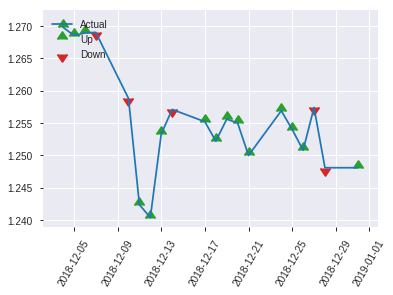


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.17794270036057772
RMSE: 0.421832550143511
LogLoss: 0.5459770568098432
Mean Per-Class Error: 0.21285434995112418
AUC: 0.8433528836754643
pr_auc: 0.8281018035482087
Gini: 0.6867057673509287
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5579606628985987: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      88   44   0.3333   (44.0/132.0)
1      17   107  0.1371   (17.0/124.0)
Total  105  151  0.2383   (61.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.557961     0.778182  150
max f2                       0.413329     0.865522  202
max f0point5                 0.605353     0.80036   107
max accuracy                 0.605353     0.789062  107
max precision                0.999369     1         0
max recall                   0.0335024    1         239
max specificity              0.999369     1         0
max absolute_mcc             0.605353     0.580654  107
max min_per_class_accuracy   0.57857      0.742424  126
max mean_per_class_accuracy  0.603436     0.787146  109

Gains/Lift Table: Avg response rate: 48.44 %, avg score: 56.97 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.999232           2.06452    2.06452            1                0.999324   1                           0.999324            0.0241935       0.0241935                  106.452   106.452
    2        0.0234375                   0.999134           2.06452    2.06452            1                0.999173   1                           0.999248            0.0241935       0.0483871                  106.452   106.452
    3        0.03125                     0.999001           2.06452    2.06452            1                0.999056   1                           0.9992              0.016129        0.0645161                  106.452   106.452
    4        0.0429688                   0.998763           2.06452    2.06452            1                0.998882   1                           0.999113            0.0241935       0.0887097                  106.452   106.452
    5        0.0507812                   0.998044           2.06452    2.06452            1                0.998522   1                           0.999022            0.016129        0.104839                   106.452   106.452
    6        0.101562                    0.992098           1.7469     1.90571            0.846154         0.995069   0.923077                    0.997046            0.0887097       0.193548                   74.6898   90.5707
    7        0.152344                    0.98322            1.90571    1.90571            0.923077         0.988743   0.923077                    0.994278            0.0967742       0.290323                   90.5707   90.5707
    8        0.203125                    0.778195           1.90571    1.90571            0.923077         0.903685   0.923077                    0.97163             0.0967742       0.387097                   90.5707   90.5707
    9        0.300781                    0.651299           1.32129    1.71596            0.64             0.691858   0.831169                    0.880795            0.129032        0.516129                   32.129    71.5961
    10       0.402344                    0.613325           1.66749    1.70373            0.807692         0.629913   0.825243                    0.817465            0.169355        0.685484                   66.7494   70.3727
    11       0.5                         0.576963           0.743226   1.51613            0.36             0.596556   0.734375                    0.774319            0.0725806       0.758065                   -25.6774  51.6129
    12       0.601562                    0.555982           1.03226    1.43444            0.5              0.564774   0.694805                    0.738941            0.104839        0.862903                   3.22581   43.4437
    13       0.699219                    0.527246           0.495484   1.3033             0.24             0.53837    0.631285                    0.710929            0.0483871       0.91129                    -50.4516  30.3298
    14       0.800781                    0.398227           0.635236   1.21857            0.307692         0.489579   0.590244                    0.682855            0.0645161       0.975806                   -36.4764  21.8568
    15       0.898438                    0.0483924          0.0825806  1.09509            0.04             0.204411   0.530435                    0.63085             0.00806452      0.983871                   -91.7419  9.50912
    16       1                           0.00980634         0.158809   1                  0.0769231        0.0284359  0.484375 

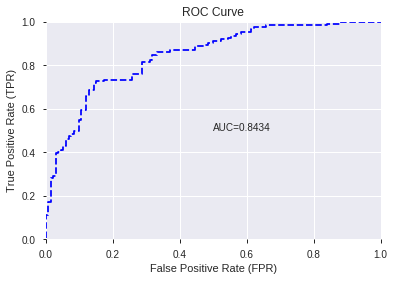

This function is available for GLM models only


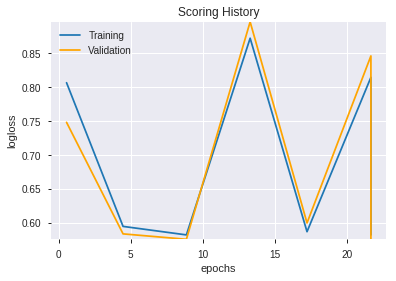

--2019-08-22 13:08:15--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.186.179
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.186.179|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


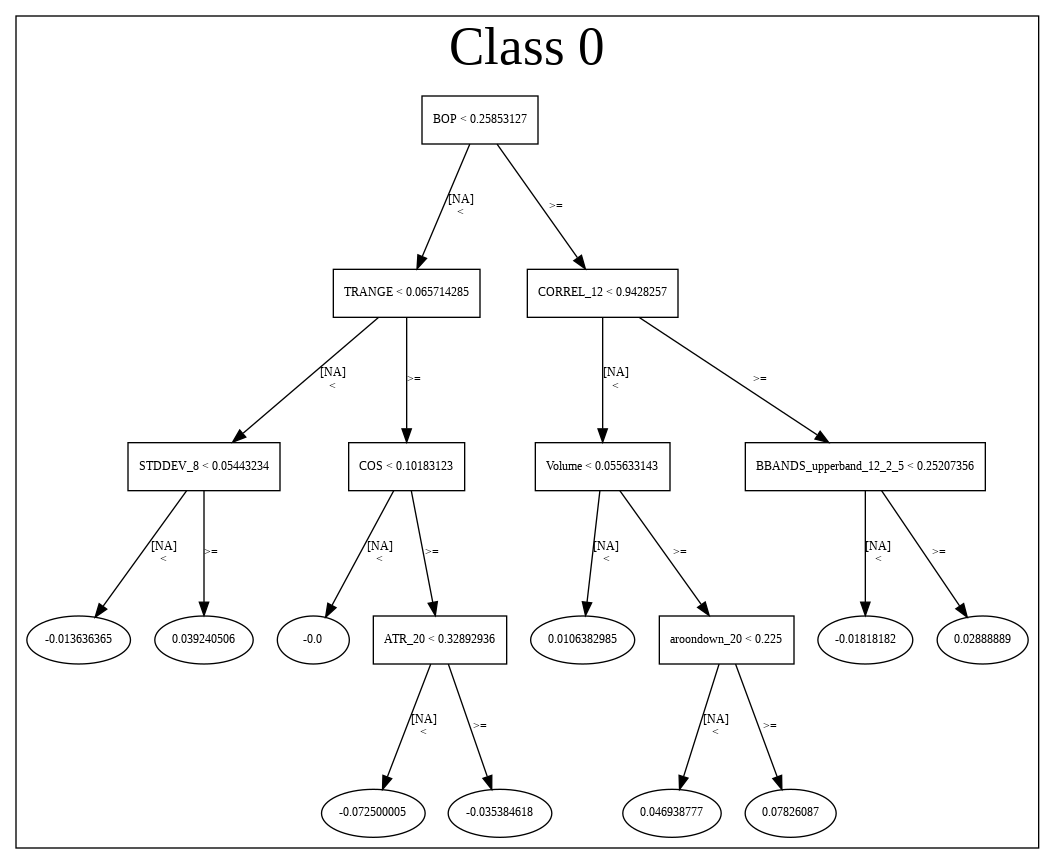

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190822_130035_model_7',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190822_130035_model_7',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_92dd',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['STOCHF_fastk',
 'CDLGRAVESTONEDOJI',
 'CDLTAKURI',
 'ULTOSC',
 'CDLCLOSINGMARUBOZU',
 'CDLINVERTEDHAMMER',
 'CDLDRAGONFLYDOJI',
 'CCI_8',
 'CDLBELTHOLD',
 'MINUS_DI_8',
 'CDLSHOOTINGSTAR',
 'CCI_12',
 'CDLHANGINGMAN',
 'CDLHAMMER']

In [47]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id      auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190822_130827_model_1  0.84763  0.487409              0.225073  0.402773  0.162226

variable  relative_importance  scaled_importance  percentage
0            CDLTAKURI             1.806790           1.000000    0.257881
1     CDLDRAGONFLYDOJI             1.383753           0.765863    0.197502
2                CCI_8             1.178029           0.652001    0.168139
3         STOCHF_fastk             0.956689           0.529497    0.136547
4    CDLGRAVESTONEDOJI             0.569981           0.315466    0.081353
5               CCI_12             0.312290           0.172842    0.044573
6               ULTOSC             0.187934           0.104016    0.026824
7           MINUS_DI_8             0.164510           0.091051    0.023480
8    CDLINVERTEDHAMMER             0.147383           0.081572    0.021036
9   CDLCLOSINGMARUBOZU             0.094054           0.052056    0.013424
10       CDLHANGINGMAN             0.075342           0.041700    0.010754
11         CDLBELTHOLD             0.068569           0.037951    0.009787
12           CDLHAMMER             0.055957           0.030970    0.007987
13     CDLSHOOTINGSTAR             0.005010           0.002773    0.000715

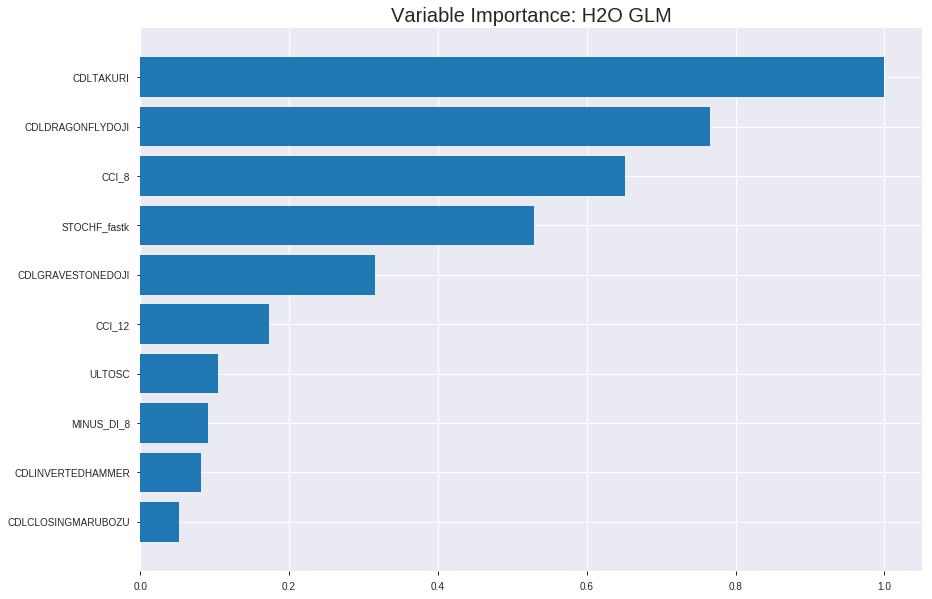

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190822_130827_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.19092013328869964
RMSE: 0.43694408485377123
LogLoss: 0.5568262839651458
Null degrees of freedom: 1786
Residual degrees of freedom: 1772
Null deviance: 2477.2806029937074
Residual deviance: 1990.0971388914309
AIC: 2020.0971388914309
AUC: 0.7751863264564779
pr_auc: 0.7802979513480582
Gini: 0.5503726529129558
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35086745914583456: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      368  522   0.5865   (522.0/890.0)
1      78   819   0.087    (78.0/897.0)
Total  446  1341  0.3358   (600.0/1787.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.350867     0.731903  274
max f2                       0.178608     0.853021  342
max f0point5                 0.561928     0.700857  165
max accuracy                 0.47045      0.692222  213
max precision                0.995563     1         0
max recall                   0.0519008    1         387
max specificity              0.995563     1         0
max absolute_mcc             0.404447     0.386529  246
max min_per_class_accuracy   0.494358     0.687848  200
max mean_per_class_accuracy  0.47045      0.692042  213

Gains/Lift Table: Avg response rate: 50.20 %, avg score: 50.20 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100727                   0.977008           1.88152   1.88152            0.944444         0.984432   0.944444                    0.984432            0.0189521       0.0189521                  88.1519   88.1519
    2        0.0201455                   0.967797           1.9922    1.93686            1                0.97336    0.972222                    0.978896            0.0200669       0.039019                   99.2196   93.6857
    3        0.0302182                   0.961524           1.88152   1.91841            0.944444         0.964435   0.962963                    0.974076            0.0189521       0.057971                   88.1519   91.8411
    4        0.040291                    0.952415           1.9922    1.93686            1                0.956684   0.972222                    0.969728            0.0200669       0.0780379                  99.2196   93.6857
    5        0.0503637                   0.944563           1.77084   1.90365            0.888889         0.948357   0.955556                    0.965454            0.0178372       0.0958751                  77.0841   90.3654
    6        0.100168                    0.889972           1.90266   1.90316            0.955056         0.922503   0.955307                    0.944098            0.0947603       0.190635                   90.2659   90.316
    7        0.149972                    0.770499           1.54451   1.78406            0.775281         0.830809   0.895522                    0.906476            0.0769231       0.267559                   54.4512   78.4056
    8        0.200336                    0.696359           1.50521   1.71396            0.755556         0.729408   0.860335                    0.861962            0.0758082       0.343367                   50.5215   71.3957
    9        0.299944                    0.611231           1.26471   1.56477            0.634831         0.650207   0.785448                    0.79164             0.125975        0.469342                   26.4709   56.4766
    10       0.400112                    0.551145           1.16861   1.46559            0.586592         0.580248   0.735664                    0.738718            0.117057        0.586399                   16.8607   46.5588
    11       0.50028                     0.49333            1.01279   1.37493            0.50838          0.52231    0.690157                    0.695388            0.101449        0.687848                   1.27925   37.4927
    12       0.599888                    0.444309           0.973714  1.30831            0.488764         0.468054   0.656716                    0.657641            0.09699         0.784838                   -2.62861  30.8308
    13       0.700056                    0.381182           0.879237  1.24691            0.441341         0.409841   0.625899                    0.622184            0.0880713       0.87291                    -12.0763  24.6914
    14       0.799664                    0.306717           0.660335  1.17385            0.331461         0.348242   0.589223                    0.588061            0.0657748       0.938685                   -33.9665  17.3848
    15       0.899832                    0.148845           0.445184  1.09273            0.223464         0.230346   0.548507                    0.548241            0.0445931       0.983278                   -55.4816  9.27345
    16       1                           0.0024684          0.166944  1                  0.0837989        0.0861874  0.501959                    



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.17680970270513927
RMSE: 0.4204874584397723
LogLoss: 0.5295816080133027
Null degrees of freedom: 509
Residual degrees of freedom: 495
Null deviance: 706.9709434262809
Residual deviance: 540.1732401735687
AIC: 570.1732401735687
AUC: 0.8187830687830688
pr_auc: 0.8120163057190649
Gini: 0.6375661375661377
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.43304923418408886: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      168  84   0.3333   (84.0/252.0)
1      42   216  0.1628   (42.0/258.0)
Total  210  300  0.2471   (126.0/510.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.433049     0.774194  223
max f2                       0.19678      0.859589  324
max f0point5                 0.511505     0.761421  173
max accuracy                 0.440767     0.752941  218
max precision                0.978451     1         0
max recall                   0.0320788    1         395
max specificity              0.978451     1         0
max absolute_mcc             0.433049     0.511875  223
max min_per_class_accuracy   0.4865       0.74031   191
max mean_per_class_accuracy  0.440767     0.752076  218

Gains/Lift Table: Avg response rate: 50.59 %, avg score: 49.11 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117647                   0.963973           1.97674   1.97674            1                0.971034   1                           0.971034            0.0232558       0.0232558                  97.6744   97.6744
    2        0.0215686                   0.960966           1.97674   1.97674            1                0.962927   1                           0.967349            0.0193798       0.0426357                  97.6744   97.6744
    3        0.0313725                   0.949939           1.97674   1.97674            1                0.955459   1                           0.963634            0.0193798       0.0620155                  97.6744   97.6744
    4        0.0411765                   0.947278           1.18605   1.78848            0.6              0.947716   0.904762                    0.959844            0.0116279       0.0736434                  18.6047   78.8483
    5        0.0509804                   0.945055           1.5814    1.74866            0.8              0.945733   0.884615                    0.95713             0.0155039       0.0891473                  58.1395   74.8658
    6        0.1                         0.924561           1.89767   1.82171            0.96             0.93426    0.921569                    0.94592             0.0930233       0.182171                   89.7674   82.1705
    7        0.15098                     0.845751           1.74866   1.79704            0.884615         0.895599   0.909091                    0.928928            0.0891473       0.271318                   74.8658   79.704
    8        0.2                         0.701764           1.42326   1.70543            0.72             0.759824   0.862745                    0.887481            0.0697674       0.341085                   42.3256   70.5426
    9        0.3                         0.609775           1.58915   1.66667            0.803922         0.650499   0.843137                    0.808487            0.158915        0.5                        58.9147   66.6667
    10       0.4                         0.547232           1.27907   1.56977            0.647059         0.571313   0.794118                    0.749194            0.127907        0.627907                   27.907    56.9767
    11       0.5                         0.486471           1.08527   1.47287            0.54902          0.511403   0.745098                    0.701635            0.108527        0.736434                   8.52713   47.2868
    12       0.6                         0.427733           1.08527   1.40827            0.54902          0.454906   0.712418                    0.660514            0.108527        0.844961                   8.52713   40.8269
    13       0.7                         0.357518           0.503876  1.27907            0.254902         0.390923   0.647059                    0.622001            0.0503876       0.895349                   -49.6124  27.907
    14       0.8                         0.255527           0.503876  1.18217            0.254902         0.312412   0.598039                    0.583302            0.0503876       0.945736                   -49.6124  18.2171
    15       0.9                         0.10942            0.348837  1.08958            0.176471         0.176326   0.551198                    0.538083            0.0348837       0.98062                    -65.1163  8.9578
    16       1                           0.0200837          0.193798  1                  0.0980392        0.0686306  0.505882                    0.


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-22 13:08:27  0.000 sec   2            .16E2     15            1.372090475228268   1.3681939499763376
     2019-08-22 13:08:27  0.028 sec   4            .96E1     15            1.3642188366721222  1.3582124339008999
     2019-08-22 13:08:27  0.052 sec   6            .6E1      15            1.3526270903147795  1.3435387049775545
     2019-08-22 13:08:27  0.072 sec   8            .37E1     15            1.3363500486737543  1.3229872827399296
     2019-08-22 13:08:27  0.094 sec   10           .23E1     15            1.3149386231665645  1.2960544572576518
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-22 13:08:28  0.351 sec   47           .1E-3     15            1.1137972426887643  1.0592842180328774
     2019-08-22 13:08:28  0.355 sec   48           .65E-4    15            1.1137383210666318  1.059234247792905
     2019-08-22 13:08:28  0.359 sec   49           .4E-4     15            1.1136980905998806  1.0592006615113156
     2019-08-22 13:08:28  0.364 sec   50           .25E-4    15            1.113670887216923   1.0591771431285286
     2019-08-22 13:08:28  0.368 sec   51           .16E-4    15            1.1136525679302918  1.0591632160266053


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7734375)

('F1', 0.7786259541984734)

('auc', 0.8476295210166178)

('logloss', 0.48740875837577136)

('mean_per_class_error', 0.22507331378299122)

('rmse', 0.4027726357219341)

('mse', 0.16222579608639381)

glm prediction progress: |████████████████████████████████████████████████| 100%


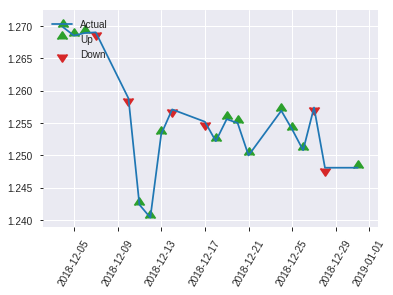


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.16222579608639381
RMSE: 0.4027726357219341
LogLoss: 0.48740875837577136
Null degrees of freedom: 255
Residual degrees of freedom: 241
Null deviance: 354.9579598113329
Residual deviance: 249.55328428839493
AIC: 279.55328428839493
AUC: 0.8476295210166178
pr_auc: 0.8427108159369877
Gini: 0.6952590420332356
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4938996333808315: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      96   36   0.2727   (36.0/132.0)
1      22   102  0.1774   (22.0/124.0)
Total  118  138  0.2266   (58.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.4939       0.778626  137
max f2                       0.26725      0.858369  202
max f0point5                 0.680824     0.784314  70
max accuracy                 0.509394     0.773438  129
max precision                0.989463     1         0
max recall                   0.064922     1         246
max specificity              0.989463     1         0
max absolute_mcc             0.4939       0.55127   137
max min_per_class_accuracy   0.512541     0.757576  125
max mean_per_class_accuracy  0.4939       0.774927  137

Gains/Lift Table: Avg response rate: 48.44 %, avg score: 51.90 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.975096           2.06452   2.06452            1                0.982675   1                           0.982675            0.0241935       0.0241935                  106.452   106.452
    2        0.0234375                   0.971419           2.06452   2.06452            1                0.972612   1                           0.977643            0.0241935       0.0483871                  106.452   106.452
    3        0.03125                     0.967777           2.06452   2.06452            1                0.969203   1                           0.975533            0.016129        0.0645161                  106.452   106.452
    4        0.0429688                   0.966458           2.06452   2.06452            1                0.967215   1                           0.973265            0.0241935       0.0887097                  106.452   106.452
    5        0.0507812                   0.959433           2.06452   2.06452            1                0.96355    1                           0.97177             0.016129        0.104839                   106.452   106.452
    6        0.101562                    0.939437           2.06452   2.06452            1                0.950042   1                           0.960906            0.104839        0.209677                   106.452   106.452
    7        0.152344                    0.889251           1.7469    1.95864            0.846154         0.917879   0.948718                    0.946564            0.0887097       0.298387                   74.6898   95.8644
    8        0.203125                    0.802018           1.7469    1.90571            0.846154         0.862071   0.923077                    0.925441            0.0887097       0.387097                   74.6898   90.5707
    9        0.300781                    0.666799           1.56903   1.7964             0.76             0.707895   0.87013                     0.854809            0.153226        0.540323                   56.9032   79.6397
    10       0.402344                    0.573682           1.11166   1.62355            0.538462         0.613114   0.786408                    0.793799            0.112903        0.653226                   11.1663   62.3552
    11       0.5                         0.510963           1.23871   1.54839            0.6              0.539887   0.75                        0.744207            0.120968        0.774194                   23.871    54.8387
    12       0.601562                    0.451752           0.794045  1.42103            0.384615         0.480162   0.688312                    0.699628            0.0806452       0.854839                   -20.5955  42.1031
    13       0.699219                    0.388817           0.660645  1.31483            0.32             0.420451   0.636872                    0.660636            0.0645161       0.919355                   -33.9355  31.4832
    14       0.800781                    0.256882           0.476427  1.2085             0.230769         0.317916   0.585366                    0.617169            0.0483871       0.967742                   -52.3573  20.8497
    15       0.898438                    0.108586           0.165161  1.09509            0.08             0.179124   0.530435                    0.569556            0.016129        0.983871                   -83.4839  9.50912
    16       1                           0.0270018          0.158809  1                  0.0769231        0.0718075  0.484375                   

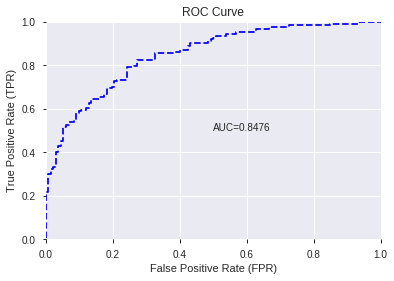

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


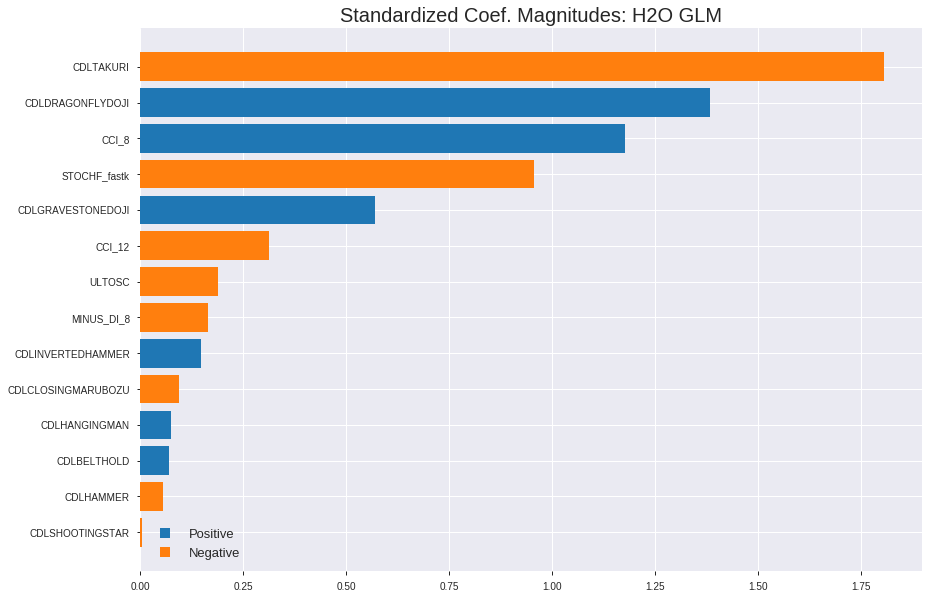

'log_likelihood'
--2019-08-22 13:08:33--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.185.67
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.185.67|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


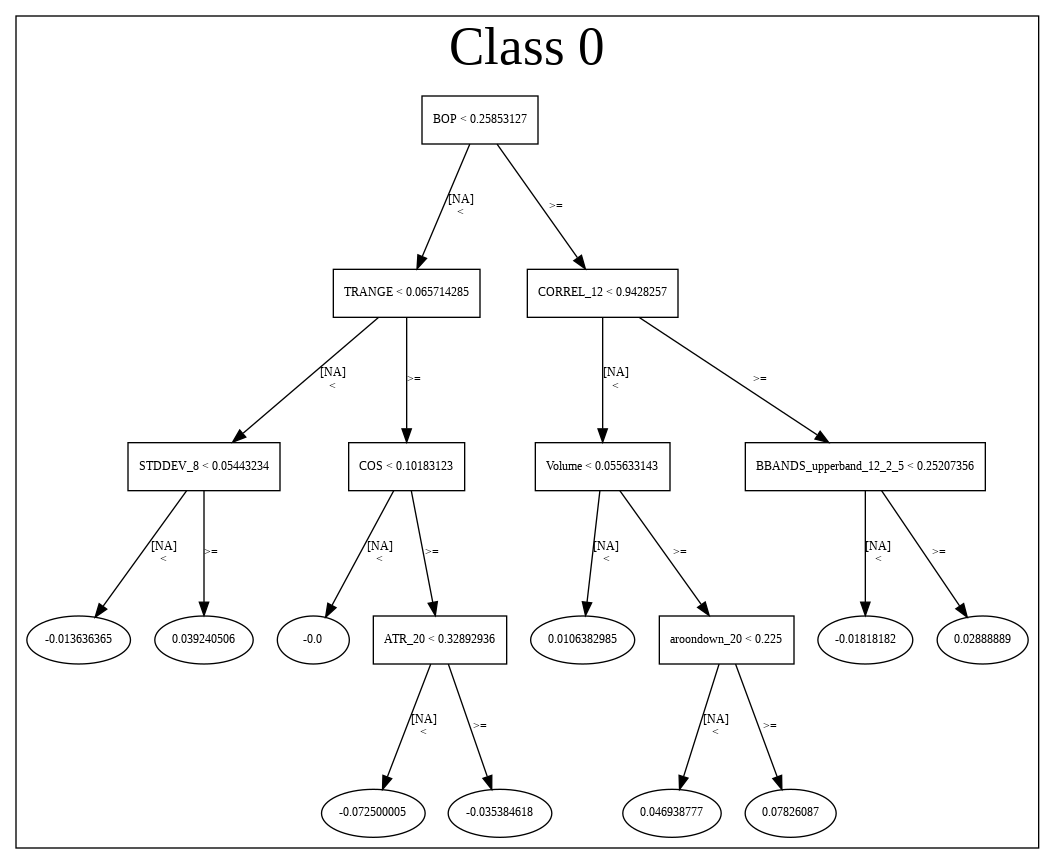

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190822_130827_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190822_130827_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_92dd',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['CDLTAKURI',
 'CDLDRAGONFLYDOJI',
 'CCI_8',
 'STOCHF_fastk',
 'CDLGRAVESTONEDOJI',
 'CCI_12',
 'ULTOSC',
 'MINUS_DI_8',
 'CDLINVERTEDHAMMER',
 'CDLCLOSINGMARUBOZU',
 'CDLHANGINGMAN',
 'CDLBELTHOLD',
 'CDLHAMMER',
 'CDLSHOOTINGSTAR']

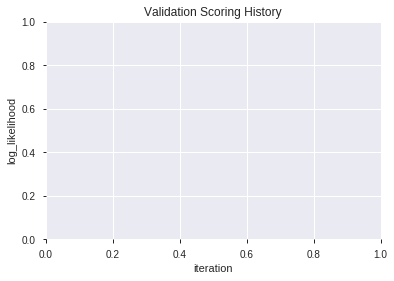

In [48]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190822_130842_model_4  0.838221  0.507473              0.244013  0.410069  0.168157
1  XGBoost_grid_1_AutoML_20190822_130842_model_2  0.833456  0.510142              0.257942  0.412682  0.170306
2               XGBoost_1_AutoML_20190822_130842  0.829973  0.513674              0.244990  0.414314  0.171656
3               XGBoost_2_AutoML_20190822_130842  0.827590  0.515657              0.244746  0.414770  0.172034
4  XGBoost_grid_1_AutoML_20190822_130842_model_6  0.825819  0.515433              0.262708  0.416394  0.173384
5               XGBoost_3_AutoML_20190822_130842  0.825635  0.514027              0.252322  0.415316  0.172487
6  XGBoost_grid_1_AutoML_20190822_130842_model_3  0.823558  0.517412              0.269795  0.417004  0.173893
7  XGBoost_grid_1_AutoML_20190822_130842_model_7  0.823375  0.519632              0.278715  0.417697  0.174470
8  XGBoost_grid_1_AutoML_20190822_130842_model_5  0.820748  0.521047              0.279203  0.418514  0.175154
9  XGBoost_grid_1_AutoML_20190822_130842_model_1  0.818426  0.521894              0.269306  0.418744  0.175346

variable  relative_importance  scaled_importance  percentage
0  CDLGRAVESTONEDOJI          1169.019165           1.000000    0.243543
1       STOCHF_fastk          1021.274475           0.873617    0.212763
2              CCI_8           856.781555           0.732906    0.178494
3          CDLTAKURI           595.701782           0.509574    0.124103
4             ULTOSC           554.280457           0.474141    0.115474
5         MINUS_DI_8           345.646088           0.295672    0.072009
6             CCI_12           183.378128           0.156865    0.038203
7   CDLDRAGONFLYDOJI            73.965424           0.063271    0.015409

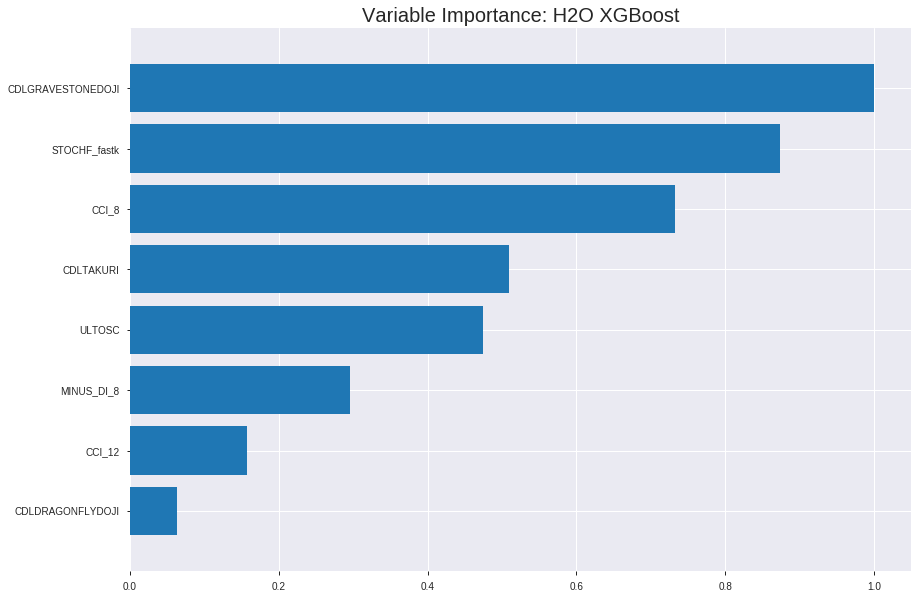

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190822_130842_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.17770062320141167
RMSE: 0.42154551735418994
LogLoss: 0.5303622625268738
Mean Per-Class Error: 0.27305249708767054
AUC: 0.8140831485726454
pr_auc: 0.8181141157789334
Gini: 0.6281662971452908
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.38766180276870726: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      497  393   0.4416   (393.0/890.0)
1      118  779   0.1315   (118.0/897.0)
Total  615  1172  0.286    (511.0/1787.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.387662     0.753021  259
max f2                       0.223555     0.859574  340
max f0point5                 0.618608     0.749171  139
max accuracy                 0.510878     0.726917  195
max precision                0.92942      1         0
max recall                   0.120222     1         389
max specificity              0.92942      1         0
max absolute_mcc             0.618608     0.457207  139
max min_per_class_accuracy   0.502221     0.726867  199
max mean_per_class_accuracy  0.510878     0.726948  195

Gains/Lift Table: Avg response rate: 50.20 %, avg score: 50.44 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100727                   0.912336           1.9922    1.9922             1                0.919847  1                           0.919847            0.0200669       0.0200669                  99.2196   99.2196
    2        0.0201455                   0.903668           1.9922    1.9922             1                0.907426  1                           0.913637            0.0200669       0.0401338                  99.2196   99.2196
    3        0.0302182                   0.895121           1.9922    1.9922             1                0.899432  1                           0.908902            0.0200669       0.0602007                  99.2196   99.2196
    4        0.040291                    0.884339           1.88152   1.96453            0.944444         0.888213  0.986111                    0.90373             0.0189521       0.0791527                  88.1519   96.4527
    5        0.0503637                   0.876678           1.88152   1.94793            0.944444         0.880023  0.977778                    0.898988            0.0189521       0.0981048                  88.1519   94.7925
    6        0.100168                    0.839103           1.83551   1.89203            0.921348         0.859255  0.949721                    0.879232            0.0914158       0.189521                   83.5507   89.203
    7        0.149972                    0.777667           1.74597   1.84352            0.876404         0.816972  0.925373                    0.858556            0.0869565       0.276477                   74.597    84.3525
    8        0.200336                    0.718325           1.66016   1.79743            0.833333         0.743969  0.902235                    0.829749            0.083612        0.360089                   66.0164   79.7428
    9        0.299944                    0.644183           1.46617   1.68742            0.735955         0.677026  0.847015                    0.779032            0.146042        0.506132                   46.6167   68.742
    10       0.400112                    0.583631           1.10183   1.54082            0.553073         0.611887  0.773427                    0.737187            0.110368        0.616499                   10.1829   54.0817
    11       0.50028                     0.502063           1.0907    1.45069            0.547486         0.544981  0.728188                    0.698703            0.109253        0.725753                   9.06996   45.0693
    12       0.599888                    0.423597           0.884177  1.35663            0.44382          0.464784  0.68097                     0.659862            0.0880713       0.813824                   -11.5823  35.6626
    13       0.700056                    0.359204           0.790201  1.27558            0.396648         0.390554  0.640288                    0.621328            0.0791527       0.892977                   -20.9799  27.5579
    14       0.799664                    0.284769           0.63795   1.19615            0.320225         0.324415  0.60042                     0.584344            0.0635452       0.956522                   -36.205   19.6154
    15       0.899832                    0.179136           0.333888  1.10017            0.167598         0.22771   0.552239                    0.544644            0.0334448       0.989967                   -66.6112  10.0168
    16       1                           0.091206           0.100166  1                  0.0502793        0.142873  0.501959                    0.504399           



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.17550631270094671
RMSE: 0.41893473561038924
LogLoss: 0.527015289327084
Mean Per-Class Error: 0.24561646363971945
AUC: 0.8176602682416635
pr_auc: 0.8057922554669009
Gini: 0.635320536483327
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4228222668170929: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      171  81   0.3214   (81.0/252.0)
1      47   211  0.1822   (47.0/258.0)
Total  218  292  0.251    (128.0/510.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.422822     0.767273  229
max f2                       0.198426     0.859589  337
max f0point5                 0.517317     0.757956  181
max accuracy                 0.447926     0.754902  220
max precision                0.927315     1         0
max recall                   0.127486     1         383
max specificity              0.927315     1         0
max absolute_mcc             0.447926     0.511     220
max min_per_class_accuracy   0.475431     0.742063  202
max mean_per_class_accuracy  0.447926     0.754384  220

Gains/Lift Table: Avg response rate: 50.59 %, avg score: 49.49 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0137255                   0.910631           1.97674   1.97674            1                0.917821  1                           0.917821            0.0271318       0.0271318                  97.6744   97.6744
    2        0.0215686                   0.905735           1.97674   1.97674            1                0.907589  1                           0.9141              0.0155039       0.0426357                  97.6744   97.6744
    3        0.0313725                   0.901845           1.5814    1.8532             0.8              0.903262  0.9375                      0.910713            0.0155039       0.0581395                  58.1395   85.3198
    4        0.0411765                   0.891967           1.97674   1.88261            1                0.896258  0.952381                    0.907271            0.0193798       0.0775194                  97.6744   88.2614
    5        0.0509804                   0.881404           1.18605   1.74866            0.6              0.88576   0.884615                    0.903135            0.0116279       0.0891473                  18.6047   74.8658
    6        0.1                         0.854149           1.73953   1.74419            0.88             0.866796  0.882353                    0.885321            0.0852713       0.174419                   73.9535   74.4186
    7        0.15098                     0.831738           1.97674   1.82271            1                0.84288   0.922078                    0.87099             0.100775        0.275194                   97.6744   82.2712
    8        0.2                         0.736715           1.5814    1.76357            0.8              0.778592  0.892157                    0.848344            0.0775194       0.352713                   58.1395   76.3566
    9        0.3                         0.639349           1.43411   1.65375            0.72549          0.679915  0.836601                    0.792201            0.143411        0.496124                   43.4109   65.3747
    10       0.4                         0.576231           1.16279   1.53101            0.588235         0.612678  0.77451                     0.74732             0.116279        0.612403                   16.2791   53.1008
    11       0.5                         0.475805           1.27907   1.48062            0.647059         0.528615  0.74902                     0.703579            0.127907        0.74031                    27.907    48.062
    12       0.6                         0.403634           0.930233  1.38889            0.470588         0.440953  0.702614                    0.659808            0.0930233       0.833333                   -6.97674  38.8889
    13       0.7                         0.341608           0.658915  1.28461            0.333333         0.372824  0.64986                     0.618811            0.0658915       0.899225                   -34.1085  28.4607
    14       0.8                         0.23418            0.503876  1.18702            0.254902         0.287555  0.60049                     0.577404            0.0503876       0.949612                   -49.6124  18.7016
    15       0.9                         0.16207            0.348837  1.09388            0.176471         0.195068  0.553377                    0.534922            0.0348837       0.984496                   -65.1163  9.38846
    16       1                           0.0985099          0.155039  1                  0.0784314        0.134232  0.505882                    0.494853          


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 13:08:51  4.078 sec   0                  0.5              0.693147            0.5             0                  1                0.498041                         0.5                0.693147              0.5               0                    1                  0.494118
    2019-08-22 13:08:51  4.134 sec   5                  0.478586         0.650905            0.774263        0.566198           1.82994          0.345271                         0.473889           0.641872              0.812508          0.559677             1.82069            0.264706
    2019-08-22 13:08:51  4.173 sec   10                 0.463892         0.621851            0.781796        0.573409           1.82994          0.343593                         0.456846           0.608446              0.809316          0.557605             1.82069            0.296078
    2019-08-22 13:08:51  4.220 sec   15                 0.453754         0.601232            0.786439        0.575925           1.82994          0.309457                         0.444311           0.583311              0.814946          0.559616             1.82069            0.264706
    2019-08-22 13:08:51  4.264 sec   20                 0.447016         0.586931            0.788783        0.578421           1.82994          0.326245                         0.437206           0.568138              0.813615          0.557907             1.82069            0.264706
    2019-08-22 13:08:51  4.313 sec   25                 0.441208         0.574436            0.792537        0.581249           1.82994          0.32009                          0.431528           0.555797              0.813723          0.558901             1.82069            0.266667
    2019-08-22 13:08:51  4.361 sec   30                 0.437415         0.565962            0.795549        0.761685           1.82618          0.321209                         0.428388           0.548571              0.813154          0.777412             1.75711            0.264706
    2019-08-22 13:08:51  4.412 sec   35                 0.434178         0.558805            0.79779         0.795676           1.9922           0.310017                         0.425572           0.542405              0.814776          0.803464             1.64729            0.264706
    2019-08-22 13:08:51  4.477 sec   40                 0.431347         0.55247             0.800372        0.801752           1.9922           0.302742                         0.423405           0.537677              0.815445          0.806661             1.97674            0.266667
    2019-08-22 13:08:51  4.544 sec   45                 0.429338         0.547869            0.802453        0.804322           1.9922           0.308898                         0.422046           0.534461              0.816768          0.810372             1.97674            0.278431
    2019-08-22 13:08:51  4.611 sec   50                 0.427793         0.544385            0.804756        0.809395           1.9922           0.293788                         0.421248           0.532473              0.817145          0.811216             1.97674            0.252941
    2019-08-22 13:08:52  4.671 sec   55                 0.426481         0.541328            0.806259        0.800991           1.9922           0.296027                         0.420552           0.530736              0.817091          0

Variable Importances: 


variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  ------------
CDLGRAVESTONEDOJI  1169.02                1                    0.243543
STOCHF_fastk       1021.27                0.873617             0.212763
CCI_8              856.782                0.732906             0.178494
CDLTAKURI          595.702                0.509574             0.124103
ULTOSC             554.28                 0.474141             0.115474
MINUS_DI_8         345.646                0.295672             0.0720089
CCI_12             183.378                0.156865             0.0382034
CDLDRAGONFLYDOJI   73.9654                0.0632714            0.0154093

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.76953125)

('F1', 0.7640449438202247)

('auc', 0.8382209188660801)

('logloss', 0.5074730654400637)

('mean_per_class_error', 0.23570381231671556)

('rmse', 0.4100694704076163)

('mse', 0.16815697056038292)

xgboost prediction progress: |████████████████████████████████████████████| 100%


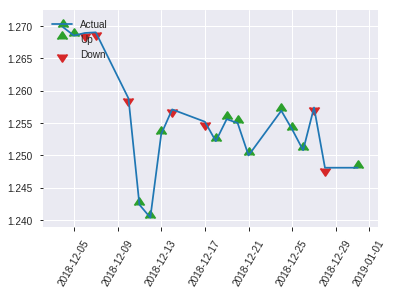


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.16815697056038292
RMSE: 0.4100694704076163
LogLoss: 0.5074730654400637
Mean Per-Class Error: 0.23570381231671556
AUC: 0.8382209188660801
pr_auc: 0.8264406468163437
Gini: 0.6764418377321602
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48690852522850037: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      91   41   0.3106   (41.0/132.0)
1      22   102  0.1774   (22.0/124.0)
Total  113  143  0.2461   (63.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.486909     0.764045  141
max f2                       0.250518     0.857143  201
max f0point5                 0.696587     0.811404  81
max accuracy                 0.696587     0.769531  81
max precision                0.922817     1         0
max recall                   0.146292     1         240
max specificity              0.922817     1         0
max absolute_mcc             0.696587     0.56436   81
max min_per_class_accuracy   0.579802     0.757576  124
max mean_per_class_accuracy  0.696587     0.764296  81

Gains/Lift Table: Avg response rate: 48.44 %, avg score: 52.86 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.015625                    0.914584           2.06452    2.06452            1                0.916893  1                           0.916893            0.0322581       0.0322581                  106.452   106.452
    2        0.0234375                   0.912355           2.06452    2.06452            1                0.912968  1                           0.915584            0.016129        0.0483871                  106.452   106.452
    3        0.03125                     0.903699           2.06452    2.06452            1                0.908001  1                           0.913689            0.016129        0.0645161                  106.452   106.452
    4        0.0429688                   0.896823           2.06452    2.06452            1                0.899515  1                           0.909823            0.0241935       0.0887097                  106.452   106.452
    5        0.0507812                   0.890494           1.03226    1.90571            0.5              0.892734  0.923077                    0.907194            0.00806452      0.0967742                  3.22581   90.5707
    6        0.101562                    0.861793           1.90571    1.90571            0.923077         0.875279  0.923077                    0.891236            0.0967742       0.193548                   90.5707   90.5707
    7        0.152344                    0.836866           2.06452    1.95864            1                0.849254  0.948718                    0.877242            0.104839        0.298387                   106.452   95.8644
    8        0.203125                    0.804018           1.42928    1.8263             0.692308         0.820866  0.884615                    0.863148            0.0725806       0.370968                   42.928    82.6303
    9        0.300781                    0.712271           1.81677    1.82321            0.88             0.750301  0.883117                    0.826509            0.177419        0.548387                   81.6774   82.3209
    10       0.402344                    0.641329           0.952854   1.60351            0.461538         0.678349  0.776699                    0.78911             0.0967742       0.645161                   -4.71464  60.3508
    11       0.5                         0.550148           1.15613    1.51613            0.56             0.608892  0.734375                    0.753911            0.112903        0.758065                   15.6129   51.6129
    12       0.601562                    0.439609           0.794045   1.39422            0.384615         0.495244  0.675325                    0.71024             0.0806452       0.83871                    -20.5955  39.4219
    13       0.699219                    0.339972           0.743226   1.3033             0.36             0.391398  0.631285                    0.665709            0.0725806       0.91129                    -25.6774  30.3298
    14       0.800781                    0.249173           0.555831   1.2085             0.269231         0.296661  0.585366                    0.618903            0.0564516       0.967742                   -44.4169  20.8497
    15       0.898438                    0.166551           0.247742   1.10407            0.12             0.196956  0.534783                    0.573039            0.0241935       0.991935                   -75.2258  10.4067
    16       1                           0.0994355          0.0794045  1                  0.0384615        0.135389  0.484375                   

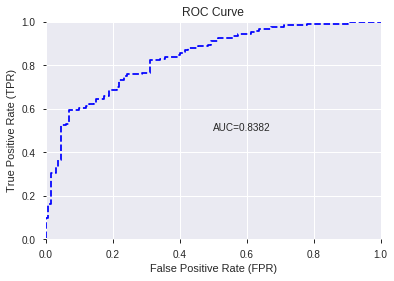

This function is available for GLM models only


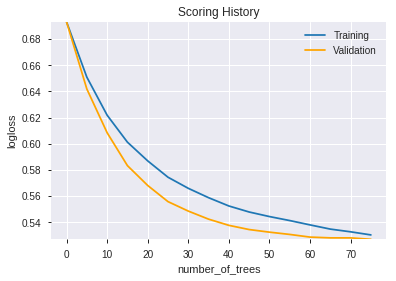

--2019-08-22 13:09:05--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.186.123
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.186.123|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at he

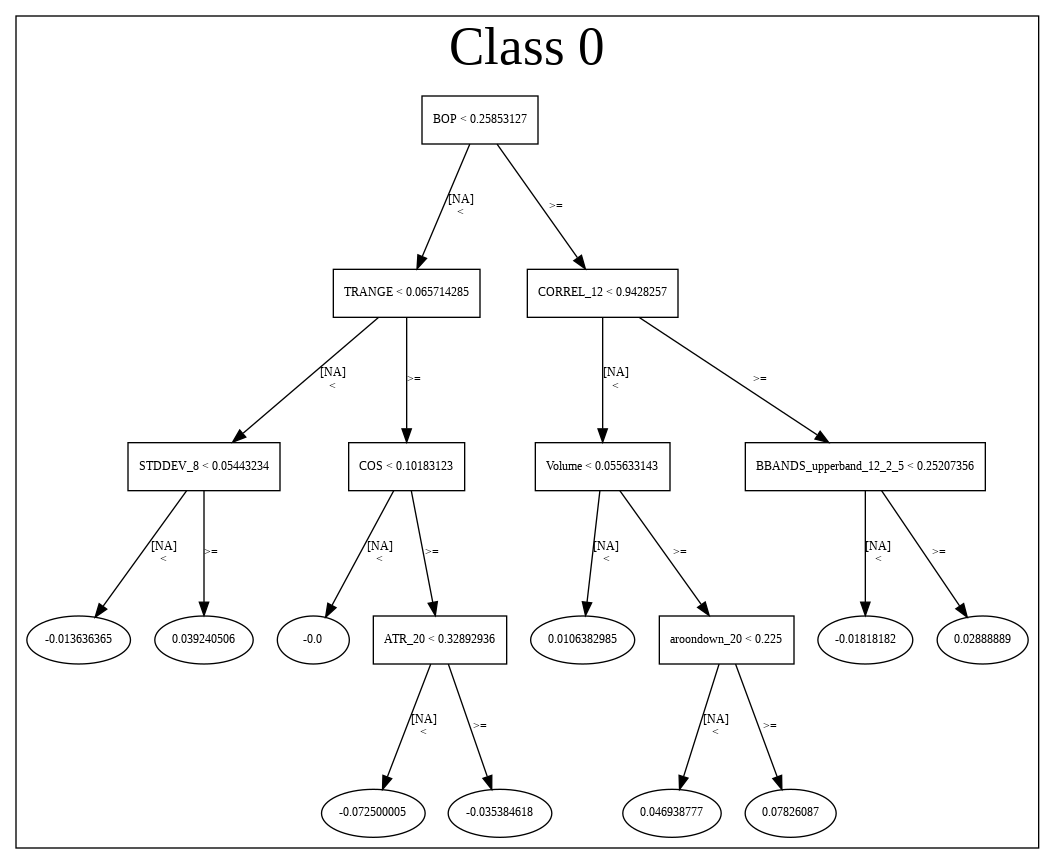

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190822_130842_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190822_130842_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_92dd',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['CDLGRAVESTONEDOJI',
 'STOCHF_fastk',
 'CCI_8',
 'CDLTAKURI',
 'ULTOSC',
 'MINUS_DI_8',
 'CCI_12',
 'CDLDRAGONFLYDOJI']

In [49]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [50]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

51

['BBANDS_upperband_14_2_5',
 'BBANDS_middleband_14_3_3',
 'BBANDS_upperband_14_4_4',
 'MAVP_14_6',
 'BBANDS_upperband_20_1_5',
 'BBANDS_lowerband_20_3_2',
 'BBANDS_upperband_20_6_4',
 'BBANDS_upperband_24_2_5',
 'CMO_8',
 'DX_8',
 'MINUS_DM_8',
 'ROC_8',
 'WILLR_8',
 'CMO_12',
 'PLUS_DI_12',
 'ROCR100_12',
 'RSI_12',
 'WILLR_12',
 'aroondown_14',
 'aroonup_14',
 'CCI_14',
 'DX_14',
 'MACDFIX_14',
 'MOM_14',
 'PLUS_DI_14',
 'ROCP_14',
 'ROCR100_14',
 'WILLR_14',
 'CMO_20',
 'PLUS_DI_20',
 'PLUS_DM_20',
 'RSI_20',
 'WILLR_20',
 'AROONOSC_24',
 'PLUS_DI_24',
 'CCI_30',
 'MOM_30',
 'ROC_30',
 'MACD_hist',
 'MACDEXT_signal',
 'STOCH_slowk',
 'STOCHF_fastk',
 'ULTOSC',
 'NATR_8',
 'TRANGE',
 'HT_DCPERIOD',
 'HT_PHASOR_quadrature',
 'CDLDRAGONFLYDOJI',
 'CDLGRAVESTONEDOJI',
 'CDLSPINNINGTOP',
 'BETA_12']

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190822_131050_model_9  0.833883  0.499915              0.236926  0.409384  0.167595
1  DeepLearning_grid_1_AutoML_20190822_131050_model_4  0.832478  0.571567              0.250611  0.425089  0.180701
2  DeepLearning_grid_1_AutoML_20190822_131050_model_3  0.828079  0.510601              0.243035  0.413791  0.171223
3  DeepLearning_grid_1_AutoML_20190822_131050_model_8  0.825147  0.551989              0.230572  0.434202  0.188531
4  DeepLearning_grid_1_AutoML_20190822_131050_model_1  0.816960  0.648406              0.300220  0.443811  0.196968
5  DeepLearning_grid_1_AutoML_20190822_131050_model_5  0.816654  0.544840              0.290811  0.427962  0.183152
6  DeepLearning_grid_1_AutoML_20190822_131050_model_6  0.812622  0.534450              0.271628  0.424347  0.180071
7  DeepLearning_grid_1_AutoML_20190822_131050_model_7  0.805780  0.662384              0.293133  0.458794  0.210492
8               DeepLearning_1_AutoML_20190822_131050  0.790139  0.558288              0.298631  0.437812  0.191680
9  DeepLearning_grid_1_AutoML_20190822_131050_model_2  0.740103  0.709982              0.310362  0.480850  0.231217

variable  relative_importance  scaled_importance  percentage
0          CDLGRAVESTONEDOJI             1.000000           1.000000    0.049314
1                     ULTOSC             0.930345           0.930345    0.045879
2           CDLDRAGONFLYDOJI             0.897956           0.897956    0.044281
3                     CCI_14             0.636438           0.636438    0.031385
4                     TRANGE             0.590368           0.590368    0.029113
5                     CCI_30             0.498688           0.498688    0.024592
6               STOCHF_fastk             0.492942           0.492942    0.024309
7                 MINUS_DM_8             0.470898           0.470898    0.023222
8   BBANDS_middleband_14_3_3             0.442321           0.442321    0.021812
9    BBANDS_lowerband_20_3_2             0.433008           0.433008    0.021353
10                 MAVP_14_6             0.423139           0.423139    0.020866
11                   BETA_12             0.398400           0.398400    0.019647
12   BBANDS_upperband_20_1_5             0.390260           0.390260    0.019245
13   BBANDS_upperband_14_4_4             0.389644           0.389644    0.019215
14   BBANDS_upperband_24_2_5             0.381890           0.381890    0.018832
15                PLUS_DI_12             0.378029           0.378029    0.018642
16   BBANDS_upperband_20_6_4             0.376950           0.376950    0.018589
17   BBANDS_upperband_14_2_5             0.363157           0.363157    0.017909
18                 MACD_hist             0.360007           0.360007    0.017753
19                PLUS_DI_14             0.352855           0.352855    0.017401
20                     DX_14             0.352610           0.352610    0.017388
21                PLUS_DM_20             0.346010           0.346010    0.017063
22            MACDEXT_signal             0.345356           0.345356    0.017031
23                    NATR_8             0.344561           0.344561    0.016992
24                  WILLR_14             0.343445           0.343445    0.016936
25                  WILLR_12             0.338357           0.338357    0.016686
26               STOCH_slowk             0.338234           0.338234    0.016680
27                MACDFIX_14             0.336772           0.336772    0.016607
28              aroondown_14             0.336772           0.336772    0.016607
29                      DX_8             0.336197           0.336197    0.016579
30      HT_PHASOR_quadrature             0.332815           0.332815    0.016412
31                     ROC_8             0.329241           0.329241    0.016236
32               HT_DCPERIOD             0.328593           0.328593    0.016204
33               AROONOSC_24             0.328160           0.328160    0.016183
34            CDLSPINNINGTOP             0.327833           0.327833    0.016167
35                    ROC_30             0.327755           0.327755    0.016163
36                ROCR100_12             0.324970           0.324970    0.016025
37                   WILLR_8             0.323437           0.323437    0.015950
38                    MOM_14             0.321061           0.321061    0.015833
39                aroonup_14             0.318115           0.318115    0.015687
40                     CMO_8             0.316532           0.316532    0.015609
41                    RSI_12             0.315697           0.315697    0.015568
42                    MOM_30             0.311217           0.311217    0.015347
43                PLUS_DI_20             0.310417           0.310417    0.015308
44                    CMO_20             0.309296           0.309296    0.015252
45                    RSI_20             0.308889           0.308889    0.015232
46                  WILLR_20             0.308827           0.308827    0.015229
47                    CMO_12             0.307471           0.307471    0.015162
48                PLUS_DI_24             0.304211  

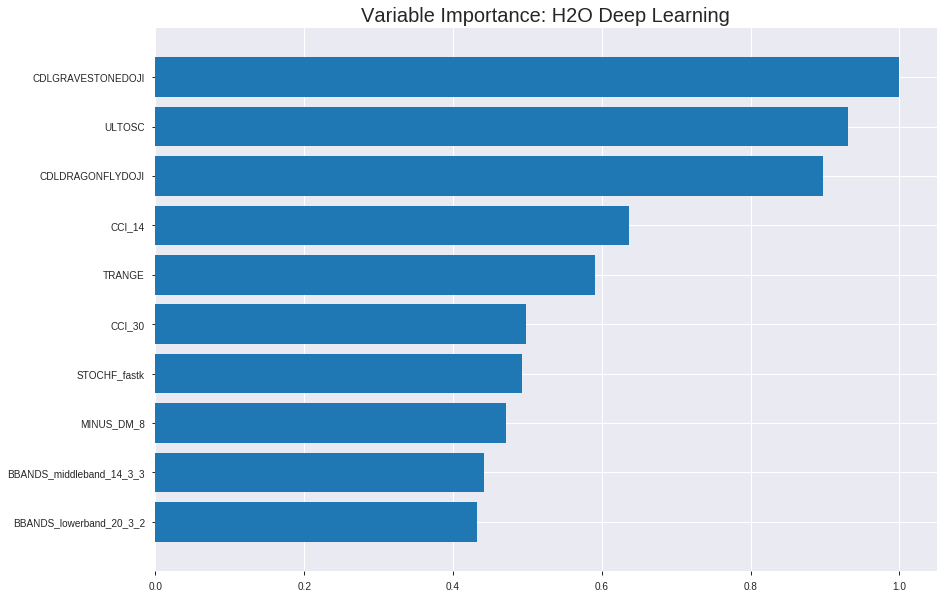

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190822_131050_model_9


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.19469938332283354
RMSE: 0.4412475306705223
LogLoss: 0.5648547775751878
Mean Per-Class Error: 0.29604236343366774
AUC: 0.7907744917515314
pr_auc: 0.7999514159841792
Gini: 0.5815489835030627
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.33870148110744647: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      386  504   0.5663   (504.0/890.0)
1      68   829   0.0758   (68.0/897.0)
Total  454  1333  0.3201   (572.0/1787.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.338701     0.743498  265
max f2                       0.26167      0.85482   300
max f0point5                 0.478502     0.718661  155
max accuracy                 0.401892     0.703973  213
max precision                0.960982     1         0
max recall                   0.0457142    1         393
max specificity              0.960982     1         0
max absolute_mcc             0.478502     0.426847  155
max min_per_class_accuracy   0.401892     0.7       213
max mean_per_class_accuracy  0.401892     0.703958  213

Gains/Lift Table: Avg response rate: 50.20 %, avg score: 41.73 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100727                   0.930739           1.9922    1.9922             1                0.939888   1                           0.939888            0.0200669       0.0200669                  99.2196   99.2196
    2        0.0201455                   0.917208           1.88152   1.93686            0.944444         0.922493   0.972222                    0.93119             0.0189521       0.039019                   88.1519   93.6857
    3        0.0302182                   0.907175           1.77084   1.88152            0.888889         0.91061    0.944444                    0.92433             0.0178372       0.0568562                  77.0841   88.1519
    4        0.040291                    0.897783           1.9922    1.90919            1                0.90254    0.958333                    0.918883            0.0200669       0.0769231                  99.2196   90.9188
    5        0.0503637                   0.889064           1.88152   1.90365            0.944444         0.893457   0.955556                    0.913797            0.0189521       0.0958751                  88.1519   90.3654
    6        0.100168                    0.822286           1.90266   1.90316            0.955056         0.858399   0.955307                    0.886253            0.0947603       0.190635                   90.2659   90.316
    7        0.149972                    0.632987           1.7012    1.83609            0.853933         0.738286   0.921642                    0.837115            0.0847269       0.275362                   70.1201   83.6091
    8        0.200336                    0.506732           1.74871   1.81412            0.877778         0.56048    0.910615                    0.767569            0.0880713       0.363434                   74.8706   81.4123
    9        0.299944                    0.41981            1.21994   1.6168             0.61236          0.451588   0.811567                    0.662635            0.121516        0.48495                    21.994    61.6801
    10       0.400112                    0.407928           1.01279   1.46559            0.50838          0.411555   0.735664                    0.599777            0.101449        0.586399                   1.27925   46.5588
    11       0.50028                     0.401724           1.16861   1.40613            0.586592         0.404965   0.705817                    0.560771            0.117057        0.703456                   16.8607   40.6125
    12       0.599888                    0.392331           0.839409  1.31202            0.421348         0.397963   0.658582                    0.533738            0.083612        0.787068                   -16.0591  31.2025
    13       0.700056                    0.364331           0.957145  1.26125            0.480447         0.381045   0.633094                    0.51189             0.0958751       0.882943                   -4.28555  26.1247
    14       0.799664                    0.284199           0.705103  1.19197            0.353933         0.330652   0.598321                    0.489314            0.0702341       0.953177                   -29.4897  19.1972
    15       0.899832                    0.101387           0.333888  1.09645            0.167598         0.195823   0.550373                    0.456643            0.0334448       0.986622                   -66.6112  9.64513
    16       1                           0.00113837         0.133555  1                  0.0670391        0.0640402  0.501959                    



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.18077062265870072
RMSE: 0.4251712862584922
LogLoss: 0.5327321009860858
Mean Per-Class Error: 0.26684200812107783
AUC: 0.8132382798080472
pr_auc: 0.8028157802356466
Gini: 0.6264765596160944
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.26503061227007463: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      130  122  0.4841   (122.0/252.0)
1      23   235  0.0891   (23.0/258.0)
Total  153  357  0.2843   (145.0/510.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.265031     0.764228  282
max f2                       0.187845     0.867596  322
max f0point5                 0.482987     0.752294  174
max accuracy                 0.383377     0.733333  214
max precision                0.950312     1         0
max recall                   0.0549682    1         382
max specificity              0.950312     1         0
max absolute_mcc             0.482987     0.46906   174
max min_per_class_accuracy   0.394653     0.728682  208
max mean_per_class_accuracy  0.383377     0.733158  214

Gains/Lift Table: Avg response rate: 50.59 %, avg score: 45.36 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117647                   0.942166           1.97674    1.97674            1                0.947209   1                           0.947209            0.0232558       0.0232558                  97.6744   97.6744
    2        0.0215686                   0.937863           1.5814     1.79704            0.8              0.939634   0.909091                    0.943765            0.0155039       0.0387597                  58.1395   79.704
    3        0.0313725                   0.935457           1.5814     1.72965            0.8              0.936207   0.875                       0.941403            0.0155039       0.0542636                  58.1395   72.9651
    4        0.0411765                   0.930886           1.97674    1.78848            1                0.932728   0.904762                    0.939338            0.0193798       0.0736434                  97.6744   78.8483
    5        0.0509804                   0.927696           1.97674    1.82469            1                0.928596   0.923077                    0.937272            0.0193798       0.0930233                  97.6744   82.4687
    6        0.1                         0.902995           1.73953    1.78295            0.88             0.918501   0.901961                    0.928071            0.0852713       0.178295                   73.9535   78.2946
    7        0.15098                     0.862731           1.82469    1.79704            0.923077         0.886007   0.909091                    0.913867            0.0930233       0.271318                   82.4687   79.704
    8        0.2                         0.7597             1.73953    1.78295            0.88             0.798896   0.901961                    0.885688            0.0852713       0.356589                   73.9535   78.2946
    9        0.3                         0.646179           1.31783    1.62791            0.666667         0.710156   0.823529                    0.827177            0.131783        0.488372                   31.7829   62.7907
    10       0.4                         0.492348           1.35659    1.56008            0.686275         0.567871   0.789216                    0.762351            0.135659        0.624031                   35.6589   56.0078
    11       0.5                         0.392259           1.04651    1.45736            0.529412         0.440551   0.737255                    0.697991            0.104651        0.728682                   4.65116   45.7364
    12       0.6                         0.324912           0.813953   1.35013            0.411765         0.363118   0.683007                    0.642179            0.0813953       0.810078                   -18.6047  35.0129
    13       0.7                         0.264075           1.00775    1.30122            0.509804         0.297737   0.658263                    0.592973            0.100775        0.910853                   0.775194  30.1218
    14       0.8                         0.175492           0.542636   1.2064             0.27451          0.217506   0.610294                    0.54604             0.0542636       0.965116                   -45.7364  20.6395
    15       0.9                         0.0686081          0.271318   1.1025             0.137255         0.113799   0.557734                    0.498013            0.0271318       0.992248                   -72.8682  10.2498
    16       1                           0.0243458          0.0775194  1                  0.0392157        0.0540016  0.505882   


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 13:16:57  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-22 13:16:59  1 min 59.540 sec  490 obs/sec       0.509233  1             910        0.567633         0.938553            -0.288848      0.714996        0.709625           1.66016          0.384443                         0.578712           0.979842              -0.339814        0.758067          0.755691             1.97674            0.337255
    2019-08-22 13:17:10  2 min 10.362 sec  792 obs/sec       5.16004   10            9221       0.45708          0.598226            0.1643         0.759695        0.774194           1.9922           0.352546                         0.433332           0.551316              0.248791         0.799542          0.797226             1.97674            0.278431
    2019-08-22 13:17:20  2 min 21.100 sec  943 obs/sec       11.2899   22            20175      0.436931         0.556356            0.236354       0.784134        0.790259           1.88152          0.334079                         0.43224            0.553073              0.252571         0.801272          0.788447             1.64729            0.313725
    2019-08-22 13:17:31  2 min 31.395 sec  1045 obs/sec      17.9328   35            32046      0.432057         0.546803            0.253297       0.791426        0.797804           1.77084          0.323447                         0.444113           0.583672              0.210946         0.798427          0.795005             1.97674            0.284314
    2019-08-22 13:17:41  2 min 42.016 sec  1137 obs/sec      25.6424   50            45823      0.441248         0.564855            0.221191       0.790774        0.799951           1.9922           0.32009                          0.425171           0.532732              0.276817         0.813238          0.802816             1.97674            0.284314
    2019-08-22 13:17:52  2 min 52.483 sec  1218 obs/sec      33.9261   66            60626      0.426538         0.536505            0.272252       0.800373        0.807481           1.9922           0.315613                         0.432947           0.568991              0.250123         0.809862          0.792923             1.97674            0.284314
    2019-08-22 13:18:02  3 min  3.061 sec  1286 obs/sec      42.6995   83            76304      0.423007         0.529227            0.284249       0.805044        0.813442           1.9922           0.301623                         0.42737            0.54721               0.269317         0.810354          0.796039             1.97674            0.292157
    2019-08-22 13:18:03  3 min  4.129 sec  1285 obs/sec      42.6995   83            76304      0.441248         0.564855            0.221191       0.790774        0.799951           1.9922           0.32009                          0.425171           0.532732              0.276817         0.813238          0.802816             1.97674            0.284314

Variable Importances: 


variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  --------------------
CDLGRAVESTONEDOJI  1.0                    1.0                  0.04931356312777739
ULTOSC             0.9303452372550964     0.9303452372550964   0.04587863858800623
CDLDRAGONFLYDOJI   0.8979558348655701     0.8979558348655701   0.04428140174859934
CCI_14             0.636437714099884      0.636437714099884    0.031385011391162974
TRANGE             0.59036785364151       0.59036785364151     0.029113142419161048
---                ---                    ---                  ---
WILLR_20           0.308826744556427      0.308826744556427    0.015229347163229346
CMO_12             0.3074708878993988     0.3074708878993988   0.015162485040380768
PLUS_DI_24         0.3042110800743103     0.3042110800743103   0.015001732301413844
ROCR100_14         0.30136170983314514    0.30136170983314514  0.014861219702151736
ROCP_14            0.2968912124633789     0.2968912124633789   0.014640763547895206


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.76171875)

('F1', 0.7662835249042146)

('auc', 0.8338831867057674)

('logloss', 0.49991503733819054)

('mean_per_class_error', 0.23692570869990226)

('rmse', 0.40938414201276085)

('mse', 0.16759537573152436)

deeplearning prediction progress: |███████████████████████████████████████| 100%


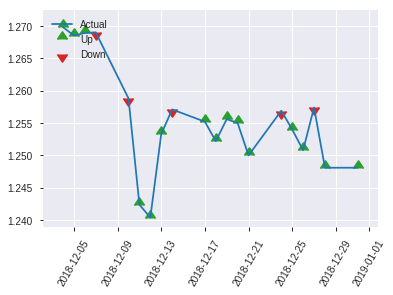


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.16759537573152436
RMSE: 0.40938414201276085
LogLoss: 0.49991503733819054
Mean Per-Class Error: 0.23692570869990226
AUC: 0.8338831867057674
pr_auc: 0.8106240955338601
Gini: 0.6677663734115349
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.41344325619214484: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      95   37   0.2803   (37.0/132.0)
1      24   100  0.1935   (24.0/124.0)
Total  119  137  0.2383   (61.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.413443     0.766284  136
max f2                       0.289175     0.872093  191
max f0point5                 0.457414     0.753205  124
max accuracy                 0.457414     0.761719  124
max precision                0.942142     1         0
max recall                   0.0690519    1         233
max specificity              0.942142     1         0
max absolute_mcc             0.413443     0.527196  136
max min_per_class_accuracy   0.457414     0.758065  124
max mean_per_class_accuracy  0.413443     0.763074  136

Gains/Lift Table: Avg response rate: 48.44 %, avg score: 48.28 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.93788            2.06452    2.06452            1                0.939568   1                           0.939568            0.0241935       0.0241935                  106.452   106.452
    2        0.0234375                   0.933301           2.06452    2.06452            1                0.934908   1                           0.937238            0.0241935       0.0483871                  106.452   106.452
    3        0.03125                     0.927257           2.06452    2.06452            1                0.930868   1                           0.935645            0.016129        0.0645161                  106.452   106.452
    4        0.0429688                   0.924685           1.37634    1.87683            0.666667         0.925789   0.909091                    0.932957            0.016129        0.0806452                  37.6344   87.6833
    5        0.0507812                   0.919995           2.06452    1.90571            1                0.921427   0.923077                    0.931183            0.016129        0.0967742                  106.452   90.5707
    6        0.101562                    0.90163            1.90571    1.90571            0.923077         0.914268   0.923077                    0.922726            0.0967742       0.193548                   90.5707   90.5707
    7        0.152344                    0.875317           1.90571    1.90571            0.923077         0.885025   0.923077                    0.910159            0.0967742       0.290323                   90.5707   90.5707
    8        0.203125                    0.826175           1.90571    1.90571            0.923077         0.854205   0.923077                    0.89617             0.0967742       0.387097                   90.5707   90.5707
    9        0.300781                    0.699414           1.23871    1.68915            0.6              0.753789   0.818182                    0.849943            0.120968        0.508065                   23.871    68.915
    10       0.402344                    0.520304           1.19107    1.56342            0.576923         0.584423   0.757282                    0.782918            0.120968        0.629032                   19.1067   56.342
    11       0.5                         0.44758            1.40387    1.53226            0.68             0.482098   0.742188                    0.724164            0.137097        0.766129                   40.3871   53.2258
    12       0.601562                    0.378773           0.794045   1.40762            0.384615         0.407798   0.681818                    0.670752            0.0806452       0.846774                   -20.5955  40.7625
    13       0.699219                    0.316836           0.825806   1.32637            0.4              0.347191   0.642458                    0.625562            0.0806452       0.927419                   -17.4194  32.6365
    14       0.800781                    0.204557           0.476427   1.21857            0.230769         0.275102   0.590244                    0.581113            0.0483871       0.975806                   -52.3573  21.8568
    15       0.898438                    0.0723956          0.165161   1.10407            0.08             0.118625   0.534783                    0.530843            0.016129        0.991935                   -83.4839  10.4067
    16       1                           0.0438528          0.0794045  1                  0.0384615        0.0579732  0.484375   

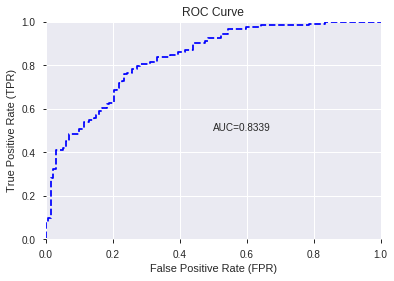

This function is available for GLM models only


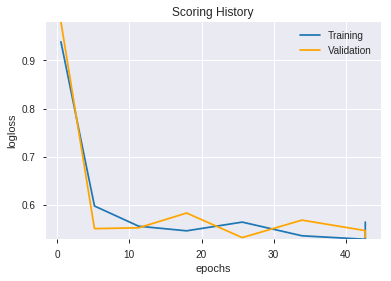

--2019-08-22 13:18:10--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.177.51
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.177.51|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


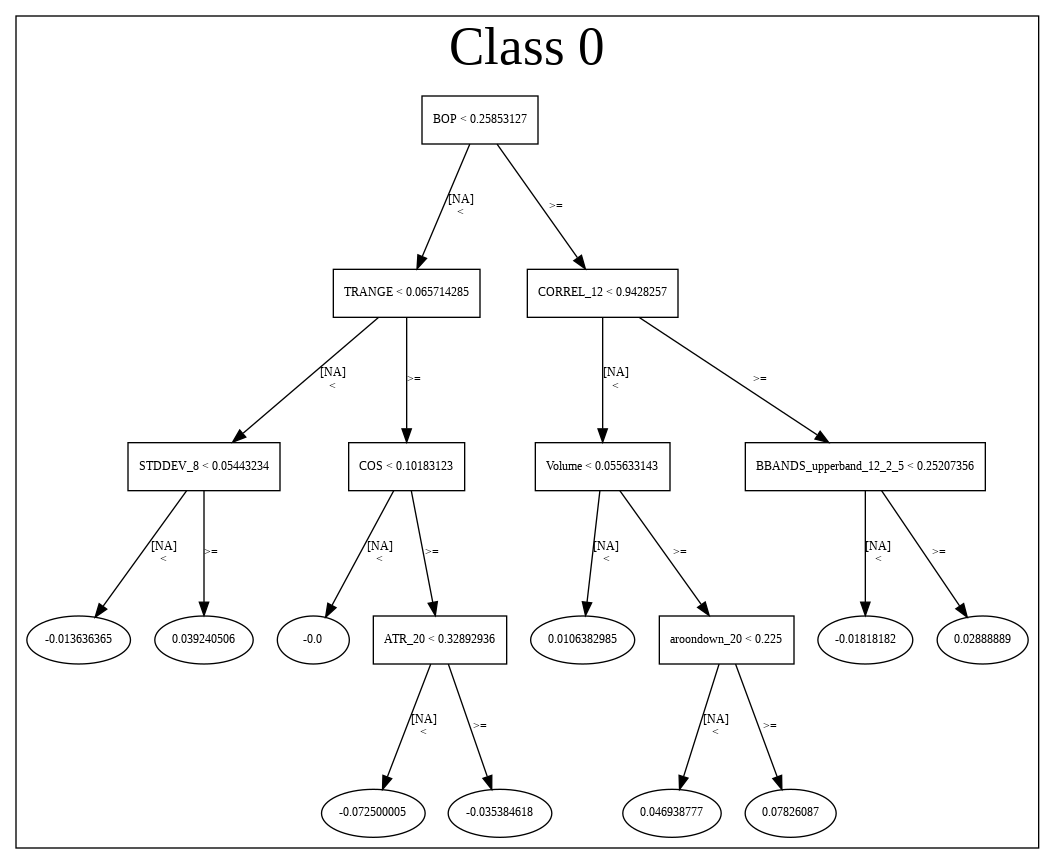

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190822_131050_model_9',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190822_131050_model_9',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_92dd',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLGRAVESTONEDOJI',
 'ULTOSC',
 'CDLDRAGONFLYDOJI',
 'CCI_14',
 'TRANGE',
 'CCI_30',
 'STOCHF_fastk',
 'MINUS_DM_8',
 'BBANDS_middleband_14_3_3',
 'BBANDS_lowerband_20_3_2',
 'MAVP_14_6',
 'BETA_12',
 'BBANDS_upperband_20_1_5',
 'BBANDS_upperband_14_4_4',
 'BBANDS_upperband_24_2_5',
 'PLUS_DI_12',
 'BBANDS_upperband_20_6_4',
 'BBANDS_upperband_14_2_5',
 'MACD_hist',
 'PLUS_DI_14',
 'DX_14',
 'PLUS_DM_20',
 'MACDEXT_signal',
 'NATR_8',
 'WILLR_14',
 'WILLR_12',
 'STOCH_slowk',
 'MACDFIX_14',
 'aroondown_14',
 'DX_8',
 'HT_PHASOR_quadrature',
 'ROC_8',
 'HT_DCPERIOD',
 'AROONOSC_24',
 'CDLSPINNINGTOP',
 'ROC_30',
 'ROCR100_12',
 'WILLR_8',
 'MOM_14',
 'aroonup_14',
 'CMO_8',
 'RSI_12',
 'MOM_30',
 'PLUS_DI_20',
 'CMO_20',
 'RSI_20',
 'WILLR_20',
 'CMO_12',
 'PLUS_DI_24',
 'ROCR100_14',
 'ROCP_14']

In [51]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190822_131820_model_1  0.846224  0.495931               0.25391  0.407827  0.166323

variable  relative_importance  scaled_importance  percentage
0                     CCI_14             0.891280           1.000000    0.106384
1          CDLGRAVESTONEDOJI             0.654648           0.734503    0.078139
2                     CCI_30             0.519448           0.582811    0.062002
3               STOCHF_fastk             0.491182           0.551097    0.058628
4           CDLDRAGONFLYDOJI             0.485393           0.544602    0.057937
5                 MINUS_DM_8             0.447652           0.502258    0.053432
6    BBANDS_upperband_24_2_5             0.379950           0.426296    0.045351
7                   WILLR_14             0.373017           0.418518    0.044524
8                      ROC_8             0.283097           0.317629    0.033791
9                     NATR_8             0.276562           0.310298    0.033011
10                    ULTOSC             0.219715           0.246516    0.026225
11                    MOM_14             0.207552           0.232869    0.024774
12               AROONOSC_24             0.196589           0.220569    0.023465
13                     CMO_8             0.167481           0.187911    0.019991
14                ROCR100_14             0.157124           0.176290    0.018754
15                   ROCP_14             0.156271           0.175333    0.018653
16                     DX_14             0.153107           0.171783    0.018275
17                    RSI_12             0.142905           0.160337    0.017057
18                    CMO_12             0.142685           0.160089    0.017031
19                PLUS_DI_12             0.138920           0.155866    0.016582
20                    ROC_30             0.131639           0.147696    0.015713
21                      DX_8             0.125076           0.140332    0.014929
22            MACDEXT_signal             0.123898           0.139011    0.014789
23                   WILLR_8             0.120884           0.135630    0.014429
24                    MOM_30             0.120061           0.134706    0.014331
25   BBANDS_upperband_20_6_4             0.113610           0.127469    0.013561
26                    TRANGE             0.109528           0.122889    0.013073
27                PLUS_DI_20             0.108172           0.121367    0.012911
28                 MAVP_14_6             0.106262           0.119224    0.012684
29   BBANDS_upperband_20_1_5             0.103080           0.115654    0.012304
30   BBANDS_lowerband_20_3_2             0.087202           0.097839    0.010409
31  BBANDS_middleband_14_3_3             0.081084           0.090974    0.009678
32   BBANDS_upperband_14_2_5             0.075214           0.084389    0.008978
33                aroonup_14             0.069317           0.077773    0.008274
34                PLUS_DM_20             0.055751           0.062552    0.006655
35              aroondown_14             0.046092           0.051715    0.005502
36                   BETA_12             0.046078           0.051699    0.005500
37                ROCR100_12             0.039608           0.044439    0.004728
38                PLUS_DI_14             0.036746           0.041229    0.004386
39            CDLSPINNINGTOP             0.030876           0.034642    0.003685
40   BBANDS_upperband_14_4_4             0.028346           0.031803    0.003383
41                MACDFIX_14             0.027007           0.030301    0.003224
42      HT_PHASOR_quadrature             0.022867           0.025656    0.002729
43               STOCH_slowk             0.021993           0.024675    0.002625
44                PLUS_DI_24             0.020732           0.023261    0.002475
45                    RSI_20             0.011734           0.013165    0.001401
46               HT_DCPERIOD             0.009453           0.010606    0.001128
47                  WILLR_20             0.005792           0.006498    0.000691
48                  WILLR_12             0.005391  

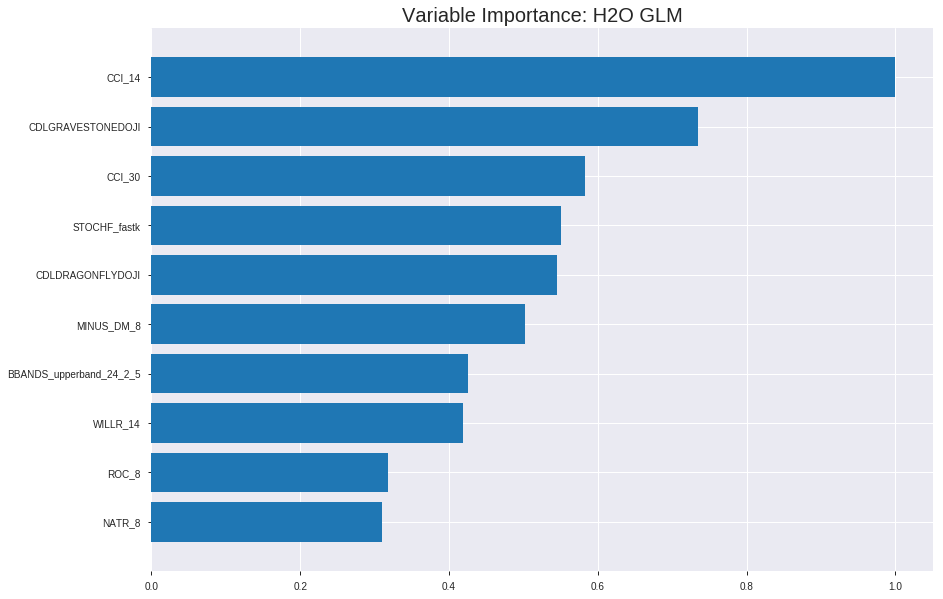

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190822_131820_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.18958987472813446
RMSE: 0.43541919425782605
LogLoss: 0.5550538003385543
Null degrees of freedom: 1786
Residual degrees of freedom: 1735
Null deviance: 2477.2806029937074
Residual deviance: 1983.7622824099935
AIC: 2087.7622824099935
AUC: 0.7810817581701802
pr_auc: 0.792608533282488
Gini: 0.5621635163403604
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3512089314961514: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      354  536   0.6022   (536.0/890.0)
1      77   820   0.0858   (77.0/897.0)
Total  431  1356  0.343    (613.0/1787.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.351209     0.727918  281
max f2                       0.241668     0.848597  326
max f0point5                 0.583613     0.722552  152
max accuracy                 0.507898     0.703414  194
max precision                0.997908     1         0
max recall                   0.0632659    1         388
max specificity              0.997908     1         0
max absolute_mcc             0.583613     0.415367  152
max min_per_class_accuracy   0.493668     0.700111  202
max mean_per_class_accuracy  0.507898     0.703545  194

Gains/Lift Table: Avg response rate: 50.20 %, avg score: 50.20 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100727                   0.964339           1.9922    1.9922             1                0.976594  1                           0.976594            0.0200669       0.0200669                  99.2196   99.2196
    2        0.0201455                   0.955646           1.9922    1.9922             1                0.959337  1                           0.967965            0.0200669       0.0401338                  99.2196   99.2196
    3        0.0302182                   0.947352           1.9922    1.9922             1                0.952234  1                           0.962722            0.0200669       0.0602007                  99.2196   99.2196
    4        0.040291                    0.937366           1.88152   1.96453            0.944444         0.941527  0.986111                    0.957423            0.0189521       0.0791527                  88.1519   96.4527
    5        0.0503637                   0.932062           1.77084   1.92579            0.888889         0.935025  0.966667                    0.952943            0.0178372       0.09699                    77.0841   92.579
    6        0.100168                    0.884388           1.81312   1.86977            0.910112         0.910038  0.938547                    0.93161             0.090301        0.187291                   81.3122   86.9771
    7        0.149972                    0.770237           1.65643   1.79892            0.831461         0.824249  0.902985                    0.895957            0.0824972       0.269788                   65.6433   79.8923
    8        0.200336                    0.684709           1.61589   1.75291            0.811111         0.721689  0.879888                    0.852146            0.0813824       0.351171                   61.5892   75.291
    9        0.299944                    0.597566           1.35425   1.62052            0.679775         0.636949  0.813433                    0.780682            0.134894        0.486065                   35.4246   62.0518
    10       0.400112                    0.543476           1.02392   1.47116            0.513966         0.56972   0.738462                    0.727867            0.102564        0.588629                   2.39221   47.116
    11       0.50028                     0.493263           1.11296   1.39944            0.558659         0.516967  0.702461                    0.68564             0.111483        0.700111                   11.2959   39.944
    12       0.599888                    0.440702           0.850601  1.30831            0.426966         0.467077  0.656716                    0.649349            0.0847269       0.784838                   -14.9399  30.8308
    13       0.700056                    0.38588            0.779071  1.23258            0.391061         0.413426  0.618705                    0.615592            0.0780379       0.862876                   -22.0929  23.2582
    14       0.799664                    0.320013           0.738679  1.17106            0.370787         0.355693  0.587824                    0.583218            0.0735786       0.936455                   -26.1321  17.106
    15       0.899832                    0.163997           0.434054  1.08902            0.217877         0.254238  0.546642                    0.546596            0.0434783       0.979933                   -56.5946  8.90177
    16       1                           2.27543e-06        0.200333  1                  0.100559         0.100965  0.501959                    0.501959            0.



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.17836430988684493
RMSE: 0.4223319901296194
LogLoss: 0.5290942862004753
Null degrees of freedom: 509
Residual degrees of freedom: 458
Null deviance: 706.9709434262809
Residual deviance: 539.6761719244847
AIC: 643.6761719244847
AUC: 0.8112772240679218
pr_auc: 0.8083096719030826
Gini: 0.6225544481358436
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3902538684881894: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      117  135  0.5357   (135.0/252.0)
1      14   244  0.0543   (14.0/258.0)
Total  131  379  0.2922   (149.0/510.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.390254     0.766091  280
max f2                       0.385854     0.866337  283
max f0point5                 0.512046     0.737705  200
max accuracy                 0.512046     0.739216  200
max precision                0.989115     1         0
max recall                   0.0869617    1         382
max specificity              0.989115     1         0
max absolute_mcc             0.488607     0.483689  221
max min_per_class_accuracy   0.521087     0.72619   193
max mean_per_class_accuracy  0.512046     0.73888   200

Gains/Lift Table: Avg response rate: 50.59 %, avg score: 52.59 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117647                   0.975025           1.97674   1.97674            1                0.980915   1                           0.980915            0.0232558       0.0232558                  97.6744   97.6744
    2        0.0215686                   0.96295            1.97674   1.97674            1                0.971057   1                           0.976434            0.0193798       0.0426357                  97.6744   97.6744
    3        0.0313725                   0.954631           1.97674   1.97674            1                0.957596   1                           0.970547            0.0193798       0.0620155                  97.6744   97.6744
    4        0.0411765                   0.950502           1.97674   1.97674            1                0.952424   1                           0.966232            0.0193798       0.0813953                  97.6744   97.6744
    5        0.0509804                   0.940782           1.5814    1.90072            0.8              0.944145   0.961538                    0.961984            0.0155039       0.0968992                  58.1395   90.0716
    6        0.1                         0.917218           1.8186    1.86047            0.92             0.928244   0.941176                    0.945445            0.0891473       0.186047                   81.8605   86.0465
    7        0.15098                     0.867895           1.67263   1.79704            0.846154         0.89989    0.909091                    0.930063            0.0852713       0.271318                   67.263    79.704
    8        0.2                         0.706992           1.73953   1.78295            0.88             0.784481   0.901961                    0.894381            0.0852713       0.356589                   73.9535   78.2946
    9        0.3                         0.634097           1.24031   1.60207            0.627451         0.659584   0.810458                    0.816115            0.124031        0.48062                    24.031    60.2067
    10       0.4                         0.566003           1.20155   1.50194            0.607843         0.598019   0.759804                    0.761591            0.120155        0.600775                   20.155    50.1938
    11       0.5                         0.522024           1.24031   1.44961            0.627451         0.544518   0.733333                    0.718177            0.124031        0.724806                   24.031    44.9612
    12       0.6                         0.482163           1.00775   1.37597            0.509804         0.503609   0.696078                    0.682415            0.100775        0.825581                   0.775194  37.5969
    13       0.7                         0.415706           0.852713  1.30122            0.431373         0.447121   0.658263                    0.648802            0.0852713       0.910853                   -14.7287  30.1218
    14       0.8                         0.331146           0.503876  1.20155            0.254902         0.376685   0.607843                    0.614787            0.0503876       0.96124                    -49.6124  20.155
    15       0.9                         0.144965           0.232558  1.09388            0.117647         0.241751   0.553377                    0.573339            0.0232558       0.984496                   -76.7442  9.38846
    16       1                           0.0218612          0.155039  1                  0.0784314        0.0984914  0.505882                    0


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-22 13:18:20  0.000 sec   2            .16E2     52            1.3768137107614913  1.374772954906626
     2019-08-22 13:18:20  0.029 sec   4            .96E1     52            1.3714539284187004  1.3683189029672385
     2019-08-22 13:18:20  0.049 sec   6            .6E1      52            1.3633904002043096  1.358628214426891
     2019-08-22 13:18:20  0.068 sec   8            .37E1     52            1.3516152798956704  1.3445118600424915
     2019-08-22 13:18:20  0.086 sec   10           .23E1     52            1.3351938549193785  1.324857528594774
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-22 13:18:21  0.360 sec   38           .29E-2    52            1.1070979477416882  1.0584072972748382
     2019-08-22 13:18:21  0.377 sec   40           .18E-2    52            1.1046038932451654  1.06017431477814
     2019-08-22 13:18:21  0.393 sec   42           .11E-2    52            1.1024862111971931  1.0631725906037406
     2019-08-22 13:18:21  0.408 sec   44           .7E-3     52            1.100659539418622   1.0673349470660334
     2019-08-22 13:18:21  0.424 sec   46           .44E-3    52            1.0990429171613254  1.0725261122798875


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7734375)

('F1', 0.7659574468085106)

('auc', 0.846224340175953)

('logloss', 0.4959305631222367)

('mean_per_class_error', 0.22776148582600197)

('rmse', 0.40782673840250205)

('mse', 0.16632264855602283)

glm prediction progress: |████████████████████████████████████████████████| 100%


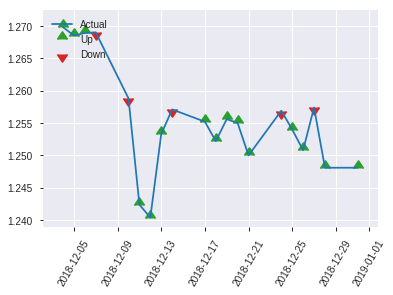


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.16632264855602283
RMSE: 0.40782673840250205
LogLoss: 0.4959305631222367
Null degrees of freedom: 255
Residual degrees of freedom: 204
Null deviance: 354.9579598113329
Residual deviance: 253.91644831858517
AIC: 357.91644831858514
AUC: 0.846224340175953
pr_auc: 0.8365221599903132
Gini: 0.6924486803519061
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48645132304418653: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      82   50   0.3788   (50.0/132.0)
1      16   108  0.129    (16.0/124.0)
Total  98   158  0.2578   (66.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.486451     0.765957  157
max f2                       0.392046     0.869883  187
max f0point5                 0.57454      0.77381   115
max accuracy                 0.57454      0.773438  115
max precision                0.972624     1         0
max recall                   0.119054     1         237
max specificity              0.972624     1         0
max absolute_mcc             0.57454      0.546619  115
max min_per_class_accuracy   0.550707     0.765152  125
max mean_per_class_accuracy  0.57454      0.772239  115

Gains/Lift Table: Avg response rate: 48.44 %, avg score: 54.33 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.96843            2.06452    2.06452            1                0.970161   1                           0.970161            0.0241935       0.0241935                  106.452   106.452
    2        0.0234375                   0.964667           2.06452    2.06452            1                0.966418   1                           0.968289            0.0241935       0.0483871                  106.452   106.452
    3        0.03125                     0.963448           2.06452    2.06452            1                0.964024   1                           0.967223            0.016129        0.0645161                  106.452   106.452
    4        0.0429688                   0.959285           2.06452    2.06452            1                0.961252   1                           0.965594            0.0241935       0.0887097                  106.452   106.452
    5        0.0507812                   0.956077           2.06452    2.06452            1                0.958632   1                           0.964523            0.016129        0.104839                   106.452   106.452
    6        0.101562                    0.930534           2.06452    2.06452            1                0.943821   1                           0.954172            0.104839        0.209677                   106.452   106.452
    7        0.152344                    0.908396           1.90571    2.01158            0.923077         0.92141    0.974359                    0.943251            0.0967742       0.306452                   90.5707   101.158
    8        0.203125                    0.793728           1.58809    1.90571            0.769231         0.873881   0.923077                    0.925909            0.0806452       0.387097                   58.8089   90.5707
    9        0.300781                    0.654376           1.23871    1.68915            0.6              0.714127   0.818182                    0.857148            0.120968        0.508065                   23.871    68.915
    10       0.402344                    0.589681           1.42928    1.62355            0.692308         0.612076   0.786408                    0.795285            0.145161        0.653226                   42.928    62.3552
    11       0.5                         0.546215           1.23871    1.54839            0.6              0.568322   0.75                        0.750957            0.120968        0.774194                   23.871    54.8387
    12       0.601562                    0.497092           0.794045   1.42103            0.384615         0.517017   0.688312                    0.71146             0.0806452       0.854839                   -20.5955  42.1031
    13       0.699219                    0.413917           0.743226   1.32637            0.36             0.458582   0.642458                    0.676142            0.0725806       0.927419                   -25.6774  32.6365
    14       0.800781                    0.331196           0.476427   1.21857            0.230769         0.376692   0.590244                    0.638163            0.0483871       0.975806                   -52.3573  21.8568
    15       0.898438                    0.154017           0.165161   1.10407            0.08             0.231108   0.534783                    0.593918            0.016129        0.991935                   -83.4839  10.4067
    16       1                           0.0285915          0.0794045  1                  0.0384615        0.0950365  0.484375  

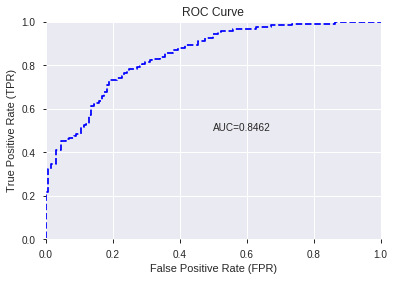

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


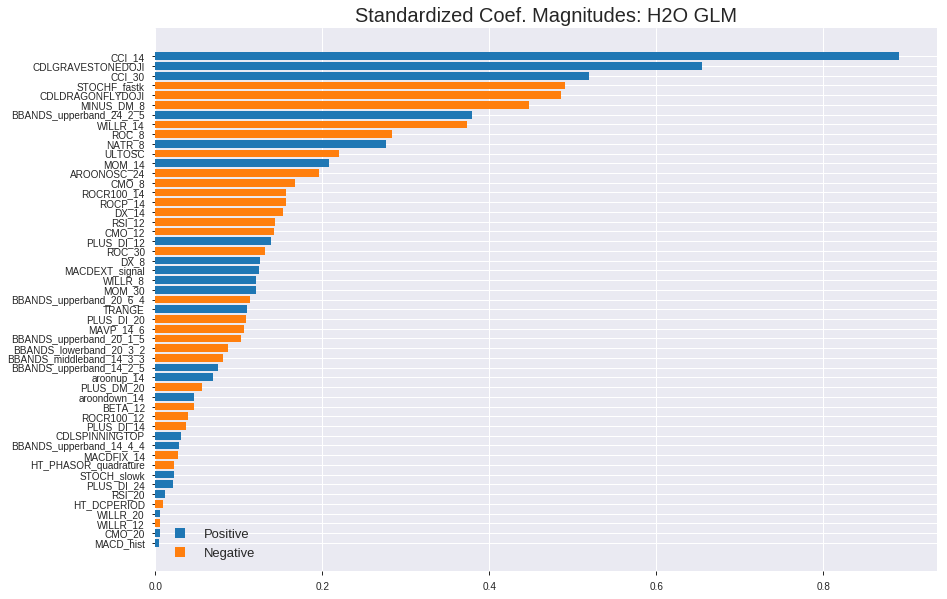

'log_likelihood'
--2019-08-22 13:18:27--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.38.28
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.38.28|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


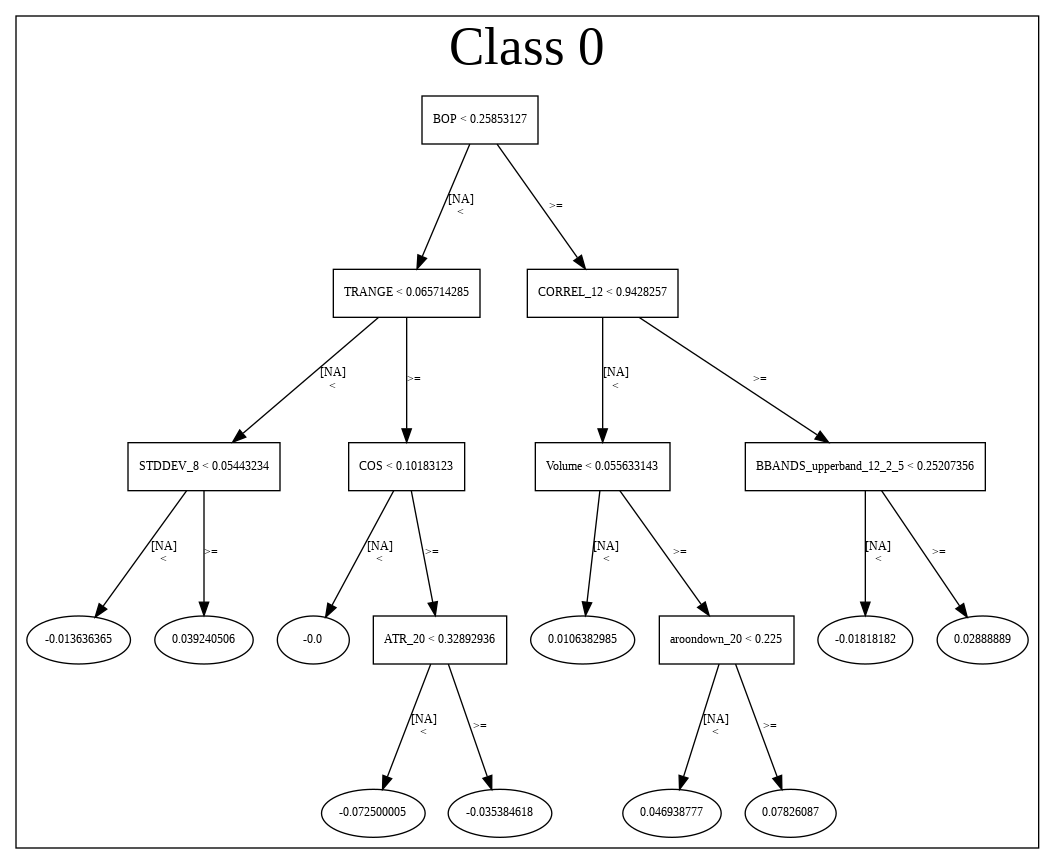

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190822_131820_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190822_131820_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_92dd',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['CCI_14',
 'CDLGRAVESTONEDOJI',
 'CCI_30',
 'STOCHF_fastk',
 'CDLDRAGONFLYDOJI',
 'MINUS_DM_8',
 'BBANDS_upperband_24_2_5',
 'WILLR_14',
 'ROC_8',
 'NATR_8',
 'ULTOSC',
 'MOM_14',
 'AROONOSC_24',
 'CMO_8',
 'ROCR100_14',
 'ROCP_14',
 'DX_14',
 'RSI_12',
 'CMO_12',
 'PLUS_DI_12',
 'ROC_30',
 'DX_8',
 'MACDEXT_signal',
 'WILLR_8',
 'MOM_30',
 'BBANDS_upperband_20_6_4',
 'TRANGE',
 'PLUS_DI_20',
 'MAVP_14_6',
 'BBANDS_upperband_20_1_5',
 'BBANDS_lowerband_20_3_2',
 'BBANDS_middleband_14_3_3',
 'BBANDS_upperband_14_2_5',
 'aroonup_14',
 'PLUS_DM_20',
 'aroondown_14',
 'BETA_12',
 'ROCR100_12',
 'PLUS_DI_14',
 'CDLSPINNINGTOP',
 'BBANDS_upperband_14_4_4',
 'MACDFIX_14',
 'HT_PHASOR_quadrature',
 'STOCH_slowk',
 'PLUS_DI_24',
 'RSI_20',
 'HT_DCPERIOD',
 'WILLR_20',
 'WILLR_12',
 'CMO_20',
 'MACD_hist']

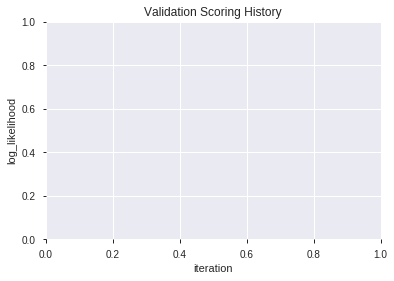

In [52]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_1_AutoML_20190822_131837  0.843964  0.499704              0.256720  0.408785  0.167105
1  XGBoost_grid_1_AutoML_20190822_131837_model_7  0.843414  0.509878              0.225318  0.413092  0.170645
2  XGBoost_grid_1_AutoML_20190822_131837_model_4  0.839993  0.516256              0.240714  0.414979  0.172207
3               XGBoost_2_AutoML_20190822_131837  0.837671  0.511018              0.230083  0.413797  0.171228
4  XGBoost_grid_1_AutoML_20190822_131837_model_3  0.834983  0.510298              0.253666  0.412676  0.170301
5               XGBoost_3_AutoML_20190822_131837  0.833333  0.507492              0.261975  0.411405  0.169254
6  XGBoost_grid_1_AutoML_20190822_131837_model_5  0.832661  0.521070              0.243524  0.417227  0.174078
7  XGBoost_grid_1_AutoML_20190822_131837_model_6  0.832417  0.511219              0.228861  0.412796  0.170401
8  XGBoost_grid_1_AutoML_20190822_131837_model_1  0.829851  0.510767              0.247556  0.413944  0.171349
9  XGBoost_grid_1_AutoML_20190822_131837_model_2  0.825696  0.524537              0.247312  0.418427  0.175081

variable  relative_importance  scaled_importance  percentage
0          CDLGRAVESTONEDOJI          1118.254639           1.000000    0.099344
1           CDLDRAGONFLYDOJI           691.666199           0.618523    0.061447
2                     CCI_14           691.393860           0.618279    0.061422
3               STOCHF_fastk           599.411804           0.536024    0.053251
4                     ULTOSC           518.070190           0.463285    0.046025
5    BBANDS_lowerband_20_3_2           304.925964           0.272680    0.027089
6                       DX_8           271.638611           0.242913    0.024132
7                    BETA_12           257.990814           0.230708    0.022919
8                     TRANGE           254.359970           0.227462    0.022597
9                    WILLR_8           250.722397           0.224209    0.022274
10                 MACD_hist           240.306686           0.214894    0.021348
11               STOCH_slowk           236.730942           0.211697    0.021031
12                    CCI_30           229.698761           0.205408    0.020406
13                MINUS_DM_8           227.372269           0.203328    0.020199
14                aroonup_14           222.711151           0.199160    0.019785
15                     ROC_8           221.404251           0.197991    0.019669
16                    NATR_8           218.737991           0.195607    0.019432
17                  WILLR_20           207.290863           0.185370    0.018415
18   BBANDS_upperband_20_6_4           205.721451           0.183967    0.018276
19            MACDEXT_signal           199.275665           0.178202    0.017703
20                  WILLR_14           191.781784           0.171501    0.017038
21                     DX_14           188.135696           0.168240    0.016714
22                PLUS_DI_12           185.341904           0.165742    0.016465
23                ROCR100_12           177.974838           0.159154    0.015811
24      HT_PHASOR_quadrature           177.693130           0.158902    0.015786
25                MACDFIX_14           174.437363           0.155991    0.015497
26                    CMO_20           170.955841           0.152877    0.015187
27                  WILLR_12           168.506073           0.150687    0.014970
28  BBANDS_middleband_14_3_3           167.390915           0.149689    0.014871
29                    CMO_12           164.867950           0.147433    0.014647
30                 MAVP_14_6           162.852356           0.145631    0.014468
31                    ROC_30           160.649643           0.143661    0.014272
32   BBANDS_upperband_14_2_5           143.299515           0.128146    0.012730
33               HT_DCPERIOD           142.330887           0.127279    0.012644
34                PLUS_DM_20           134.815262           0.120559    0.011977
35   BBANDS_upperband_14_4_4           131.048920           0.117191    0.011642
36                     CMO_8           130.322281           0.116541    0.011578
37                    MOM_14           127.590202           0.114098    0.011335
38                PLUS_DI_14           125.443542           0.112178    0.011144
39               AROONOSC_24           120.619202           0.107864    0.010716
40                PLUS_DI_20           118.592491           0.106051    0.010536
41                    MOM_30           117.768425           0.105314    0.010462
42                   ROCP_14           115.503052           0.103289    0.010261
43              aroondown_14            95.741989           0.085617    0.008506
44   BBANDS_upperband_24_2_5            92.720840           0.082916    0.008237
45   BBANDS_upperband_20_1_5            90.830818           0.081226    0.008069
46                ROCR100_14            88.413139           0.079064    0.007854
47                PLUS_DI_24            86.513329           0.077365    0.007686
48                    RSI_12            52.241898  

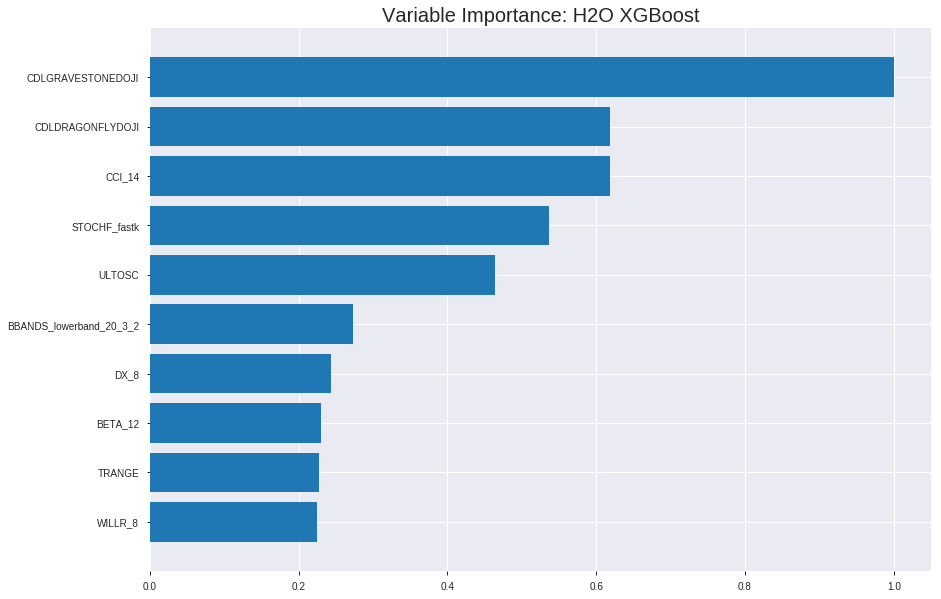

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_1_AutoML_20190822_131837


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.09799154888138256
RMSE: 0.313036018504872
LogLoss: 0.3468671161774572
Mean Per-Class Error: 0.07441659464131378
AUC: 0.9720585472173161
pr_auc: 0.9706704019126493
Gini: 0.9441170944346322
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49730166296164197: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      826  64   0.0719   (64.0/890.0)
1      69   828  0.0769   (69.0/897.0)
Total  895  892  0.0744   (133.0/1787.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.497302     0.925657  198
max f2                       0.386801     0.94086   241
max f0point5                 0.529077     0.932303  186
max accuracy                 0.497302     0.925574  198
max precision                0.970249     1         0
max recall                   0.178486     1         338
max specificity              0.970249     1         0
max absolute_mcc             0.497302     0.851161  198
max min_per_class_accuracy   0.497302     0.923077  198
max mean_per_class_accuracy  0.497302     0.925583  198

Gains/Lift Table: Avg response rate: 50.20 %, avg score: 50.11 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100727                   0.945651           1.9922     1.9922             1                0.954021   1                           0.954021            0.0200669       0.0200669                  99.2196   99.2196
    2        0.0201455                   0.934155           1.9922     1.9922             1                0.940478   1                           0.94725             0.0200669       0.0401338                  99.2196   99.2196
    3        0.0302182                   0.926939           1.9922     1.9922             1                0.930409   1                           0.941636            0.0200669       0.0602007                  99.2196   99.2196
    4        0.040291                    0.921224           1.9922     1.9922             1                0.923916   1                           0.937206            0.0200669       0.0802676                  99.2196   99.2196
    5        0.0503637                   0.916691           1.9922     1.9922             1                0.919055   1                           0.933576            0.0200669       0.100334                   99.2196   99.2196
    6        0.100168                    0.879272           1.9922     1.9922             1                0.90134    1                           0.917548            0.0992196       0.199554                   99.2196   99.2196
    7        0.149972                    0.840849           1.9922     1.9922             1                0.858739   1                           0.898018            0.0992196       0.298774                   99.2196   99.2196
    8        0.200336                    0.787838           1.92579    1.9755             0.966667         0.811976   0.99162                     0.876387            0.09699         0.395764                   92.579    97.5502
    9        0.299944                    0.699187           1.89147    1.94759            0.949438         0.741244   0.977612                    0.831508            0.188406        0.584169                   89.1467   94.7595
    10       0.400112                    0.614496           1.86977    1.92811            0.938547         0.659657   0.967832                    0.788485            0.187291        0.77146                    86.9771   92.8112
    11       0.50028                     0.493257           1.51362    1.84512            0.759777         0.554691   0.926174                    0.741674            0.151616        0.923077                   51.3624   84.5121
    12       0.599888                    0.379911           0.526029   1.62609            0.264045         0.43313    0.816231                    0.690442            0.0523969       0.975474                   -47.3971  62.6093
    13       0.700056                    0.28901            0.144685   1.41412            0.0726257        0.33395    0.709832                    0.639433            0.0144928       0.989967                   -85.5315  41.4125
    14       0.799664                    0.223899           0.0671527  1.24634            0.0337079        0.25807    0.625612                    0.591929            0.00668896      0.996656                   -93.2847  24.6342
    15       0.899832                    0.138714           0.0333888  1.11132            0.0167598        0.182441   0.557836                    0.546346            0.00334448      1                          -96.6611  11.1318
    16       1                           0.0418633          0          1                  0                0.0946113  0.501959 



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.16780720981113859
RMSE: 0.40964278317961195
LogLoss: 0.5050634934028143
Mean Per-Class Error: 0.23929494278331487
AUC: 0.8317798695705673
pr_auc: 0.8224453922379279
Gini: 0.6635597391411345
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.34346699714660645: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      139  113  0.4484   (113.0/252.0)
1      24   234  0.093    (24.0/258.0)
Total  163  347  0.2686   (137.0/510.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.343467     0.773554  266
max f2                       0.162424     0.867797  344
max f0point5                 0.612759     0.765107  141
max accuracy                 0.476788     0.760784  193
max precision                0.973136     1         0
max recall                   0.116293     1         368
max specificity              0.973136     1         0
max absolute_mcc             0.476788     0.521474  193
max min_per_class_accuracy   0.480782     0.753968  191
max mean_per_class_accuracy  0.476788     0.760705  193

Gains/Lift Table: Avg response rate: 50.59 %, avg score: 50.83 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117647                   0.946942           1.97674    1.97674            1                0.958477   1                           0.958477            0.0232558       0.0232558                  97.6744   97.6744
    2        0.0215686                   0.943321           1.97674    1.97674            1                0.944579   1                           0.95216             0.0193798       0.0426357                  97.6744   97.6744
    3        0.0313725                   0.934768           1.97674    1.97674            1                0.938355   1                           0.947846            0.0193798       0.0620155                  97.6744   97.6744
    4        0.0411765                   0.928778           1.5814     1.88261            0.8              0.931332   0.952381                    0.943914            0.0155039       0.0775194                  58.1395   88.2614
    5        0.0509804                   0.924903           1.97674    1.90072            1                0.926397   0.961538                    0.940545            0.0193798       0.0968992                  97.6744   90.0716
    6        0.1                         0.902814           1.66047    1.78295            0.84             0.913152   0.901961                    0.927117            0.0813953       0.178295                   66.0465   78.2946
    7        0.15098                     0.872178           1.74866    1.77137            0.884615         0.890625   0.896104                    0.914795            0.0891473       0.267442                   74.8658   77.1368
    8        0.2                         0.813869           1.73953    1.76357            0.88             0.844616   0.892157                    0.897594            0.0852713       0.352713                   73.9535   76.3566
    9        0.3                         0.693331           1.51163    1.67959            0.764706         0.752715   0.849673                    0.849301            0.151163        0.503876                   51.1628   67.9587
    10       0.4                         0.591894           1.31783    1.58915            0.666667         0.639941   0.803922                    0.796961            0.131783        0.635659                   31.7829   58.9147
    11       0.5                         0.484075           1.16279    1.50388            0.588235         0.539533   0.760784                    0.745475            0.116279        0.751938                   16.2791   50.3876
    12       0.6                         0.399988           0.813953   1.38889            0.411765         0.442415   0.702614                    0.694965            0.0813953       0.833333                   -18.6047  38.8889
    13       0.7                         0.325139           0.813953   1.30676            0.411765         0.362244   0.661064                    0.647434            0.0813953       0.914729                   -18.6047  30.6755
    14       0.8                         0.225088           0.503876   1.2064             0.254902         0.279812   0.610294                    0.601481            0.0503876       0.965116                   -49.6124  20.6395
    15       0.9                         0.137399           0.310078   1.1068             0.156863         0.178525   0.559913                    0.554486            0.0310078       0.996124                   -68.9922  10.6804
    16       1                           0.0471302          0.0387597  1                  0.0196078        0.0929187  0.505882 


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 13:18:37  0.007 sec   0                  0.5              0.693147            0.5             0                  1                0.498041                         0.5                0.693147              0.5               0                    1                  0.494118
    2019-08-22 13:18:37  0.161 sec   5                  0.470139         0.634821            0.872987        0.870391           1.9922           0.202574                         0.474253           0.64259               0.801557          0.789528             1.77907            0.262745
    2019-08-22 13:18:38  0.263 sec   10                 0.445312         0.587694            0.897855        0.894917           1.9922           0.173475                         0.455953           0.607002              0.810254          0.799034             1.97674            0.258824
    2019-08-22 13:18:38  0.356 sec   15                 0.426764         0.552566            0.903321        0.892886           1.9922           0.174594                         0.440657           0.576809              0.821006          0.799806             1.97674            0.258824
    2019-08-22 13:18:38  0.454 sec   20                 0.411102         0.522901            0.913649        0.907716           1.9922           0.162283                         0.431747           0.558353              0.822759          0.814259             1.97674            0.254902
    2019-08-22 13:18:38  0.552 sec   25                 0.397437         0.497196            0.92348         0.91977            1.9922           0.149972                         0.425226           0.544082              0.824189          0.81407              1.97674            0.262745
    2019-08-22 13:18:38  0.705 sec   30                 0.387421         0.47818             0.930958        0.926331           1.9922           0.140459                         0.421999           0.535672              0.822405          0.815115             1.97674            0.280392
    2019-08-22 13:18:38  0.806 sec   35                 0.377472         0.459658            0.936016        0.932436           1.9922           0.132625                         0.418956           0.528534              0.824797          0.820068             1.97674            0.270588
    2019-08-22 13:18:38  0.901 sec   40                 0.368513         0.442713            0.939901        0.935917           1.9922           0.126469                         0.415173           0.51993               0.829765          0.823837             1.97674            0.260784
    2019-08-22 13:18:38  1.009 sec   45                 0.360053         0.427557            0.945725        0.941365           1.9922           0.119754                         0.414188           0.516777              0.829811          0.825568             1.97674            0.254902
    2019-08-22 13:18:38  1.103 sec   50                 0.353018         0.414479            0.949453        0.946261           1.9922           0.109121                         0.412371           0.512394              0.831426          0.82614              1.97674            0.24902
    2019-08-22 13:18:38  1.210 sec   55                 0.346041         0.402124            0.953562        0.950811           1.9922           0.104085                         0.412185           0.51152               0.830088          0.

Variable Importances: 


variable           relative_importance    scaled_importance     percentage
-----------------  ---------------------  --------------------  ---------------------
CDLGRAVESTONEDOJI  1118.254638671875      1.0                   0.09934393768008884
CDLDRAGONFLYDOJI   691.6661987304688      0.618522986456774     0.061446509020264176
CCI_14             691.3938598632812      0.6182794472325495    0.06142231487475017
STOCHF_fastk       599.4118041992188      0.5360244290255091    0.053250777472115374
ULTOSC             518.0701904296875      0.4632846334936624    0.04602451975793719
---                ---                    ---                   ---
ROCR100_14         88.41313934326172      0.07906351226789271   0.007854480635510473
PLUS_DI_24         86.5133285522461       0.07736460512696461   0.007685704510377853
RSI_12             52.24189758300781      0.046717353790773714  0.004641085883569286
CDLSPINNINGTOP     42.16701889038086      0.037707886408109736  0.0037460499173751225
RSI_20             42.16057205200195      0.037702121318338624  0.003745477190656181


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.76171875)

('F1', 0.7697594501718212)

('auc', 0.8439638318670577)

('logloss', 0.49970363633266923)

('mean_per_class_error', 0.24156891495601174)

('rmse', 0.4087852346684676)

('mse', 0.16710536808295412)

xgboost prediction progress: |████████████████████████████████████████████| 100%


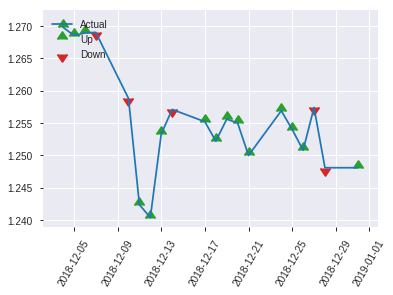


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.16710536808295412
RMSE: 0.4087852346684676
LogLoss: 0.49970363633266923
Mean Per-Class Error: 0.24156891495601174
AUC: 0.8439638318670577
pr_auc: 0.8418468844515901
Gini: 0.6879276637341154
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45023348927497864: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      77   55   0.4167   (55.0/132.0)
1      12   112  0.0968   (12.0/124.0)
Total  89   167  0.2617   (67.0/256.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.450233     0.769759  166
max f2                       0.307901     0.867052  195
max f0point5                 0.713456     0.793478  83
max accuracy                 0.687427     0.761719  98
max precision                0.958441     1         0
max recall                   0.0932754    1         246
max specificity              0.958441     1         0
max absolute_mcc             0.713456     0.537909  83
max min_per_class_accuracy   0.5892       0.733871  122
max mean_per_class_accuracy  0.687427     0.758431  98

Gains/Lift Table: Avg response rate: 48.44 %, avg score: 55.03 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0117188                   0.949901           2.06452    2.06452            1                0.954874   1                           0.954874            0.0241935       0.0241935                  106.452   106.452
    2        0.0234375                   0.937558           2.06452    2.06452            1                0.94259    1                           0.948732            0.0241935       0.0483871                  106.452   106.452
    3        0.03125                     0.932746           2.06452    2.06452            1                0.934062   1                           0.945064            0.016129        0.0645161                  106.452   106.452
    4        0.0429688                   0.929651           2.06452    2.06452            1                0.931579   1                           0.941386            0.0241935       0.0887097                  106.452   106.452
    5        0.0507812                   0.926956           2.06452    2.06452            1                0.927438   1                           0.93924             0.016129        0.104839                   106.452   106.452
    6        0.101562                    0.909222           2.06452    2.06452            1                0.917562   1                           0.928401            0.104839        0.209677                   106.452   106.452
    7        0.152344                    0.89651            1.58809    1.90571            0.769231         0.901586   0.923077                    0.919463            0.0806452       0.290323                   58.8089   90.5707
    8        0.203125                    0.857412           1.90571    1.90571            0.923077         0.873899   0.923077                    0.908072            0.0967742       0.387097                   90.5707   90.5707
    9        0.300781                    0.729861           1.56903    1.7964             0.76             0.787896   0.87013                     0.869054            0.153226        0.540323                   56.9032   79.6397
    10       0.402344                    0.65789            1.19107    1.6436             0.576923         0.696996   0.796117                    0.825622            0.120968        0.66129                    19.1067   64.3595
    11       0.5                         0.567455           0.825806   1.48387            0.4              0.609732   0.71875                     0.783456            0.0806452       0.741935                   -17.4194  48.3871
    12       0.601562                    0.496517           1.11166    1.42103            0.538462         0.534477   0.688312                    0.74142             0.112903        0.854839                   11.1663   42.1031
    13       0.699219                    0.392053           0.578065   1.3033             0.28             0.444194   0.631285                    0.699908            0.0564516       0.91129                    -42.1935  30.3298
    14       0.800781                    0.251806           0.555831   1.2085             0.269231         0.317471   0.585366                    0.651404            0.0564516       0.967742                   -44.4169  20.8497
    15       0.898438                    0.140961           0.247742   1.10407            0.12             0.189928   0.534783                    0.601244            0.0241935       0.991935                   -75.2258  10.4067
    16       1                           0.0516049          0.0794045  1                  0.0384615        0.0995625  0.484375 

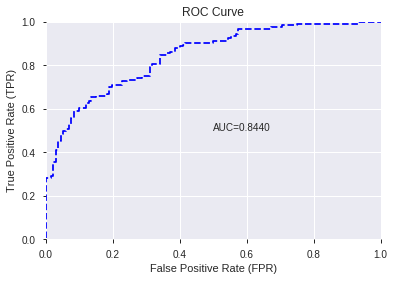

This function is available for GLM models only


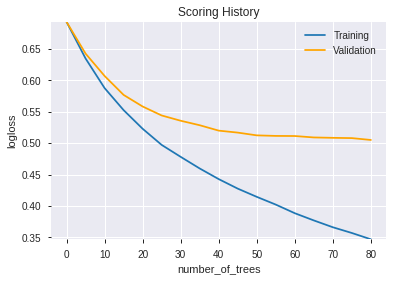

--2019-08-22 13:19:05--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.186.147
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.186.147|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.calculateChildInclusiveNa(Sha

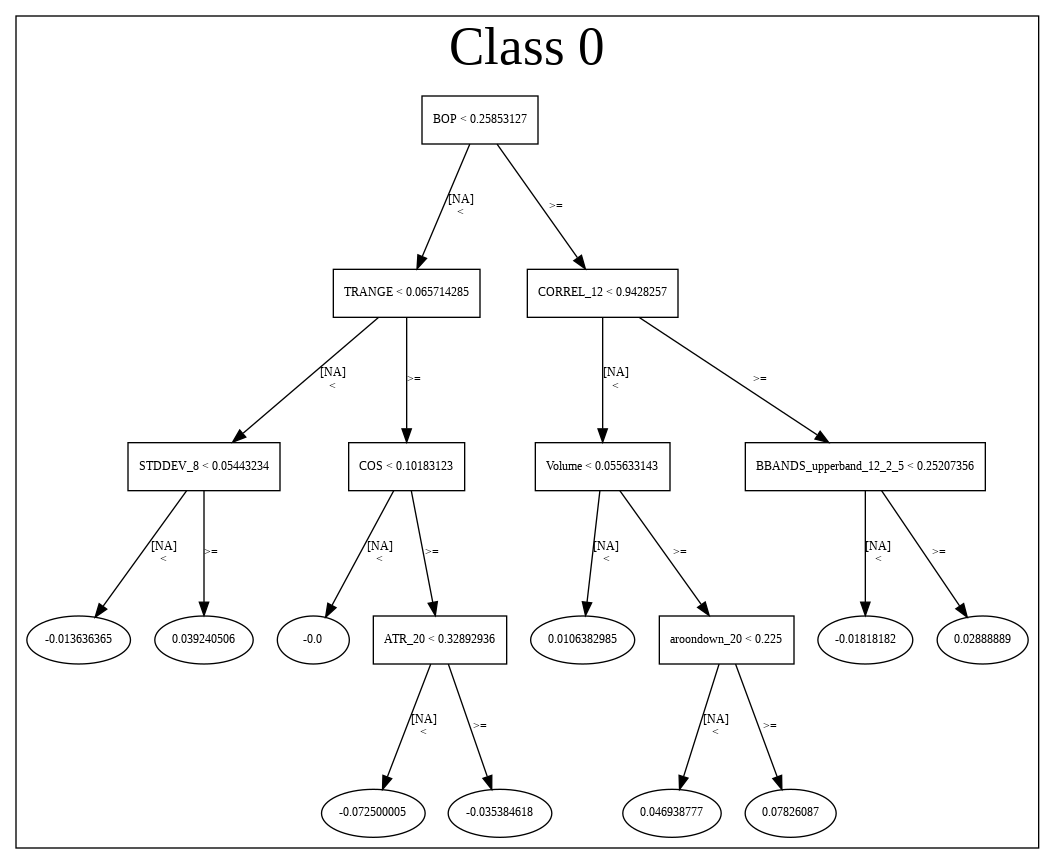

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_1_AutoML_20190822_131837',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_1_AutoML_20190822_131837',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_92dd',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_114_sid_92dd',
   'ty

['CDLGRAVESTONEDOJI',
 'CDLDRAGONFLYDOJI',
 'CCI_14',
 'STOCHF_fastk',
 'ULTOSC',
 'BBANDS_lowerband_20_3_2',
 'DX_8',
 'BETA_12',
 'TRANGE',
 'WILLR_8',
 'MACD_hist',
 'STOCH_slowk',
 'CCI_30',
 'MINUS_DM_8',
 'aroonup_14',
 'ROC_8',
 'NATR_8',
 'WILLR_20',
 'BBANDS_upperband_20_6_4',
 'MACDEXT_signal',
 'WILLR_14',
 'DX_14',
 'PLUS_DI_12',
 'ROCR100_12',
 'HT_PHASOR_quadrature',
 'MACDFIX_14',
 'CMO_20',
 'WILLR_12',
 'BBANDS_middleband_14_3_3',
 'CMO_12',
 'MAVP_14_6',
 'ROC_30',
 'BBANDS_upperband_14_2_5',
 'HT_DCPERIOD',
 'PLUS_DM_20',
 'BBANDS_upperband_14_4_4',
 'CMO_8',
 'MOM_14',
 'PLUS_DI_14',
 'AROONOSC_24',
 'PLUS_DI_20',
 'MOM_30',
 'ROCP_14',
 'aroondown_14',
 'BBANDS_upperband_24_2_5',
 'BBANDS_upperband_20_1_5',
 'ROCR100_14',
 'PLUS_DI_24',
 'RSI_12',
 'CDLSPINNINGTOP',
 'RSI_20']

In [53]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [54]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.789
GLM             0.785
XGBoost         0.781
dtype: float64

DeepLearning    GLM  XGBoost
All          0.789  0.785    0.766
DLF          0.781  0.781    0.781
Fwe          0.789  0.773    0.770
RFE          0.762  0.773    0.762
XGBF         0.766  0.781    0.781





F1


DeepLearning    0.783
GLM             0.786
XGBoost         0.788
dtype: float64

DeepLearning    GLM  XGBoost
All          0.774  0.782    0.761
DLF          0.783  0.786    0.788
Fwe          0.778  0.779    0.764
RFE          0.766  0.766    0.770
XGBF         0.777  0.786    0.788





auc


DeepLearning    0.857
GLM             0.867
XGBoost         0.861
dtype: float64

DeepLearning    GLM  XGBoost
All          0.857  0.865    0.842
DLF          0.852  0.867    0.861
Fwe          0.843  0.848    0.838
RFE          0.834  0.846    0.844
XGBF         0.851  0.867    0.861





logloss


DeepLearning    0.546
GLM             0.496
XGBoost         0.507
dtype: float64

DeepLearning    GLM  XGBoost
All          0.495  0.484    0.500
DLF          0.502  0.456    0.476
Fwe          0.546  0.487    0.507
RFE          0.500  0.496    0.500
XGBF         0.496  0.456    0.476





mean_per_class_error


DeepLearning    0.237
GLM             0.228
XGBoost         0.242
dtype: float64

DeepLearning    GLM  XGBoost
All          0.215  0.215    0.236
DLF          0.218  0.221    0.220
Fwe          0.213  0.225    0.236
RFE          0.237  0.228    0.242
XGBF         0.235  0.221    0.220





rmse


DeepLearning    0.422
GLM             0.408
XGBoost         0.410
dtype: float64

DeepLearning    GLM  XGBoost
All          0.406  0.398    0.407
DLF          0.408  0.387    0.395
Fwe          0.422  0.403    0.410
RFE          0.409  0.408    0.409
XGBF         0.405  0.387    0.395





mse


DeepLearning    0.178
GLM             0.166
XGBoost         0.168
dtype: float64

DeepLearning    GLM  XGBoost
All          0.165  0.158    0.165
DLF          0.167  0.150    0.156
Fwe          0.178  0.162    0.168
RFE          0.168  0.166    0.167
XGBF         0.164  0.150    0.156

{'F1':       DeepLearning    GLM  XGBoost
 All          0.774    NaN      NaN
 DLF          0.783    NaN      NaN
 DLF            NaN  0.786      NaN
 DLF            NaN    NaN    0.788
 All            NaN  0.782      NaN
 All            NaN    NaN    0.761
 XGBF         0.777    NaN      NaN
 XGBF           NaN  0.786      NaN
 XGBF           NaN    NaN    0.788
 Fwe          0.778    NaN      NaN
 Fwe            NaN  0.779      NaN
 Fwe            NaN    NaN    0.764
 RFE          0.766    NaN      NaN
 RFE            NaN  0.766      NaN
 RFE            NaN    NaN    0.770,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.789    NaN      NaN
 DLF          0.781    NaN      NaN
 DLF            NaN  0.781      NaN
 DLF            NaN    NaN    0.781
 All            NaN  0.785      NaN
 All            NaN    NaN    0.766
 XGBF         0.766    NaN      NaN
 XGBF           NaN  0.781      NaN
 XGBF           NaN    NaN    0.781
 Fwe          0.789    NaN      NaN
 Fwe     